In [1]:
import numpy as np
import cv2
from skimage.transform import rescale

%pylab inline
import matplotlib.pyplot as plt

In [43]:
import os


def load_image(path, scale=None):
    """Loads image from given path.
   
    :param path (str): Image path.
    :param scale (float): Image scale.
    :return: Image loaded from the path as a numpy.ndarray.
    :rtype: numpy.ndarray
    :raises FileNotFoundError: If path does not exist.
    """
    if not os.path.exists(path):
        raise FileNotFoundError("No such file or directory: '{}'".format(path))

    target = cv2.imread(path, cv2.IMREAD_COLOR)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

    if scale:
        target = rescale(target, scale, multichannel=True, anti_aliasing=True)
    return target


def show_image(image):
    """Displays image.
    Arguments:
        image (numpy.ndarray): image to be displayed
    """
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()

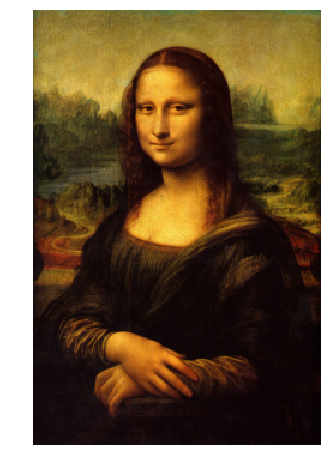

In [44]:
img_arr = load_image('MonaLisa.jpg', scale=0.3)
show_image(img_arr)

# ES(1+1)

In [10]:
import os
import numpy as np
import cv2
from skimage.transform import rescale

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [41]:
def load_image(path, scale=None):
    """Loads image from given path.
   
    :param path (str): Image path.
    :param scale (float): Image scale.
    :return: Image loaded from the path as a numpy.ndarray.
    :rtype: numpy.ndarray
    :raises FileNotFoundError: If path does not exist.
    """
    if not os.path.exists(path):
        raise FileNotFoundError("No such file or directory: '{}'".format(path))

    target = cv2.imread(path, cv2.IMREAD_COLOR)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

    if scale:
        target = rescale(target, scale, multichannel=True, anti_aliasing=True)
    return target


def show_image(image):
    """Displays image.
    Arguments:
        image (numpy.ndarray): image to be displayed
    """
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()

In [160]:
class MseObjectiveFunction(object):
    """Mean Squared Error"""
    def __init__(self, target):
        self.target = target

    def score(self, individual):
        """Calculates Mean Squared Error for given phenotype."""
        return np.square(individual.phenotype - self.target).mean()
    
class ObjectiveFunction(object):
    def __init__(self, target):
        self.target = target

    def score(self, individual):
        return np.square(individual.phenotype - self.target).sum()

In [157]:
class Individual(object):
    def __init__(self, image_size, chromosome_length=100, chromosome=None):
        self.chromosome_length = chromosome.shape[0] if chromosome is not None else chromosome_length
        self.gene_length = 7
        self.chromosome = chromosome if chromosome is not None else np.random.randn(chromosome_length, self.gene_length)
        self.normalize()
        self.image_size = image_size
        self._phenotype = None
        
    @property
    def phenotype(self):
        return self._phenotype

    @phenotype.getter
    def phenotype(self):
        if self._phenotype is None:
            self.render()
        return self._phenotype
    
    @phenotype.setter 
    def phenotype(self, val): 
        self._phenotype = val 
    
    def decode_chromosome(self):
        circles = self.chromosome.copy()
        max_r = 0.5 * max(self.image_size[0], self.image_size[1])
        circles *= np.array([[self.image_size[1], self.image_size[0], max_r, 255, 255, 255, 255]])
        circles += np.array([0, 0, 1, 0, 0, 0, 10])
        return circles.astype(np.int16)

    def render(self):
        self.phenotype = np.ones(self.image_size) * 255
        circles = self.decode_chromosome()
        for x, y, radius, r, g, b, alpha in circles:
            background = self.phenotype.copy()
            cv2.circle(
                background,
                center=(x, y),
                radius=radius,
                color=(int(r), int(g), int(b)),
                thickness=-1,
            )
            alpha = alpha/255.0
            self.phenotype = cv2.addWeighted(background, 1- alpha, self.phenotype, alpha, 0)
        self.phenotype = self.phenotype.astype(np.int32)
    
    def normalize(self):
        chromosome_divided_by_2 = self.chromosome/2.0
        self.chromosome = np.absolute(chromosome_divided_by_2 - np.round(chromosome_divided_by_2))*2
#         self.chromosome = np.clip(self.chromosome, 0, 1)

    def mutate(self, sigma):
        new_individual = Individual(image_size=self.image_size, chromosome=self.chromosome.copy())

#         i = np.random.randint(0, self.chromosome_length)
#         num_of_params_to_modify = np.random.randint(0, self.gene_length)
#         selection = np.random.choice(self.gene_length, size=num_of_params_to_modify, replace=False)
#         if np.random.random() < 0.25:
#             new_individual.chromosome[i, selection] = np.random.randn(len(selection))
#         else:
#             new_individual.chromosome[i, selection] += sigma * np.random.randn(len(selection))
#         new_individual.normalize()

        if np.random.random() < 0.1:
            i = np.random.randint(0, self.chromosome_length)
            new_individual.chromosome[i] = np.random.randn(self.gene_length)
            new_individual.normalize()
        elif np.random.random() < 0.2:
            i, j = random.randint(0, self.chromosome_length, size=2)
            new_individual.chromosome[[i, j]] = new_individual.chromosome[[j, i]]
        else:
            new_individual.chromosome += sigma * np.random.randn(self.chromosome_length, self.gene_length)
            new_individual.normalize()

        return new_individual

In [ ]:
def render(individual):
        phenotype = np.ones(individual.image_size) * 255
        circles = individual.decode_chromosome()
        for x, y, radius, r, g, b, alpha in circles:
            background = phenotype.copy()
            cv2.circle(
                background,
                center=(x, y),
                radius=2,
                color=(int(r), int(g), int(b)),
                thickness=-1,
            )
            alpha = alpha/255.0
            phenotype = cv2.addWeighted(background, 1- alpha, phenotype, alpha, 0)
        return phenotype.astype(np.int32)
        

In [164]:
class Evolution(object):
    def __init__(self, target, chromosome_length=100, chromosome=None, filename=None):
        if filename:
            chromosome = self.load_chromosome(filename)
        self.target = target
        self.individual = Individual(image_size=target.shape, chromosome_length=chromosome_length, chromosome=chromosome)
            
    def save_chromosome(self, filename):
        np.savetxt(filename, self.individual.chromosome)
        
    def load_chromosome(self, filename):
        return np.loadtxt(filename)
        
    def print_progress(self, generation, score, sigma):
        print("Generation: {}, score: {:.8f}, sigma: {:.8f}".format(generation, score, sigma))
#         print(np.square(self.individual.phenotype - self.target))
#         show_image(render(self.individual))
        show_image(self.individual.phenotype)

    def evolve(self, objective_function=MseObjectiveFunction, sigma=1.0, theta1=1/0.82, theta2=0.999, k=1000,
               number_of_iterations=100000, log_frequency=1000, filename=None):
        objective_function = objective_function(self.target)

        score = objective_function.score(self.individual)
        successful_mutations_count = 0
        
        for i in range(number_of_iterations):

            mutated = self.individual.mutate(sigma)
            new_score = objective_function.score(mutated)

            if new_score < score:
                score = new_score
                self.individual = mutated
                successful_mutations_count += 1
            
            if (i + 1) % k == 0:
                if successful_mutations_count > k/5.0:
                    sigma = theta1 * sigma
                else:
                    sigma = theta2 * sigma
                successful_mutations_count = 0
                
            
            if i % log_frequency == 0:
                self.print_progress(i, score, sigma)
                
        if filename:   
            self.save_chromosome(filename)

(121, 80, 3)


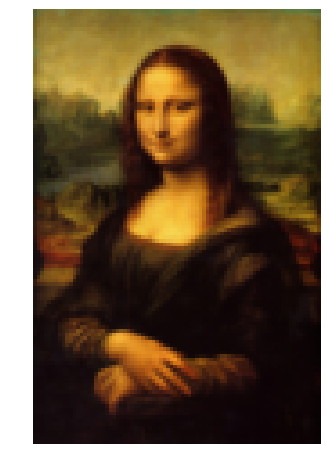

In [16]:
rescaled_mona_lisa = load_image('MonaLisa.jpg', scale=0.1)
print(rescaled_mona_lisa.shape)
show_image(rescaled_mona_lisa)

Generation: 0, score: 17454.66225922, sigma: 1.00000000


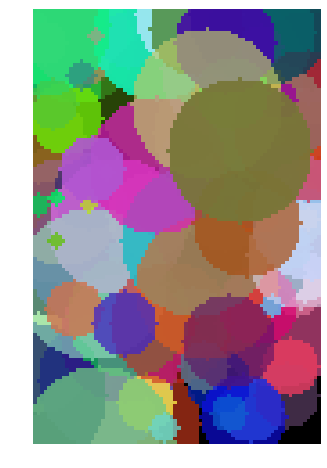

Generation: 1000, score: 6864.40940211, sigma: 0.99900000


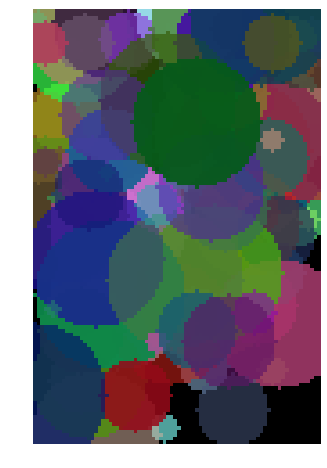

Generation: 2000, score: 4902.92281890, sigma: 0.99800100


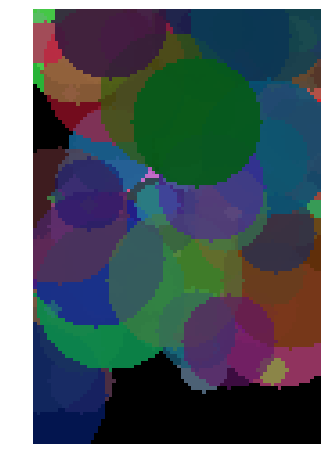

Generation: 3000, score: 3911.63643926, sigma: 0.99700300


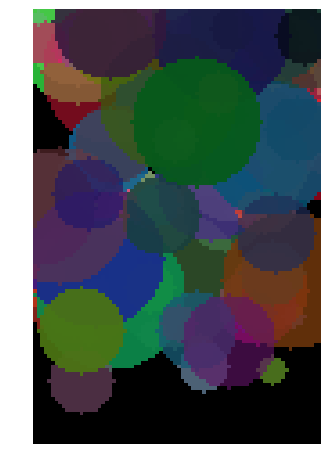

Generation: 4000, score: 3694.86070944, sigma: 0.99600600


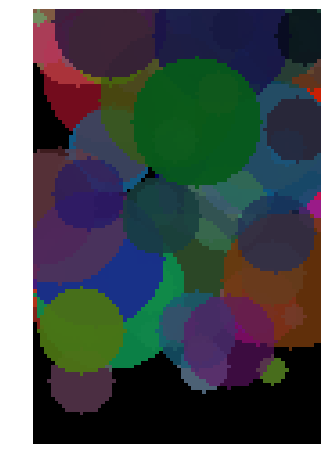

Generation: 5000, score: 3232.21538817, sigma: 0.99500999


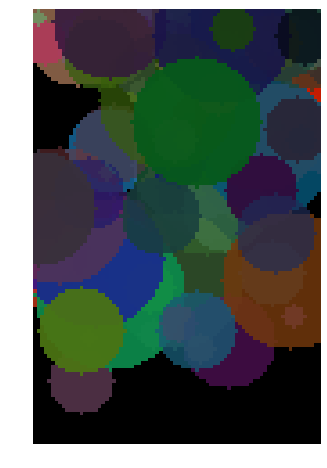

Generation: 6000, score: 2774.98816960, sigma: 0.99401498


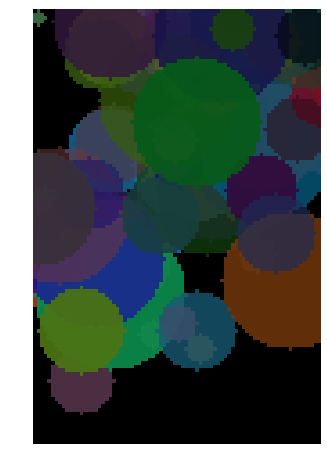

Generation: 7000, score: 2376.55091301, sigma: 0.99302097


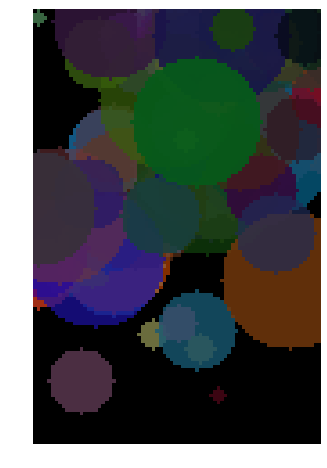

Generation: 8000, score: 2089.23704438, sigma: 0.99202794


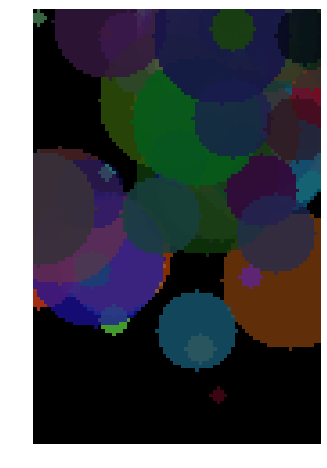

Generation: 9000, score: 1938.10526731, sigma: 0.99103592


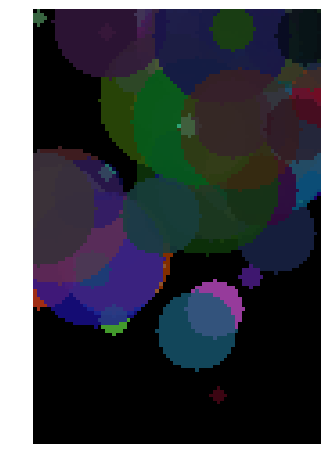

Generation: 10000, score: 1514.73050748, sigma: 0.99004488


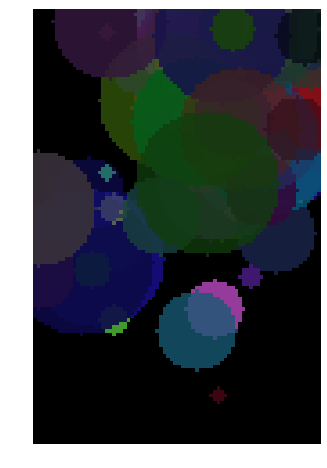

Generation: 11000, score: 1215.79887660, sigma: 0.98905484


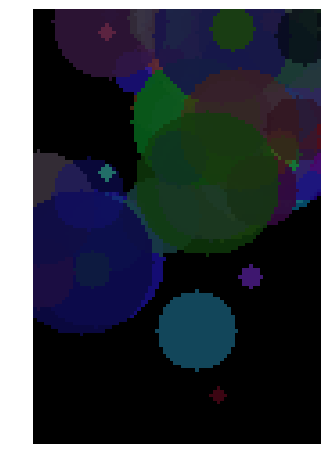

Generation: 12000, score: 1191.04891455, sigma: 0.98806578


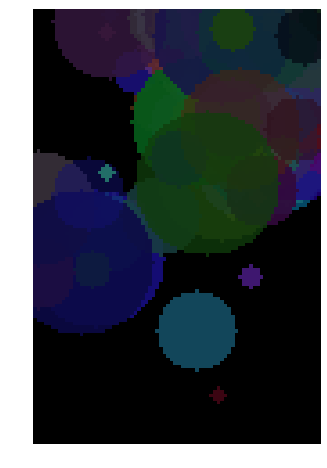

Generation: 13000, score: 1135.96164202, sigma: 0.98707771


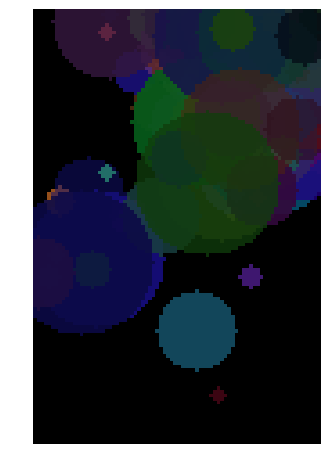

Generation: 14000, score: 1100.02931454, sigma: 0.98609064


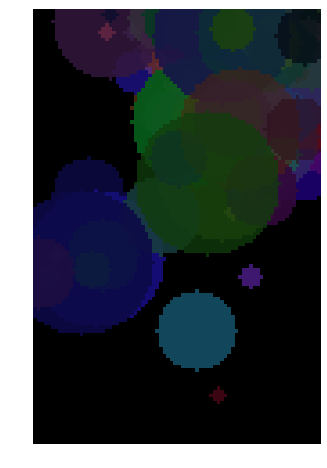

Generation: 15000, score: 854.45761641, sigma: 0.98510455


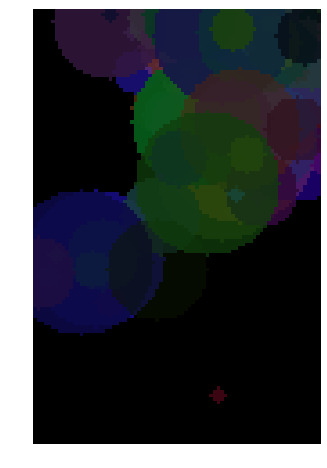

Generation: 16000, score: 793.31272039, sigma: 0.98411944


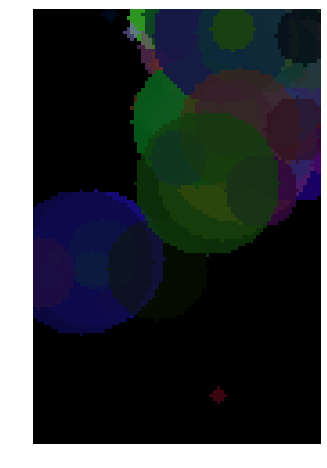

Generation: 17000, score: 751.82580302, sigma: 0.98313532


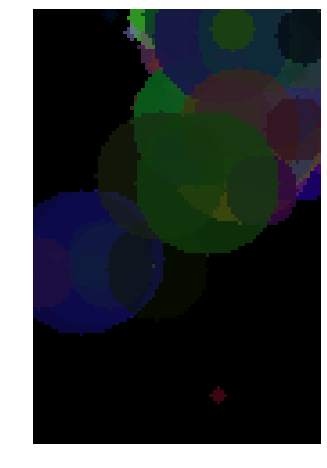

Generation: 18000, score: 650.83390989, sigma: 0.98215219


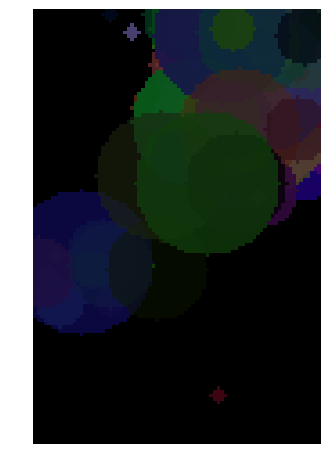

Generation: 19000, score: 591.23102354, sigma: 0.98117003


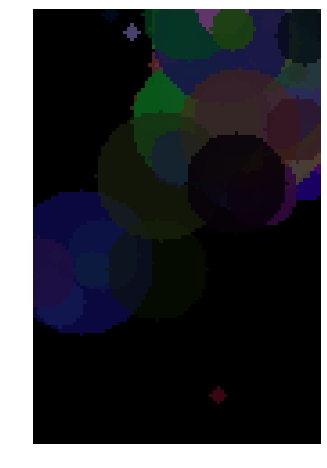

Generation: 20000, score: 584.06629855, sigma: 0.98018886


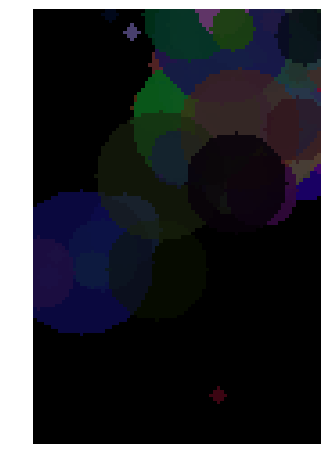

Generation: 21000, score: 559.24875034, sigma: 0.97920868


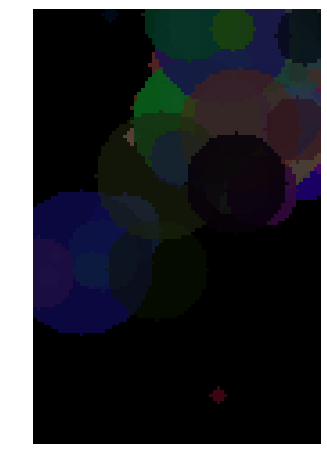

Generation: 22000, score: 552.93266218, sigma: 0.97822947


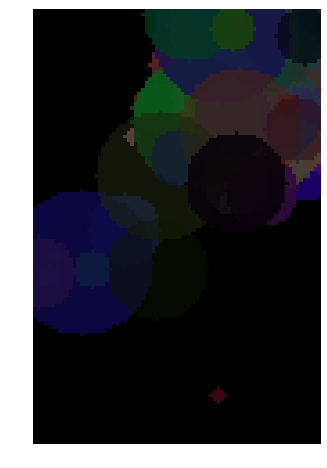

Generation: 23000, score: 530.18178989, sigma: 0.97725124


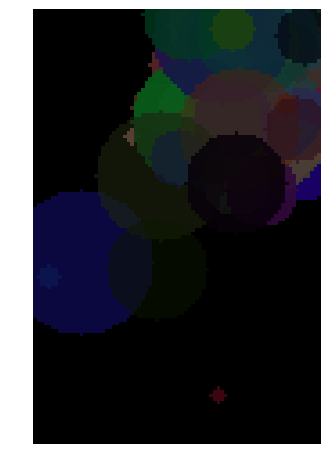

Generation: 24000, score: 526.25112381, sigma: 0.97627399


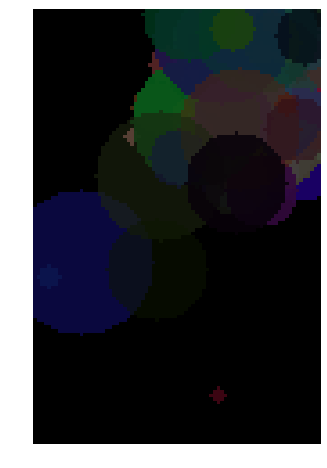

Generation: 25000, score: 415.56205572, sigma: 0.97529771


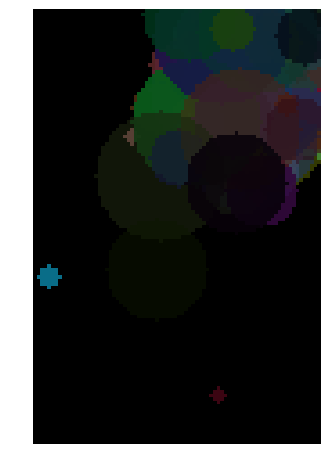

Generation: 26000, score: 383.78473195, sigma: 0.97432241


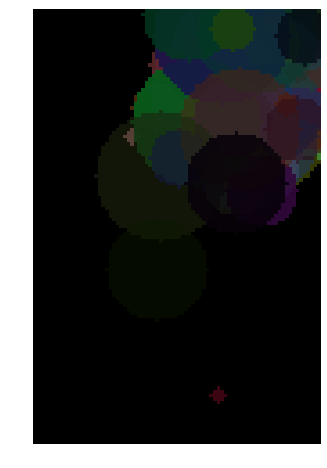

Generation: 27000, score: 382.57825737, sigma: 0.97334809


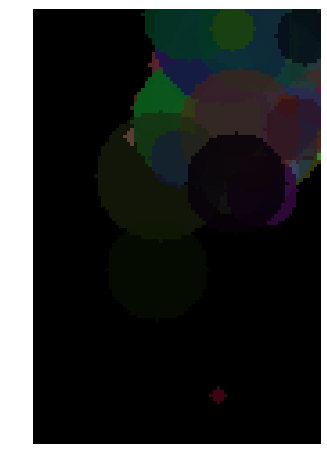

Generation: 28000, score: 381.77313692, sigma: 0.97237474


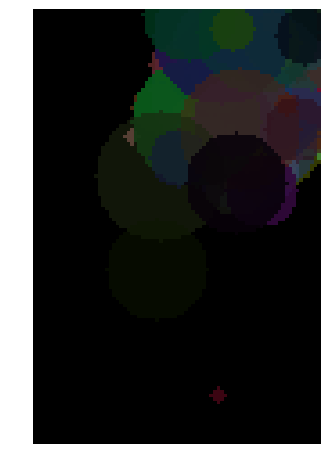

Generation: 29000, score: 381.07385668, sigma: 0.97140237


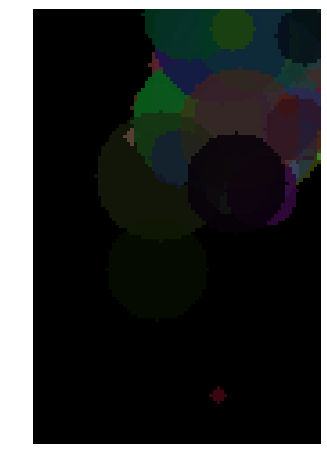

Generation: 30000, score: 363.86930259, sigma: 0.97043097


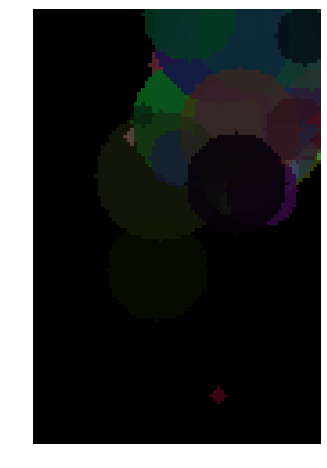

Generation: 31000, score: 363.52812301, sigma: 0.96946054


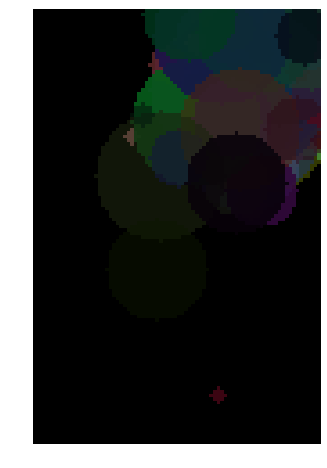

Generation: 32000, score: 363.11537386, sigma: 0.96849108


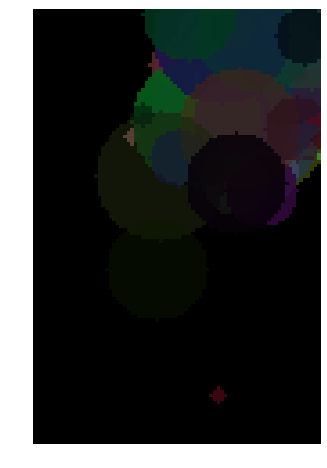

Generation: 33000, score: 355.61187672, sigma: 0.96752258


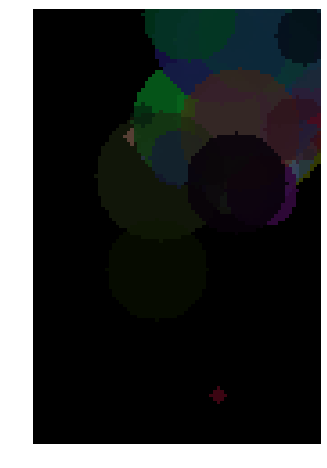

Generation: 34000, score: 354.95331537, sigma: 0.96655506


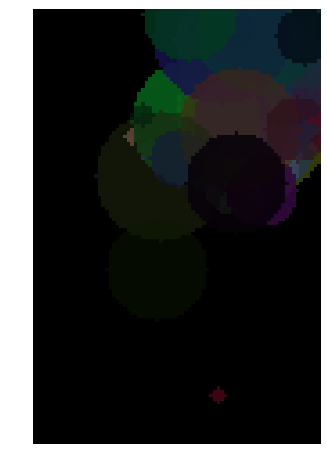

Generation: 35000, score: 349.16250993, sigma: 0.96558851


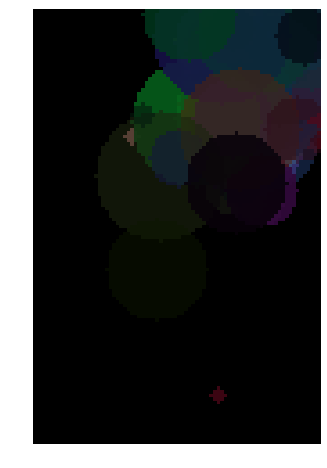

Generation: 36000, score: 347.05505955, sigma: 0.96462292


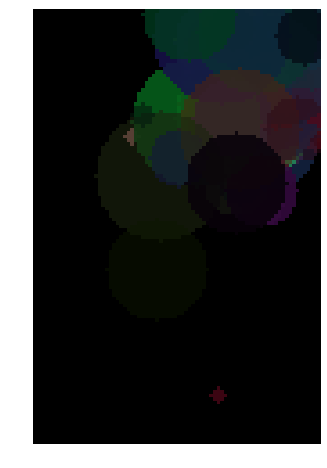

Generation: 37000, score: 346.59941548, sigma: 0.96365830


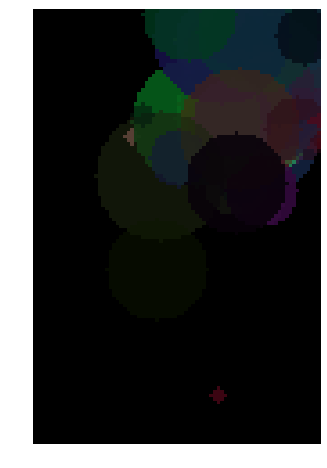

Generation: 38000, score: 346.28486165, sigma: 0.96269464


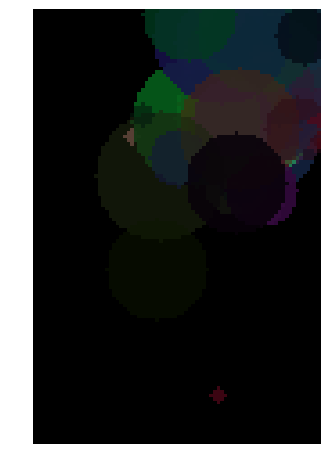

Generation: 39000, score: 330.12318270, sigma: 0.96173194


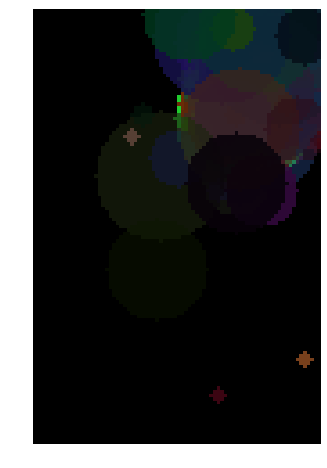

Generation: 40000, score: 327.70246847, sigma: 0.96077021


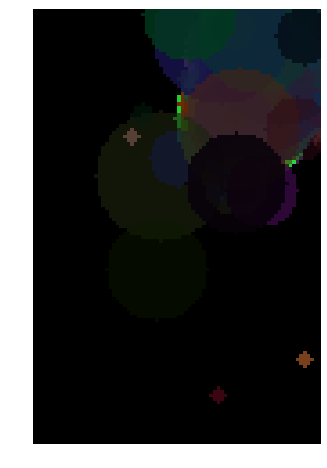

Generation: 41000, score: 326.31345095, sigma: 0.95980944


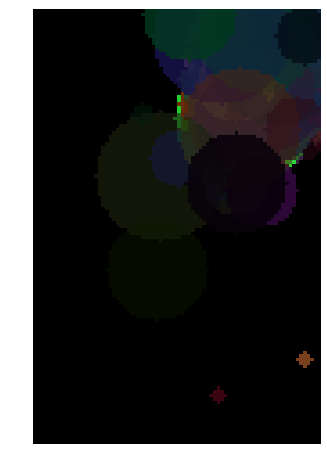

Generation: 42000, score: 310.03824049, sigma: 0.95884963


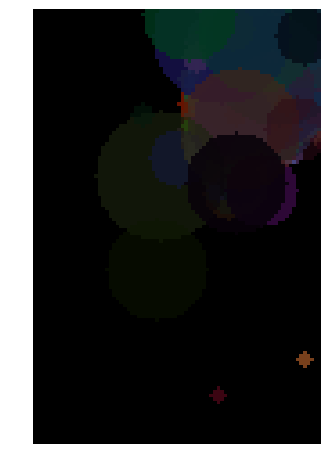

Generation: 43000, score: 305.20836554, sigma: 0.95789078


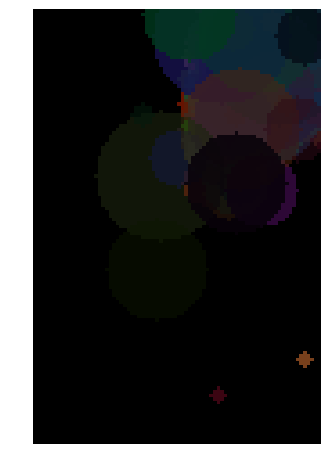

Generation: 44000, score: 291.02323536, sigma: 0.95693289


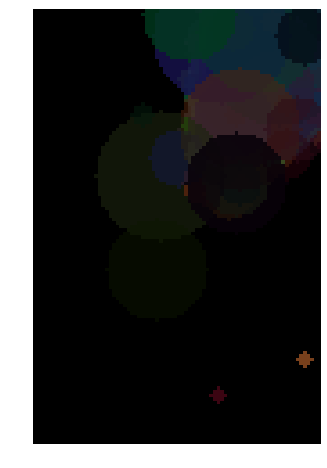

Generation: 45000, score: 290.24733822, sigma: 0.95597596


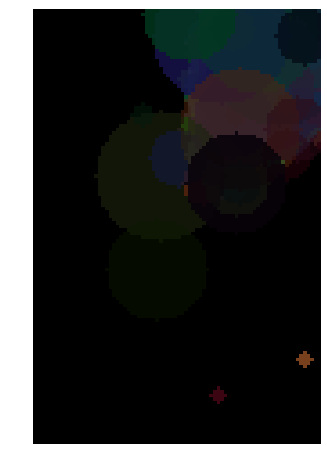

Generation: 46000, score: 285.36212824, sigma: 0.95501998


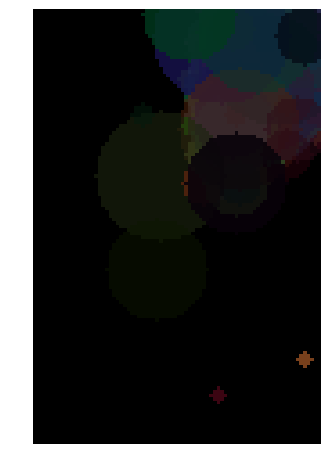

Generation: 47000, score: 284.70401515, sigma: 0.95406496


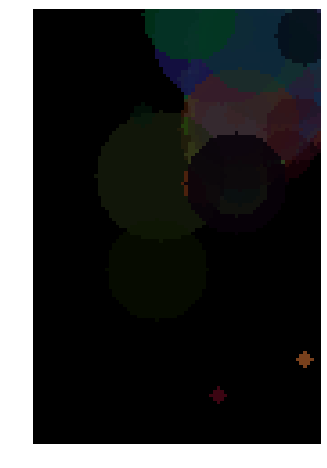

Generation: 48000, score: 280.33537224, sigma: 0.95311090


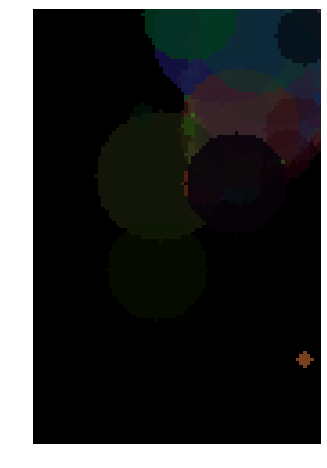

Generation: 49000, score: 278.29863245, sigma: 0.95215779


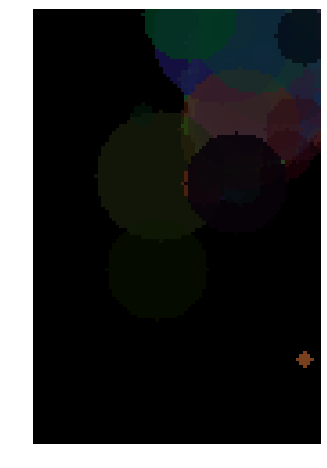

Generation: 50000, score: 276.88786238, sigma: 0.95120563


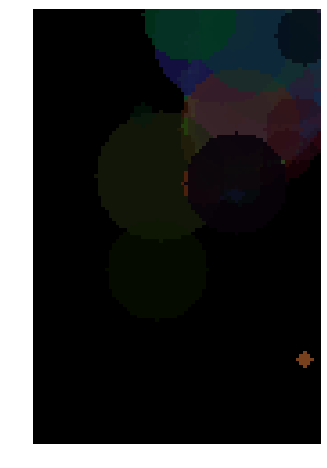

Generation: 51000, score: 267.47449428, sigma: 0.95025442


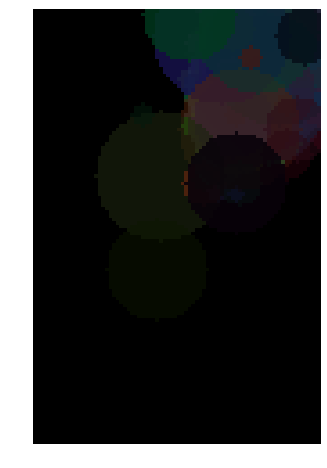

Generation: 52000, score: 266.98059242, sigma: 0.94930417


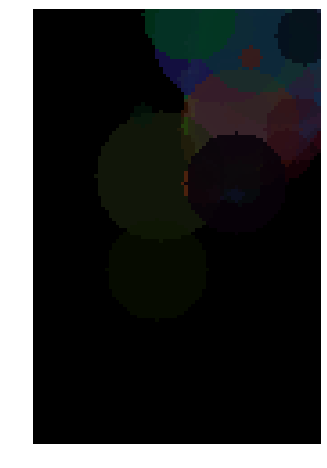

Generation: 53000, score: 266.74530749, sigma: 0.94835486


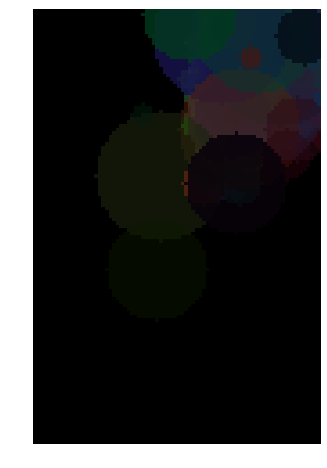

Generation: 54000, score: 266.73067088, sigma: 0.94740651


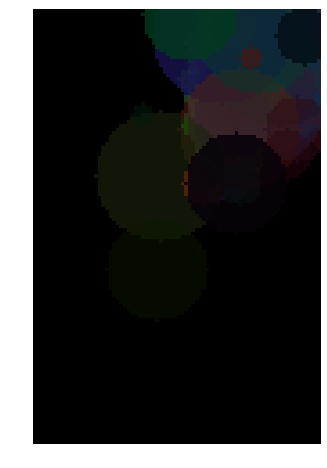

Generation: 55000, score: 265.78296906, sigma: 0.94645910


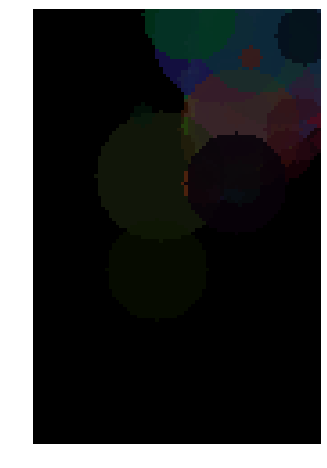

Generation: 56000, score: 265.68879855, sigma: 0.94551264


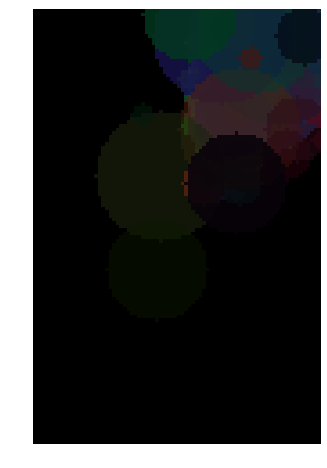

Generation: 57000, score: 265.45678328, sigma: 0.94456713


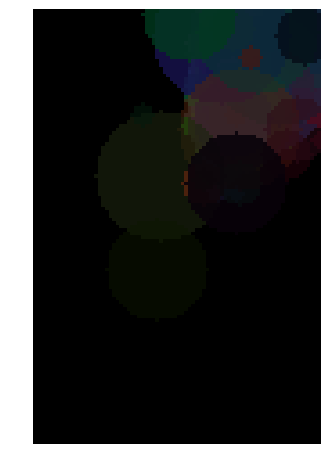

Generation: 58000, score: 265.28418571, sigma: 0.94362256


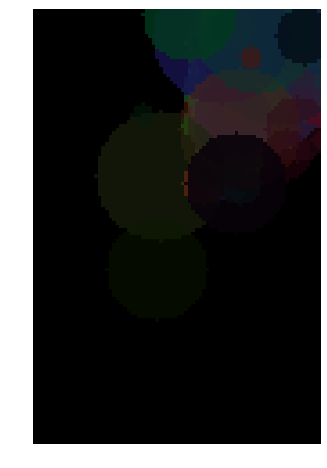

Generation: 59000, score: 265.11992762, sigma: 0.94267894


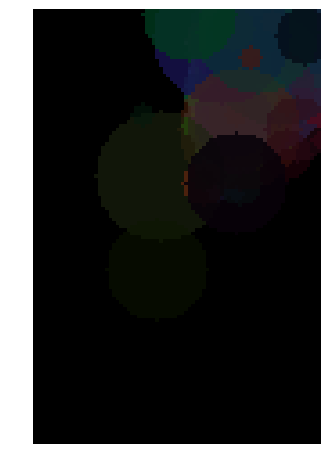

Generation: 60000, score: 264.20408166, sigma: 0.94173626


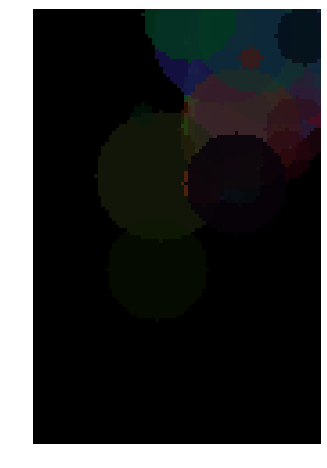

Generation: 61000, score: 264.16626148, sigma: 0.94079453


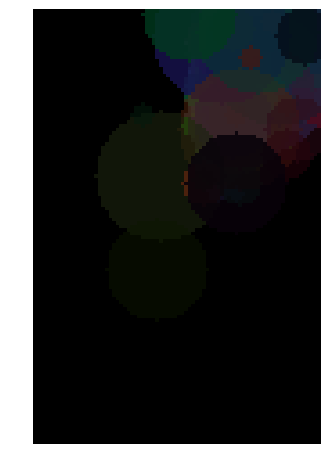

Generation: 62000, score: 263.29229055, sigma: 0.93985373


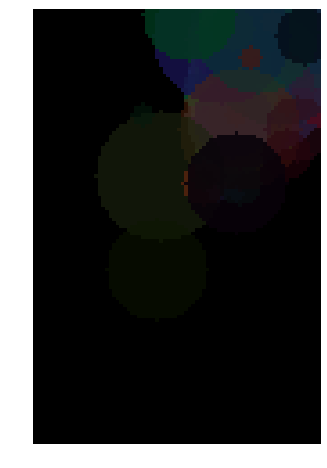

Generation: 63000, score: 263.25297494, sigma: 0.93891388


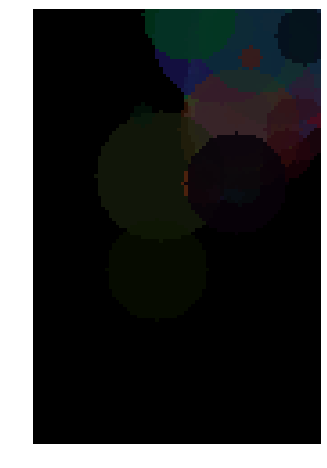

Generation: 64000, score: 263.25018825, sigma: 0.93797496


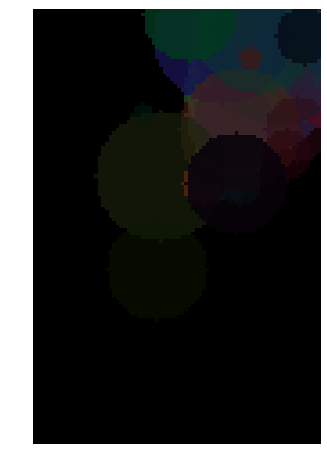

Generation: 65000, score: 262.82532221, sigma: 0.93703699


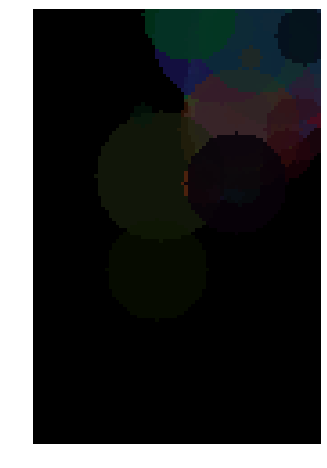

Generation: 66000, score: 251.92328182, sigma: 0.93609995


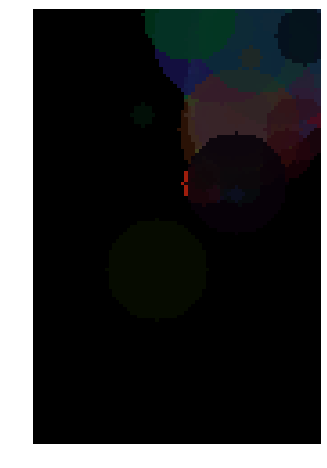

Generation: 67000, score: 251.23702878, sigma: 0.93516385


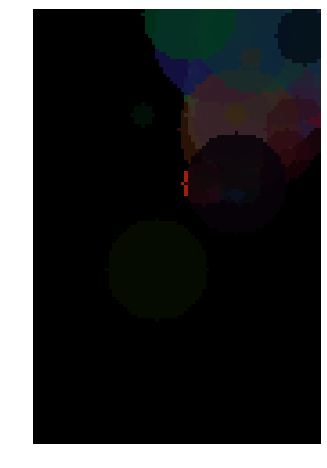

Generation: 68000, score: 251.23077655, sigma: 0.93422869


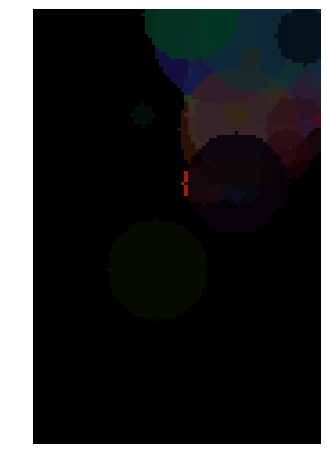

Generation: 69000, score: 249.65340389, sigma: 0.93329446


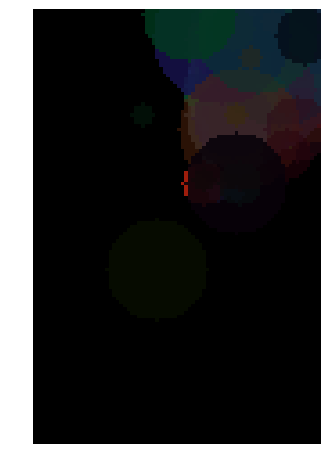

Generation: 70000, score: 244.48664756, sigma: 0.93236116


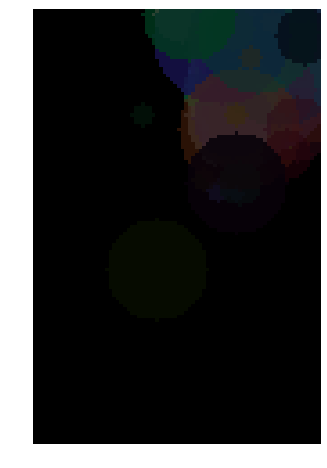

Generation: 71000, score: 244.44266691, sigma: 0.93142880


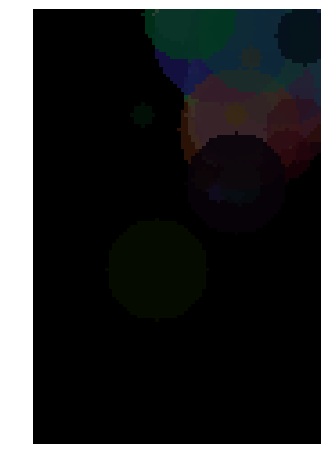

Generation: 72000, score: 243.54645263, sigma: 0.93049737


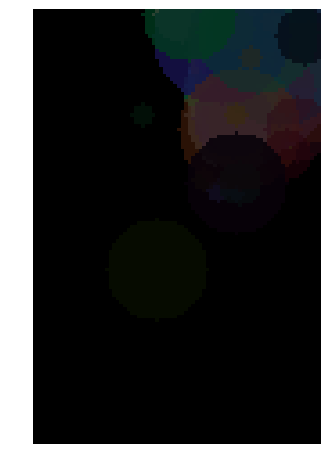

Generation: 73000, score: 240.18930191, sigma: 0.92956688


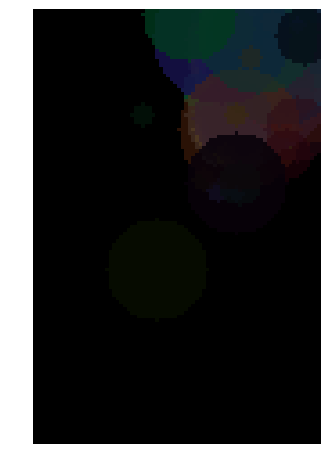

Generation: 74000, score: 240.06693695, sigma: 0.92863731


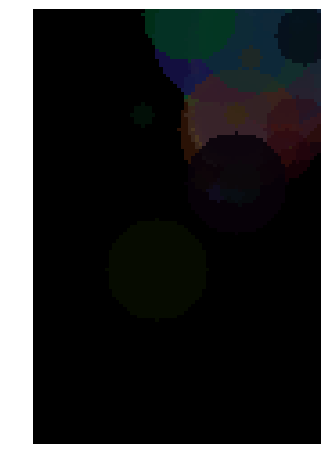

Generation: 75000, score: 238.14586608, sigma: 0.92770867


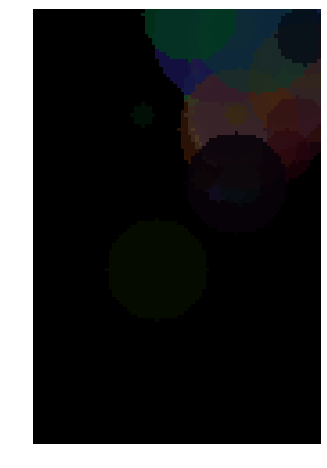

Generation: 76000, score: 237.80434438, sigma: 0.92678096


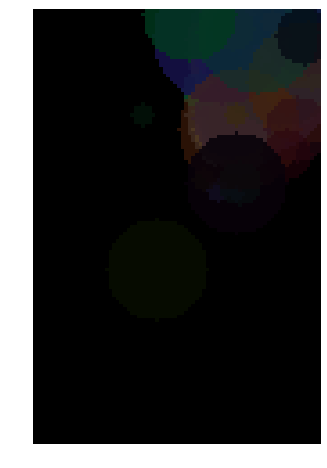

Generation: 77000, score: 237.72128180, sigma: 0.92585418


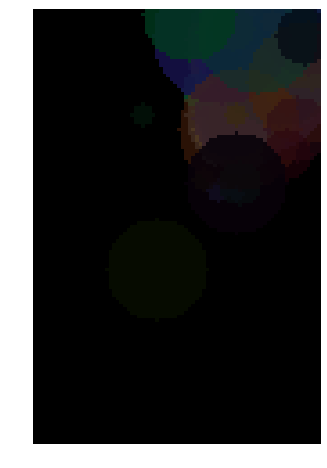

Generation: 78000, score: 237.67338857, sigma: 0.92492833


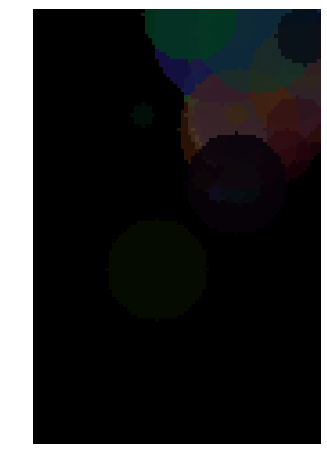

Generation: 79000, score: 237.58450704, sigma: 0.92400340


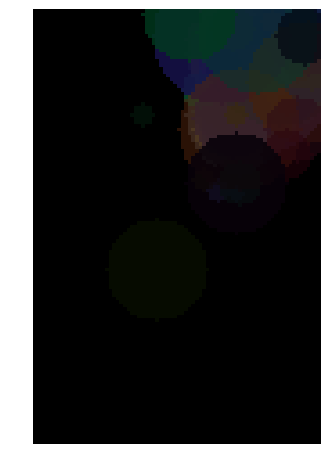

Generation: 80000, score: 237.52309978, sigma: 0.92307940


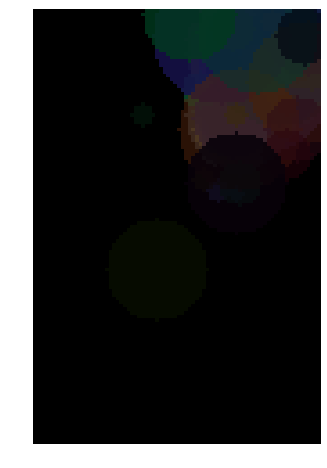

Generation: 81000, score: 237.26624453, sigma: 0.92215632


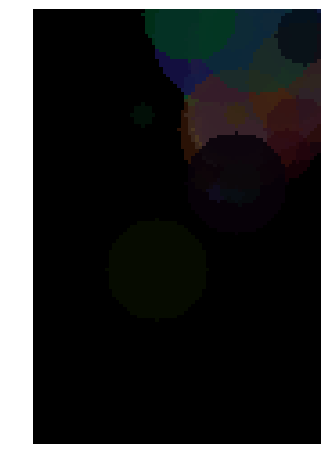

Generation: 82000, score: 221.81238022, sigma: 0.92123416


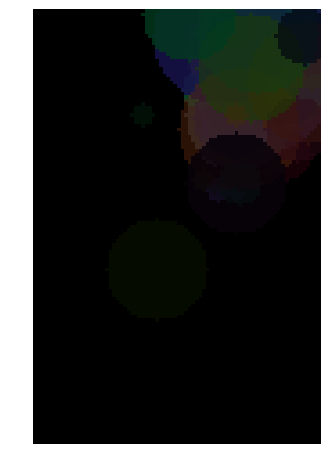

Generation: 83000, score: 214.89240554, sigma: 0.92031293


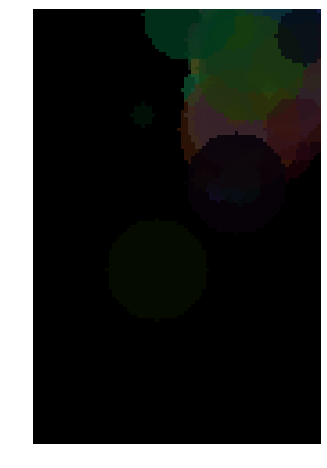

Generation: 84000, score: 212.50978495, sigma: 0.91939262


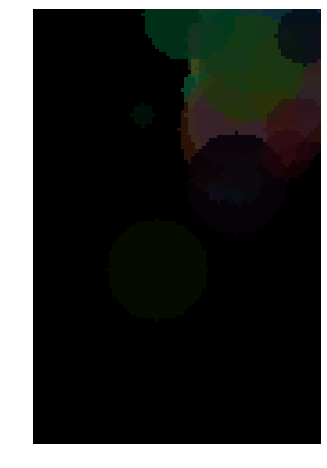

Generation: 85000, score: 212.36056737, sigma: 0.91847322


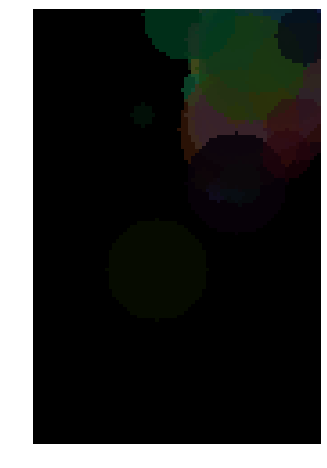

Generation: 86000, score: 208.47464579, sigma: 0.91755475


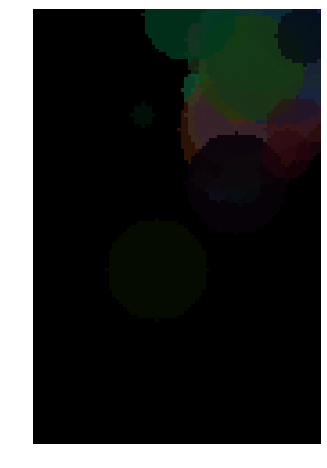

Generation: 87000, score: 203.77519432, sigma: 0.91663719


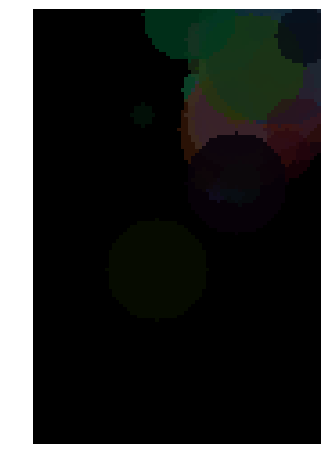

Generation: 88000, score: 199.75077446, sigma: 0.91572056


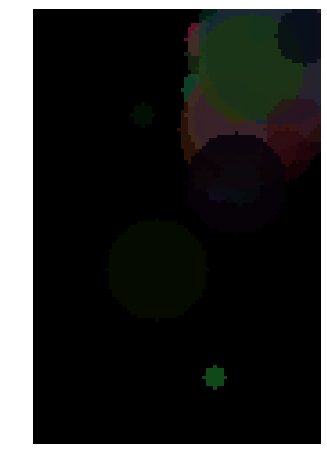

Generation: 89000, score: 196.56420502, sigma: 0.91480484


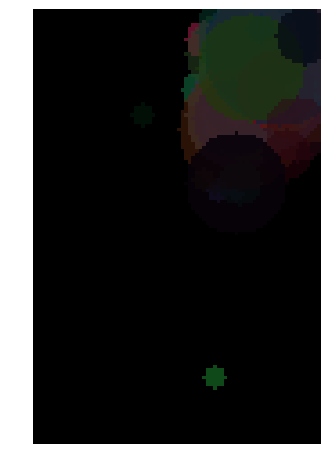

Generation: 90000, score: 174.97369207, sigma: 0.91389003


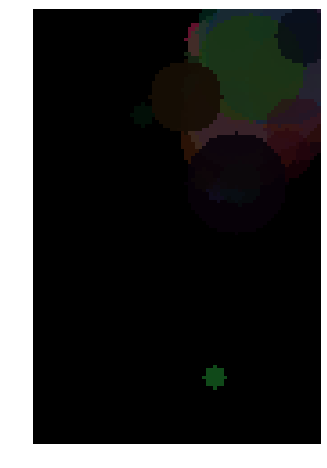

Generation: 91000, score: 174.84365581, sigma: 0.91297614


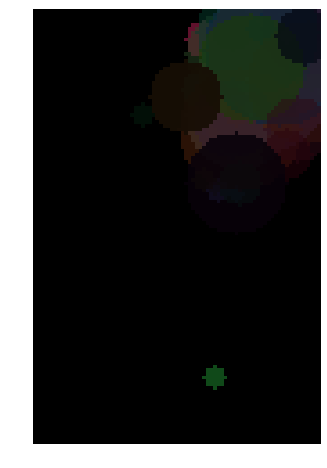

Generation: 92000, score: 174.69545542, sigma: 0.91206317


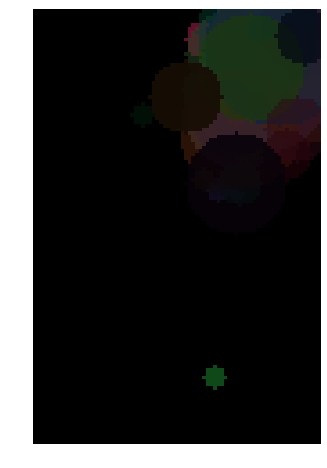

Generation: 93000, score: 167.22281917, sigma: 0.91115110


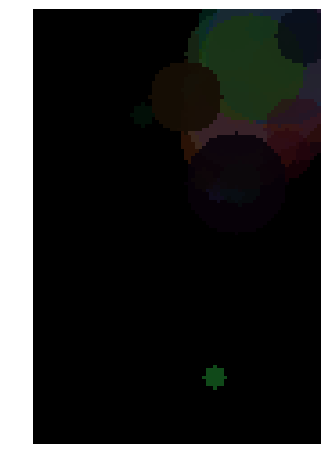

Generation: 94000, score: 167.21143224, sigma: 0.91023995


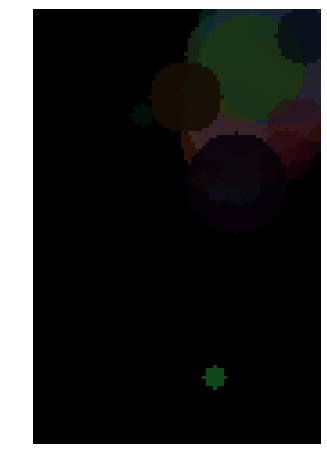

Generation: 95000, score: 166.74965997, sigma: 0.90932971


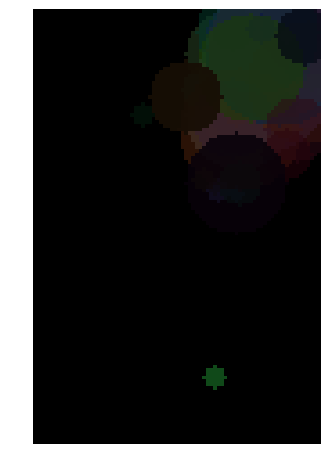

Generation: 96000, score: 166.71325035, sigma: 0.90842038


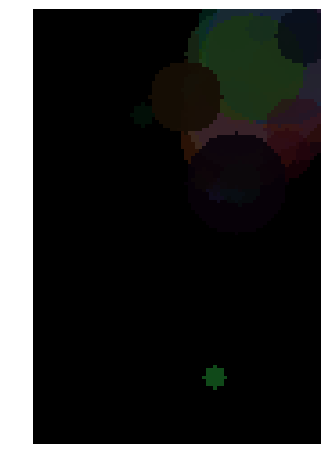

Generation: 97000, score: 166.69371395, sigma: 0.90751196


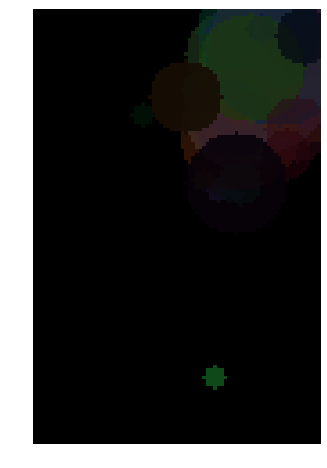

Generation: 98000, score: 166.65824765, sigma: 0.90660445


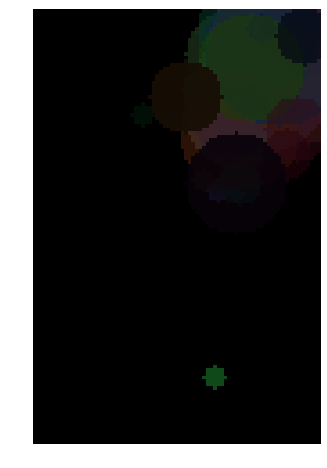

Generation: 99000, score: 166.64242951, sigma: 0.90569784


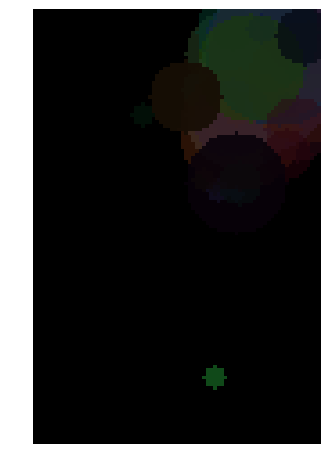

FileNotFoundError: [Errno 2] No such file or directory: 'results/mona01_best_chromosome.txt'

In [107]:
evolution = Evolution(target=rescaled_mona_lisa)
evolution.evolve(filename='results/mona01_best_chromosome.txt')

Generation: 0, score: 30035.11916721, sigma: 1.00000000


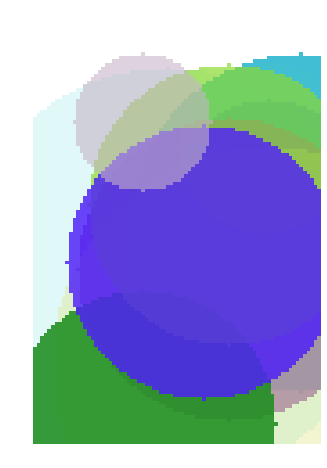

Generation: 1000, score: 3911.57604697, sigma: 0.99900000


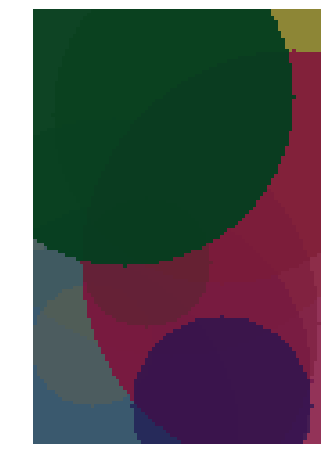

Generation: 2000, score: 3808.83332780, sigma: 0.99800100


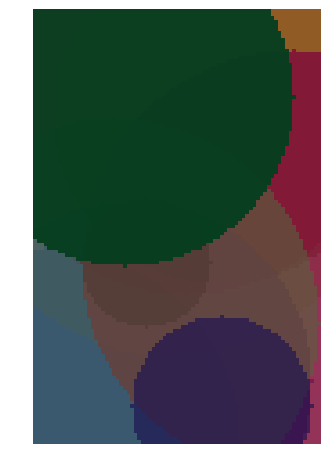

Generation: 3000, score: 3570.29701217, sigma: 0.99700300


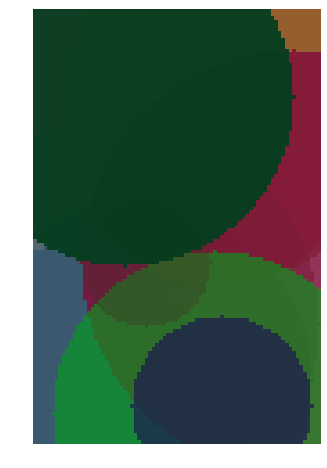

Generation: 4000, score: 2958.93221919, sigma: 0.99600600


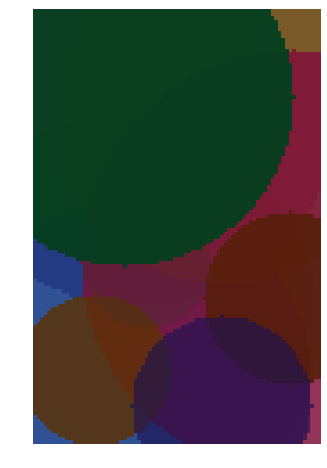

Generation: 5000, score: 2951.44814489, sigma: 0.99500999


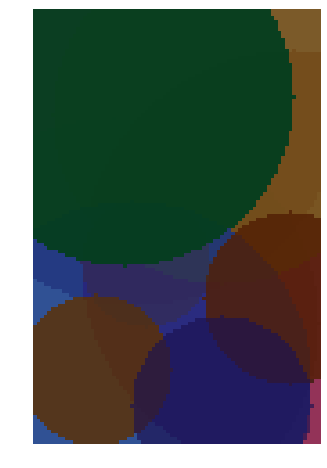

Generation: 6000, score: 2941.15321970, sigma: 0.99401498


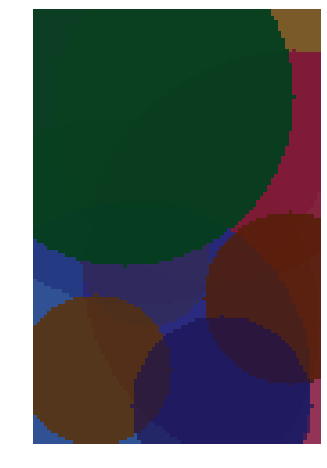

Generation: 7000, score: 2351.75358026, sigma: 0.99302097


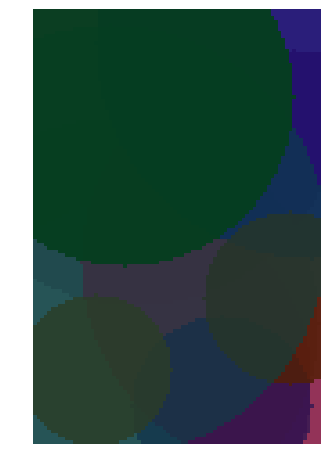

Generation: 8000, score: 2351.75358026, sigma: 0.99202794


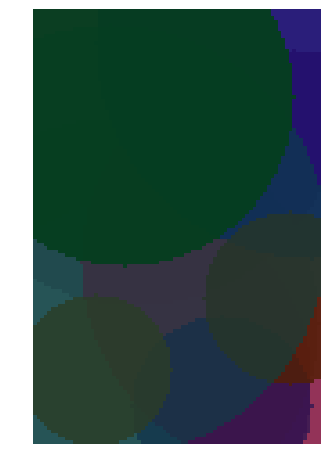

Generation: 9000, score: 2331.50624602, sigma: 0.99103592


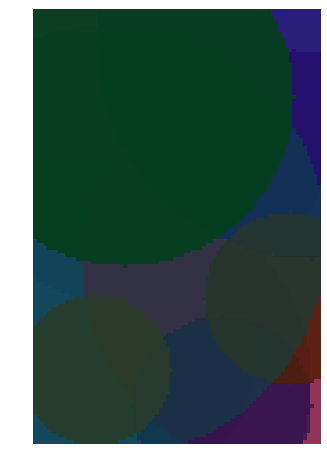

Generation: 10000, score: 2330.74939637, sigma: 0.99004488


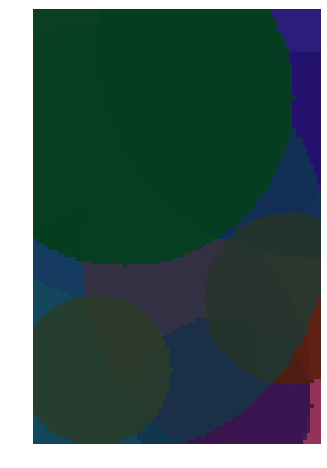

Generation: 11000, score: 2330.74939637, sigma: 0.98905484


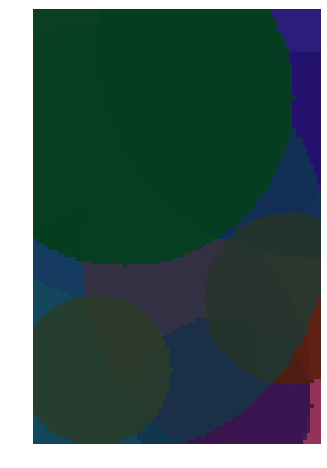

Generation: 12000, score: 2330.74939637, sigma: 0.98806578


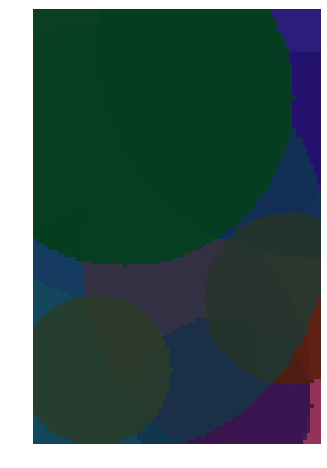

Generation: 13000, score: 2330.74939637, sigma: 0.98707771


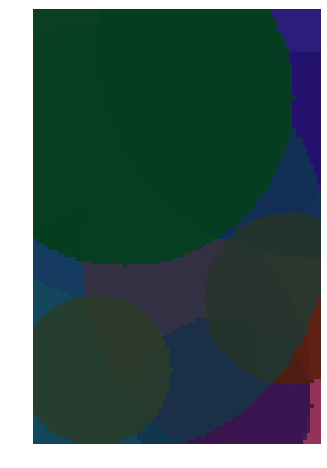

Generation: 14000, score: 2330.74939637, sigma: 0.98609064


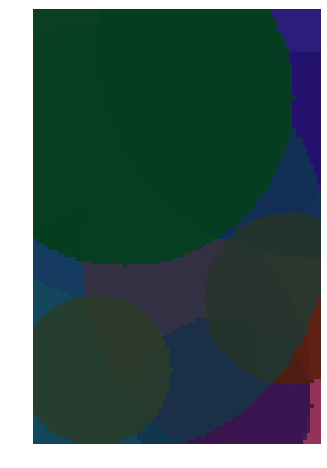

Generation: 15000, score: 2330.74939637, sigma: 0.98510455


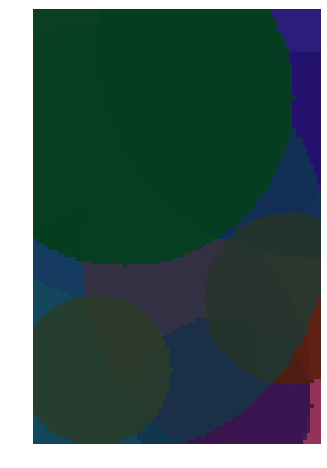

Generation: 16000, score: 2314.79397032, sigma: 0.98411944


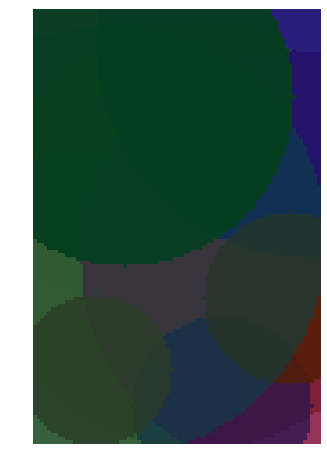

Generation: 17000, score: 2279.67760290, sigma: 0.98313532


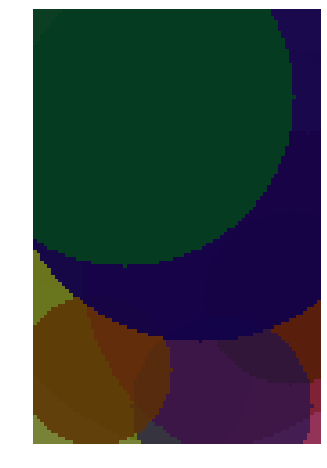

Generation: 18000, score: 2194.19632434, sigma: 0.98215219


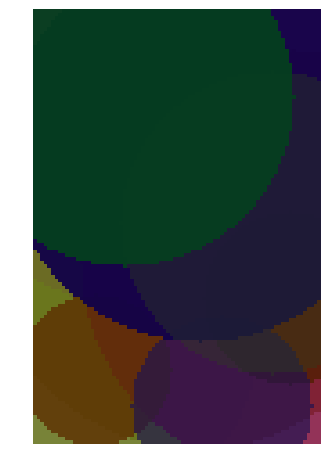

Generation: 19000, score: 2117.87829789, sigma: 0.98117003


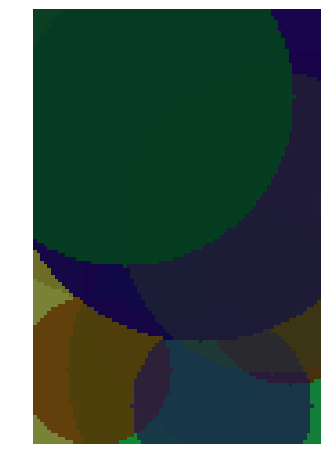

Generation: 20000, score: 2117.87829789, sigma: 0.98018886


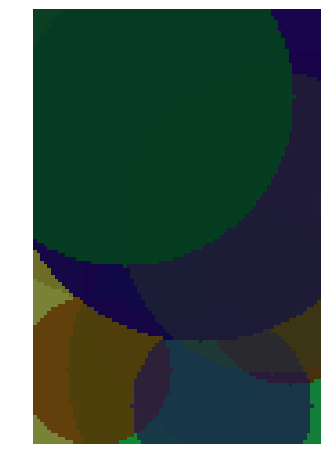

Generation: 21000, score: 2099.14158747, sigma: 0.97920868


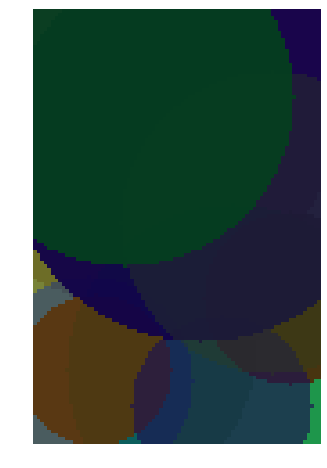

Generation: 22000, score: 2095.44093333, sigma: 0.97822947


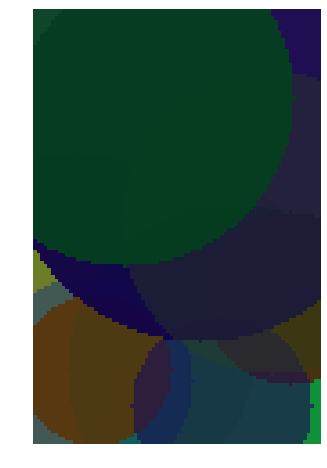

Generation: 23000, score: 2053.39305502, sigma: 0.97725124


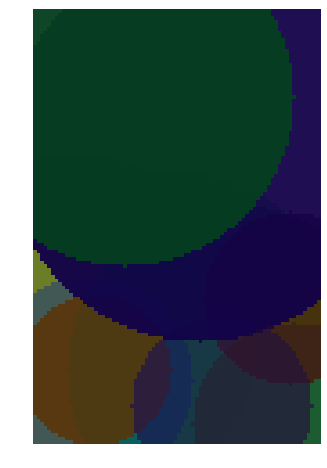

Generation: 24000, score: 2053.27146809, sigma: 0.97627399


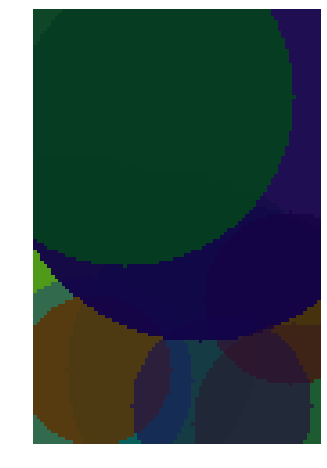

Generation: 25000, score: 2053.27146809, sigma: 0.97529771


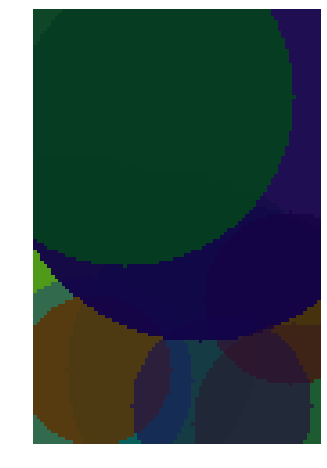

Generation: 26000, score: 2053.27146809, sigma: 0.97432241


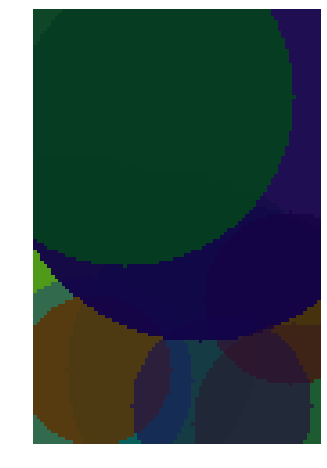

Generation: 27000, score: 2053.27146809, sigma: 0.97334809


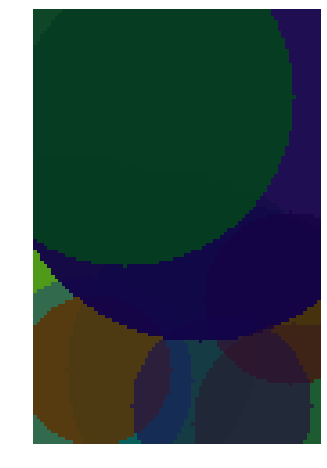

Generation: 28000, score: 2053.27146809, sigma: 0.97237474


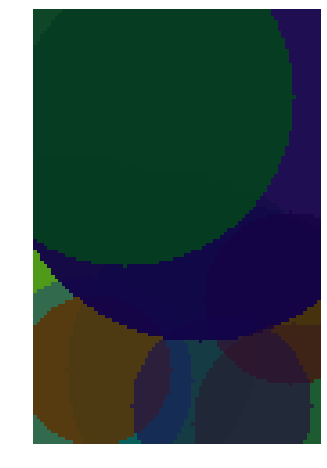

Generation: 29000, score: 2053.27146809, sigma: 0.97140237


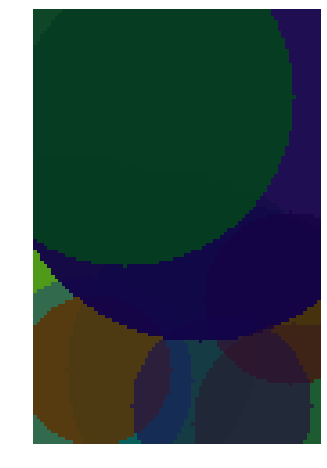

Generation: 30000, score: 1944.19889868, sigma: 0.97043097


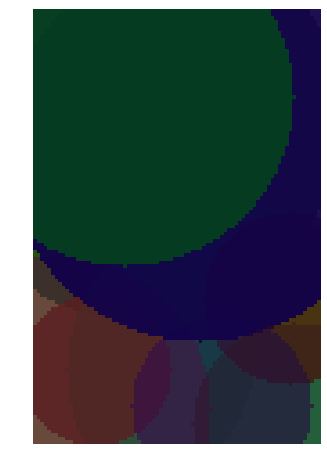

Generation: 31000, score: 1736.25668672, sigma: 0.96946054


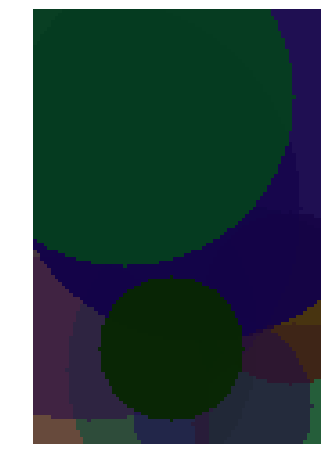

Generation: 32000, score: 1555.96122218, sigma: 0.96849108


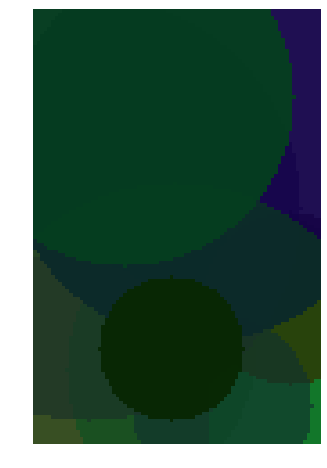

Generation: 33000, score: 1359.21595865, sigma: 0.96752258


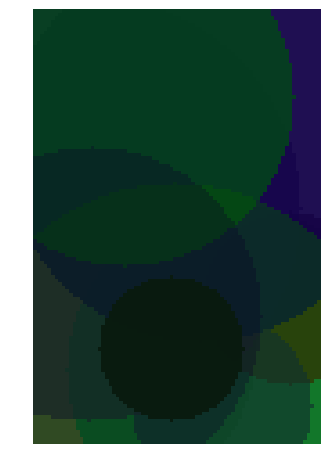

Generation: 34000, score: 1353.45962047, sigma: 0.96655506


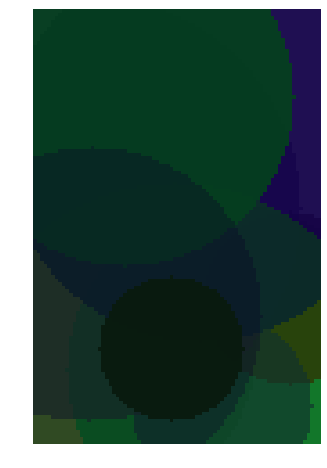

Generation: 35000, score: 1353.45962047, sigma: 0.96558851


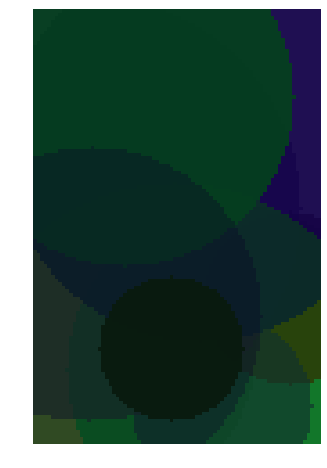

Generation: 36000, score: 1316.54550330, sigma: 0.96462292


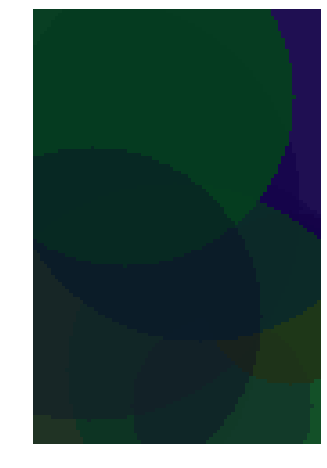

Generation: 37000, score: 1306.79791295, sigma: 0.96365830


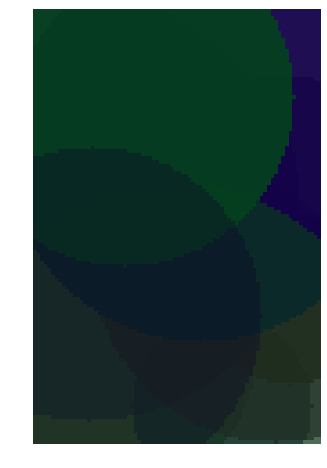

Generation: 38000, score: 1306.67577648, sigma: 0.96269464


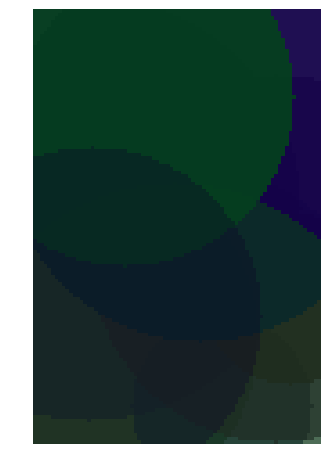

Generation: 39000, score: 1306.67577648, sigma: 0.96173194


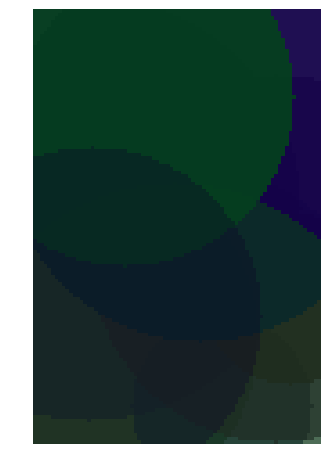

Generation: 40000, score: 1306.67577648, sigma: 0.96077021


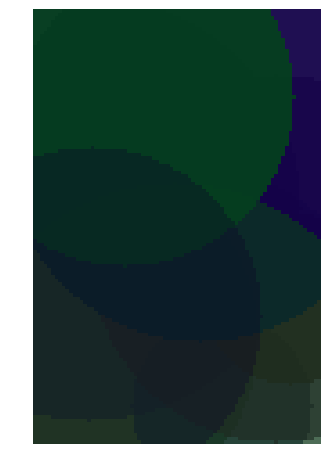

Generation: 41000, score: 1306.67577648, sigma: 0.95980944


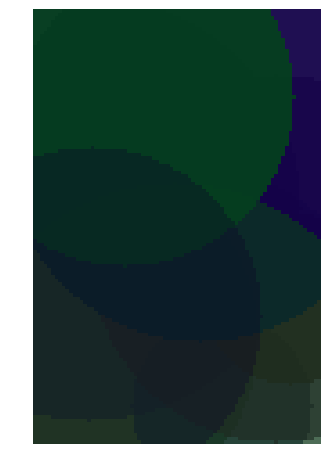

Generation: 42000, score: 1306.67577648, sigma: 0.95884963


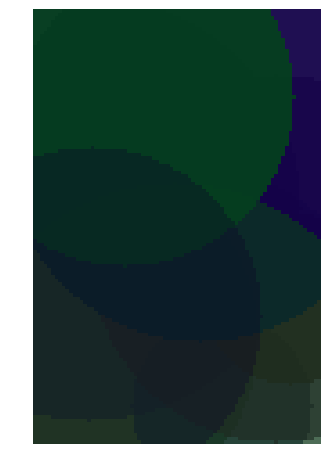

Generation: 43000, score: 1306.33196842, sigma: 0.95789078


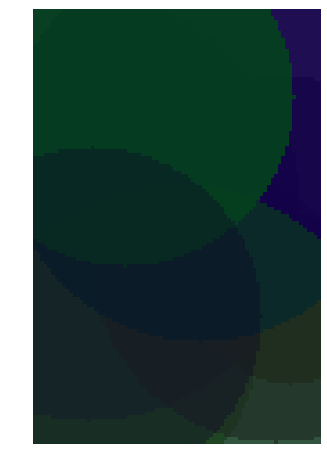

Generation: 44000, score: 1306.33196842, sigma: 0.95693289


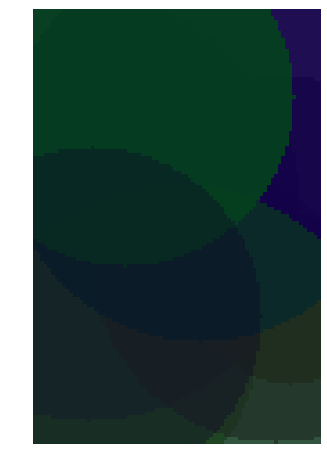

Generation: 45000, score: 1306.33196842, sigma: 0.95597596


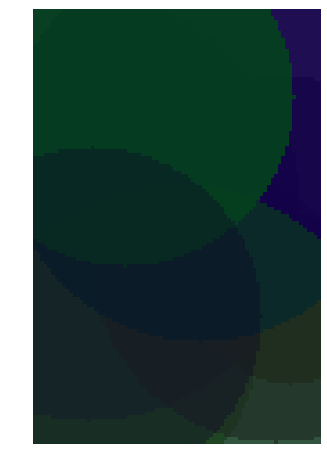

Generation: 46000, score: 1306.33196842, sigma: 0.95501998


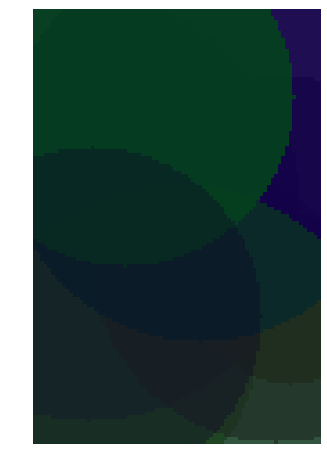

Generation: 47000, score: 1306.33196842, sigma: 0.95406496


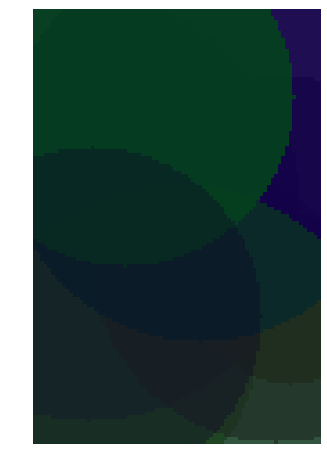

Generation: 48000, score: 1306.33196842, sigma: 0.95311090


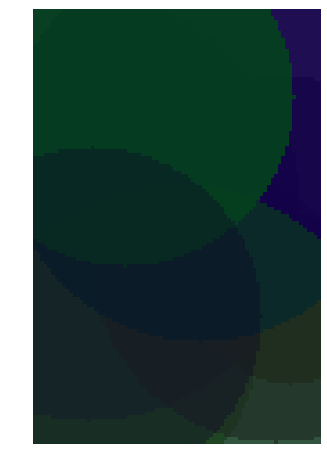

Generation: 49000, score: 1221.59954917, sigma: 0.95215779


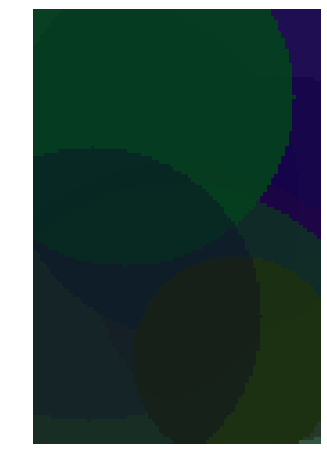

Generation: 50000, score: 1156.99946477, sigma: 0.95120563


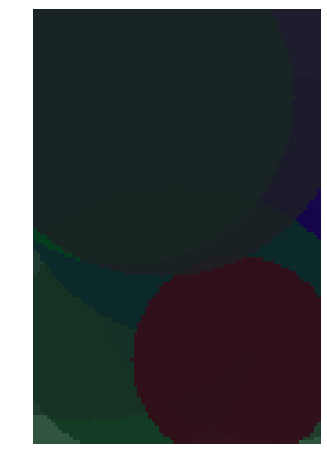

Generation: 51000, score: 926.20468671, sigma: 0.95025442


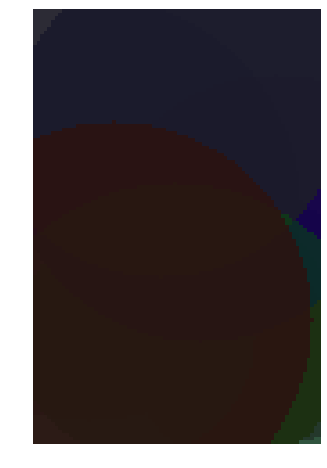

Generation: 52000, score: 918.53287021, sigma: 0.94930417


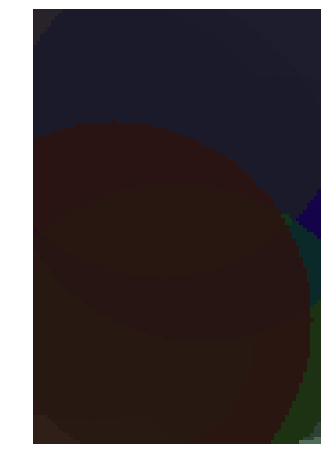

Generation: 53000, score: 918.53287021, sigma: 0.94835486


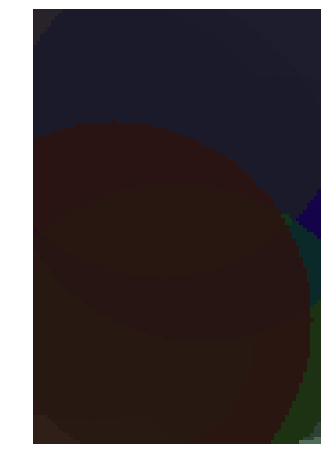

Generation: 54000, score: 918.53287021, sigma: 0.94740651


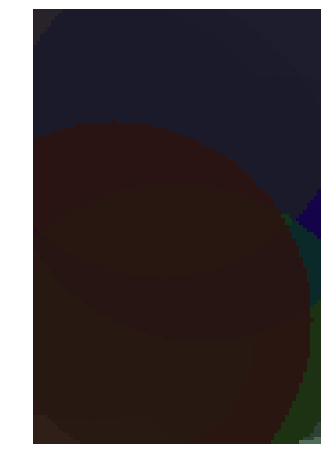

Generation: 55000, score: 918.53287021, sigma: 0.94645910


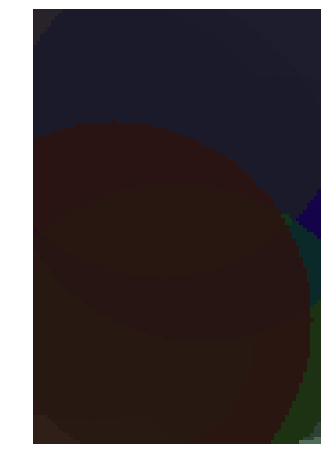

Generation: 56000, score: 918.53287021, sigma: 0.94551264


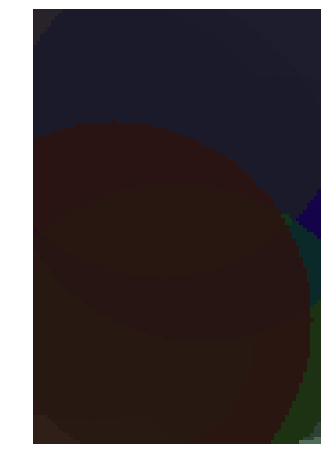

Generation: 57000, score: 918.53287021, sigma: 0.94456713


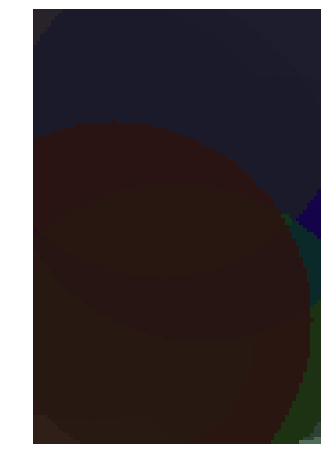

Generation: 58000, score: 918.53287021, sigma: 0.94362256


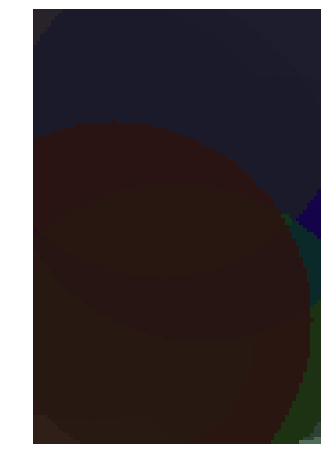

Generation: 59000, score: 918.53287021, sigma: 0.94267894


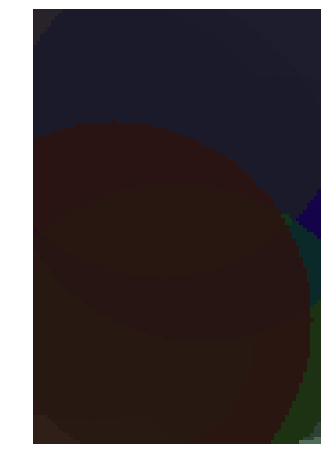

Generation: 60000, score: 918.53287021, sigma: 0.94173626


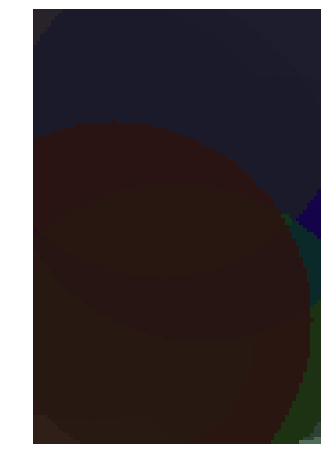

Generation: 61000, score: 918.53287021, sigma: 0.94079453


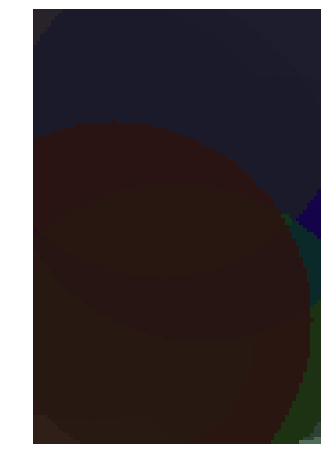

Generation: 62000, score: 918.53287021, sigma: 0.93985373


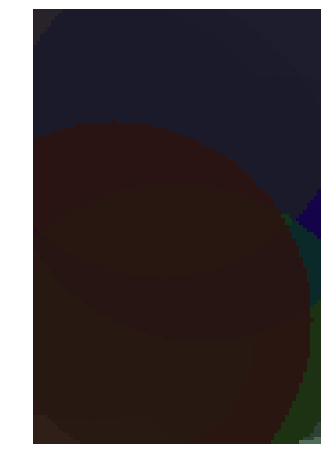

Generation: 63000, score: 918.53287021, sigma: 0.93891388


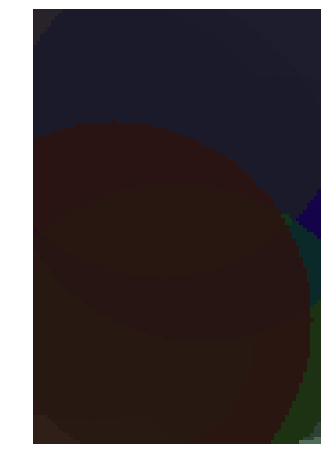

Generation: 64000, score: 918.53287021, sigma: 0.93797496


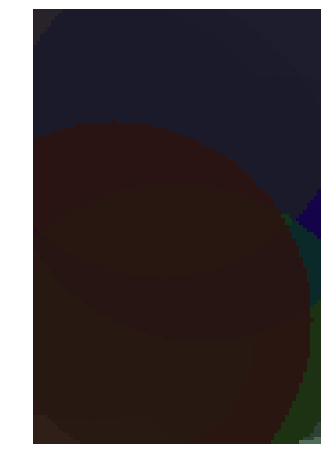

Generation: 65000, score: 918.53287021, sigma: 0.93703699


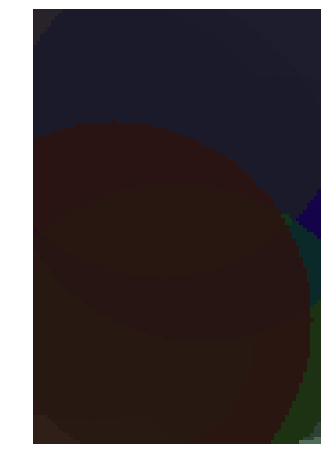

Generation: 66000, score: 913.33661049, sigma: 0.93609995


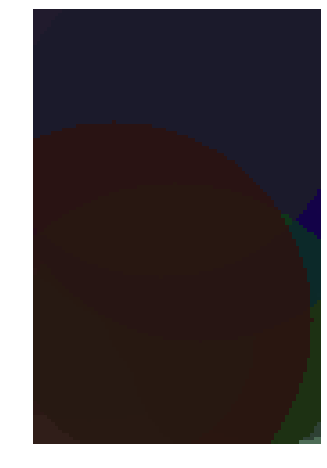

Generation: 67000, score: 913.21545563, sigma: 0.93516385


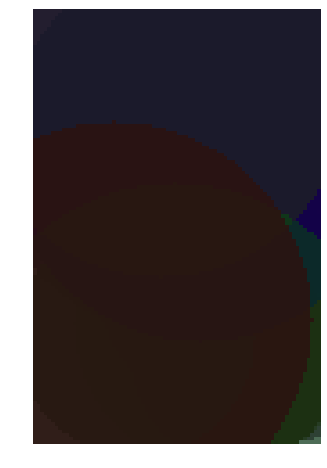

Generation: 68000, score: 907.62715592, sigma: 0.93422869


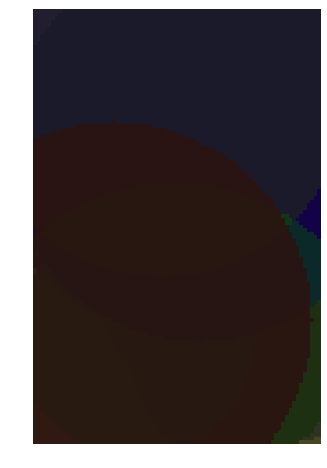

Generation: 69000, score: 903.12675323, sigma: 0.93329446


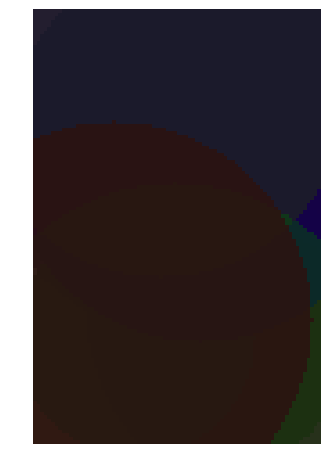

Generation: 70000, score: 902.60309985, sigma: 0.93236116


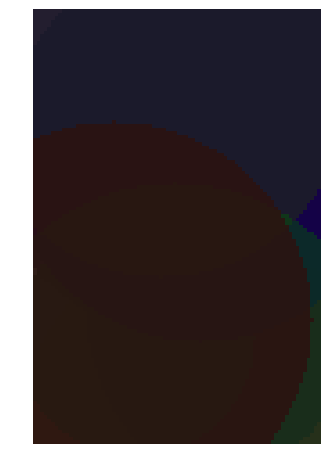

Generation: 71000, score: 902.60309985, sigma: 0.93142880


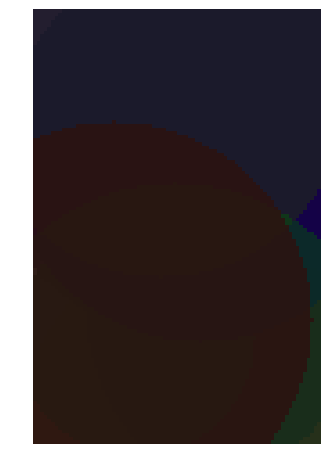

Generation: 72000, score: 902.60309985, sigma: 0.93049737


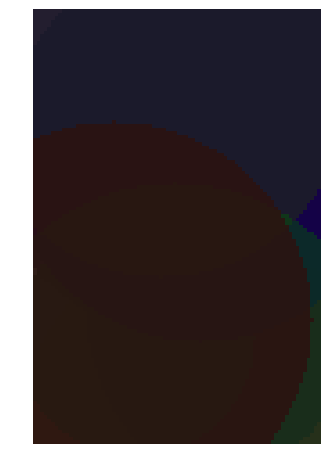

Generation: 73000, score: 902.60309985, sigma: 0.92956688


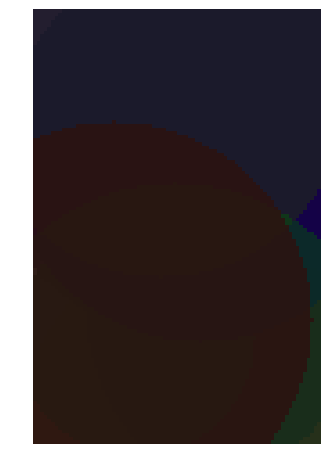

Generation: 74000, score: 902.60309985, sigma: 0.92863731


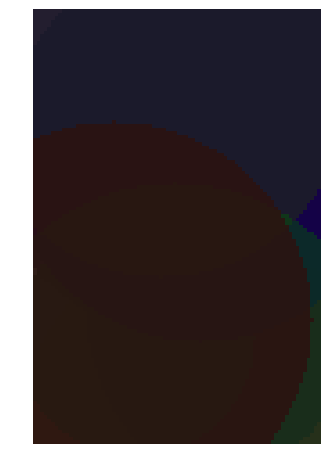

Generation: 75000, score: 902.60309985, sigma: 0.92770867


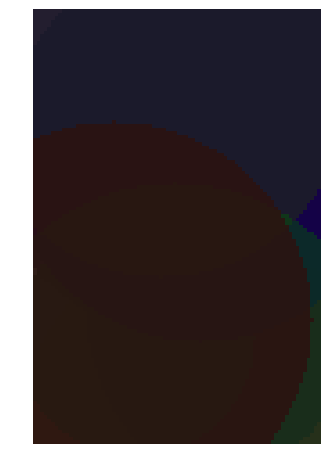

Generation: 76000, score: 902.60309985, sigma: 0.92678096


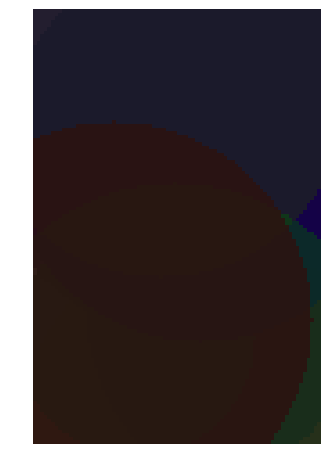

Generation: 77000, score: 902.60309985, sigma: 0.92585418


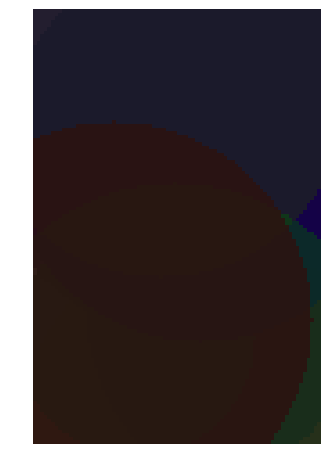

Generation: 78000, score: 902.60309985, sigma: 0.92492833


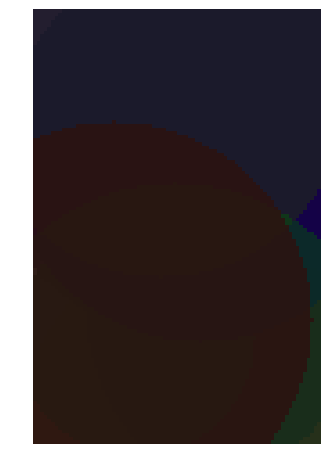

Generation: 79000, score: 902.60309985, sigma: 0.92400340


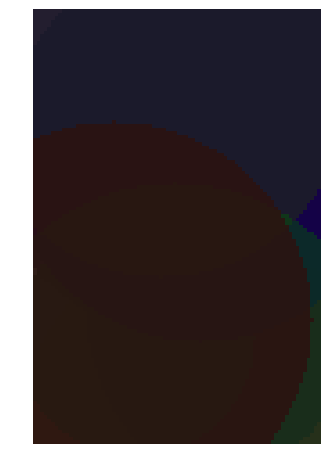

Generation: 80000, score: 902.60309985, sigma: 0.92307940


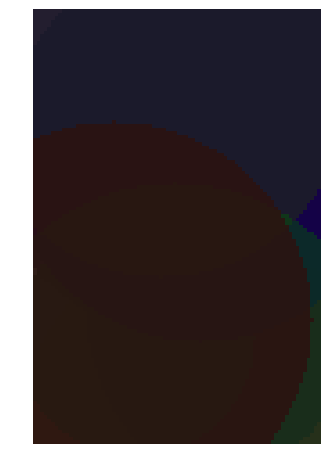

Generation: 81000, score: 902.60309985, sigma: 0.92215632


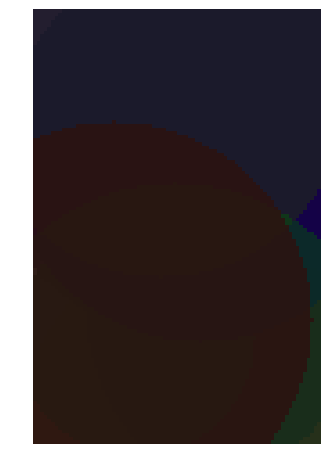

Generation: 82000, score: 902.60309985, sigma: 0.92123416


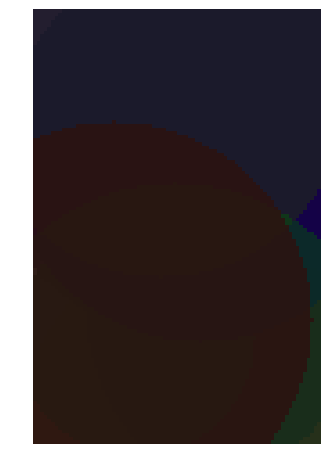

Generation: 83000, score: 902.60309985, sigma: 0.92031293


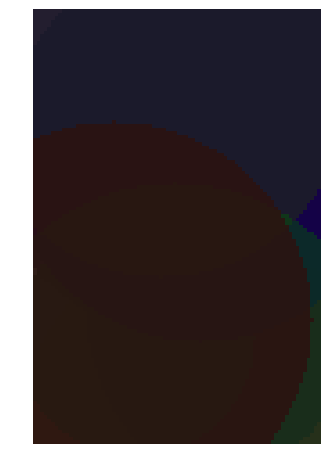

Generation: 84000, score: 902.60309985, sigma: 0.91939262


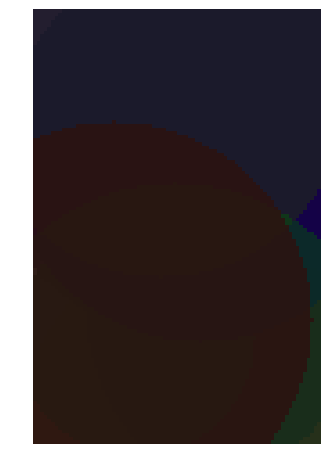

Generation: 85000, score: 902.60309985, sigma: 0.91847322


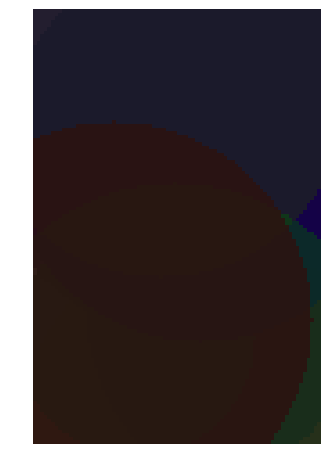

Generation: 86000, score: 902.60309985, sigma: 0.91755475


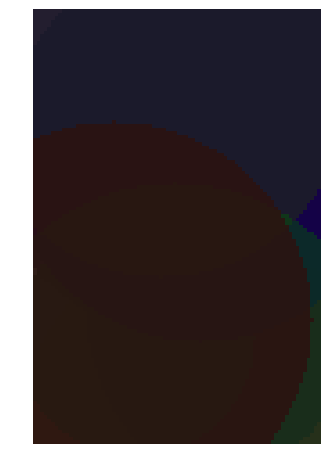

Generation: 87000, score: 902.60309985, sigma: 0.91663719


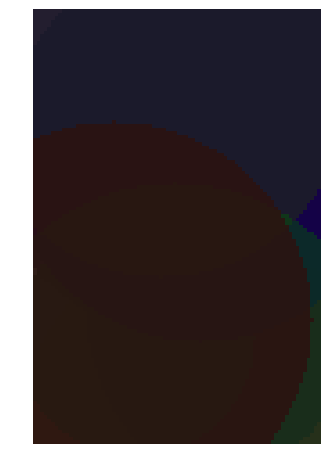

Generation: 88000, score: 902.60309985, sigma: 0.91572056


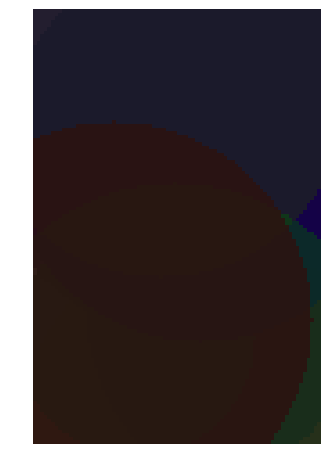

Generation: 89000, score: 902.60309985, sigma: 0.91480484


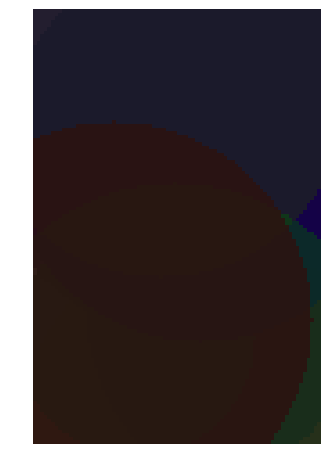

Generation: 90000, score: 902.60309985, sigma: 0.91389003


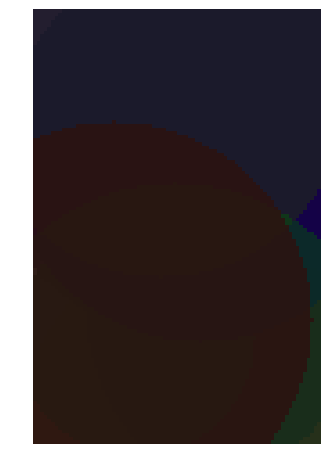

Generation: 91000, score: 902.60309985, sigma: 0.91297614


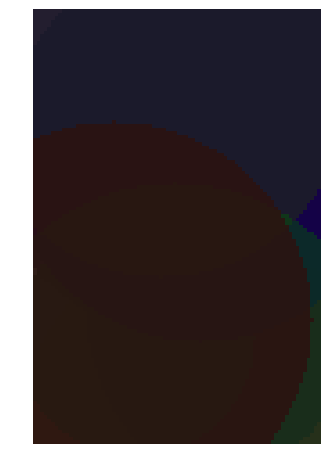

Generation: 92000, score: 902.60309985, sigma: 0.91206317


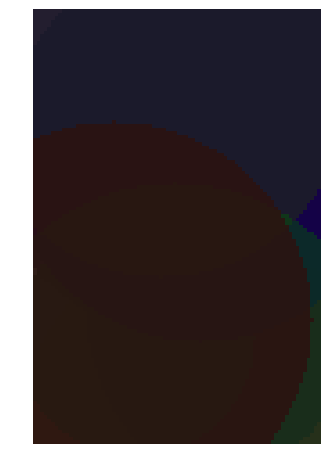

Generation: 93000, score: 902.60309985, sigma: 0.91115110


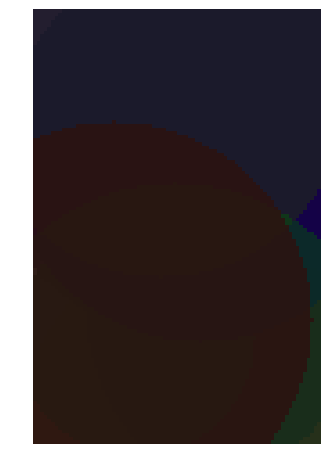

Generation: 94000, score: 902.60309985, sigma: 0.91023995


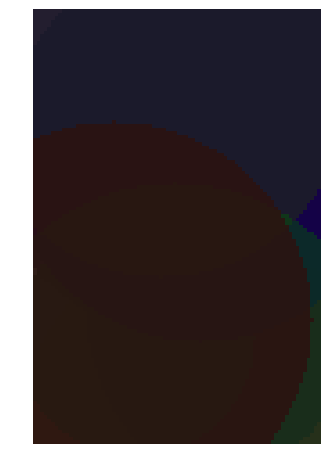

Generation: 95000, score: 888.65974484, sigma: 0.90932971


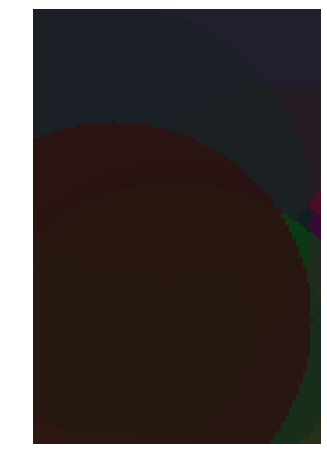

Generation: 96000, score: 710.60361820, sigma: 0.90842038


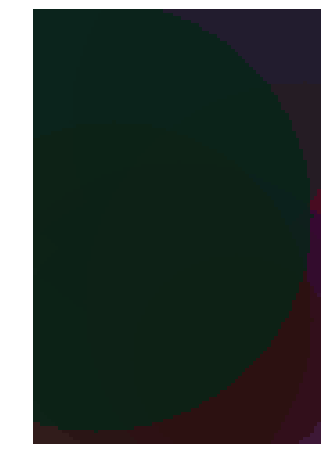

Generation: 97000, score: 708.41158612, sigma: 0.90751196


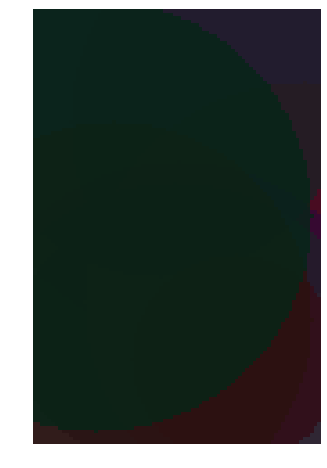

Generation: 98000, score: 708.41158612, sigma: 0.90660445


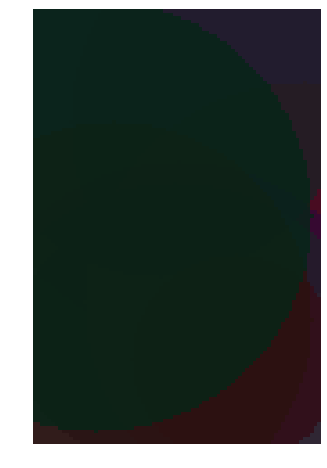

Generation: 99000, score: 706.81398929, sigma: 0.90569784


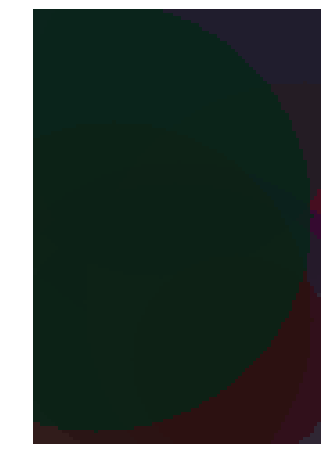

In [165]:
evolution = Evolution(target=rescaled_mona_lisa, chromosome_length=10)
evolution.evolve(filename='results/mona01_best_chromosome10.txt')

Generation: 0, score: 20694.03252141, sigma: 1.00000000


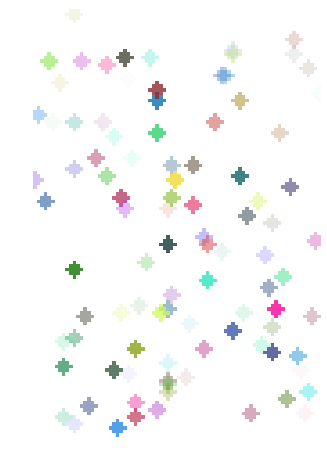

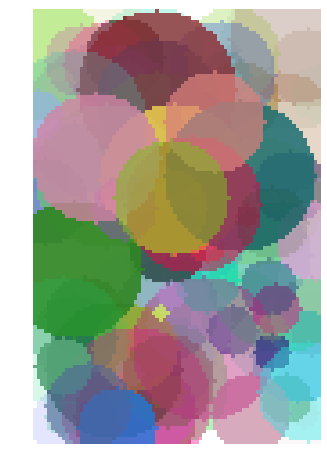

Generation: 1000, score: 11513.12926450, sigma: 0.99900000


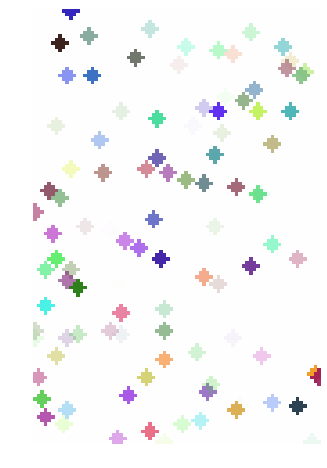

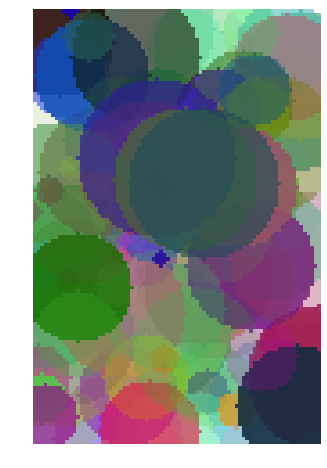

Generation: 2000, score: 8980.00812551, sigma: 0.99800100


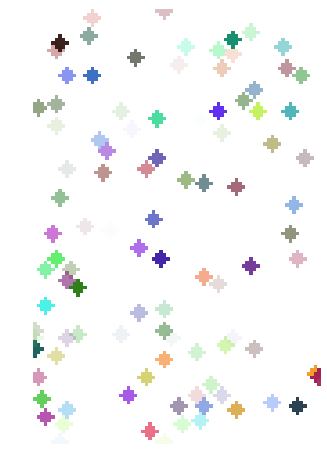

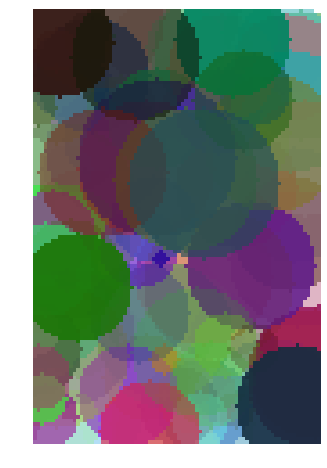

Generation: 3000, score: 7359.16671272, sigma: 0.99700300


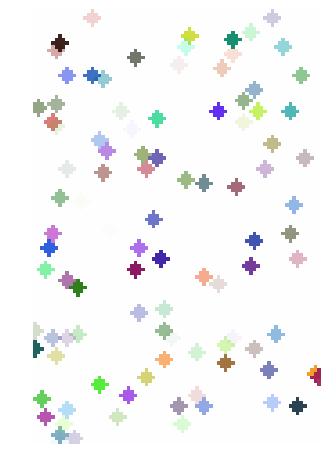

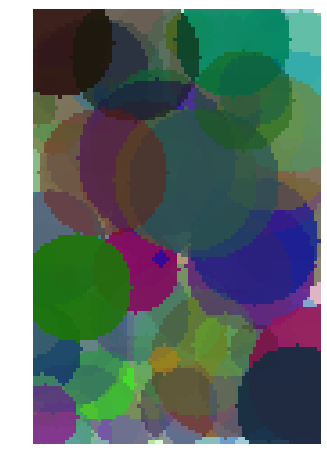

Generation: 4000, score: 6304.72456862, sigma: 0.99600600


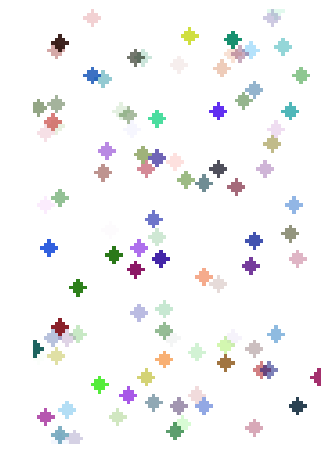

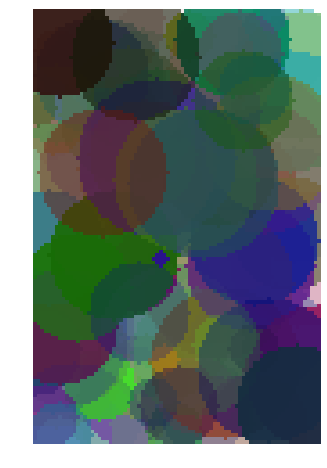

Generation: 5000, score: 5316.24167619, sigma: 0.99500999


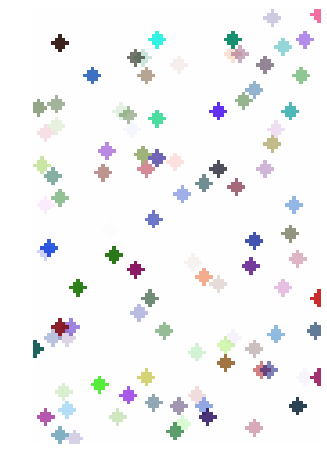

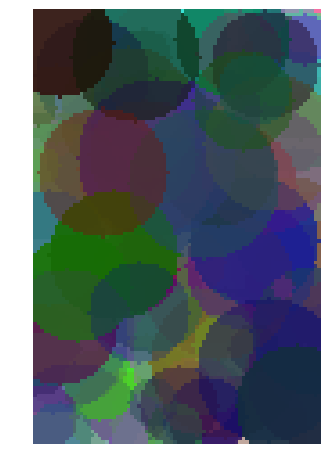

Generation: 6000, score: 4555.70755550, sigma: 0.99401498


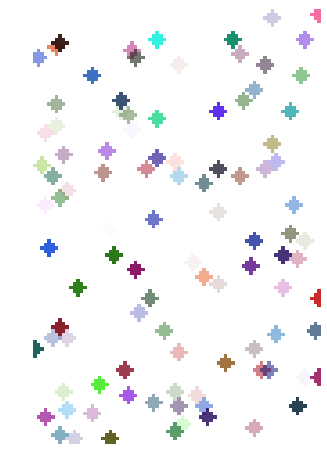

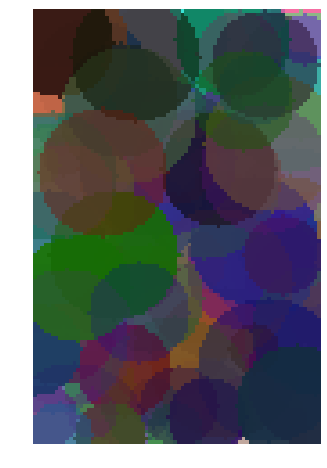

Generation: 7000, score: 4249.69480278, sigma: 0.99302097


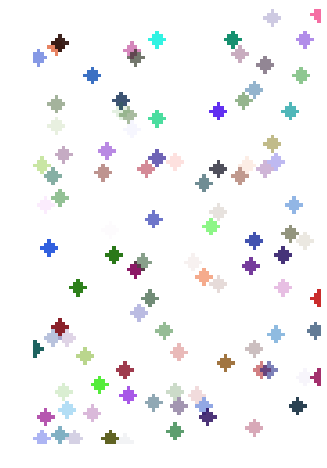

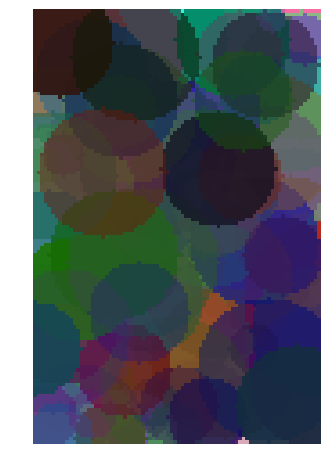

Generation: 8000, score: 3851.77199914, sigma: 0.99202794


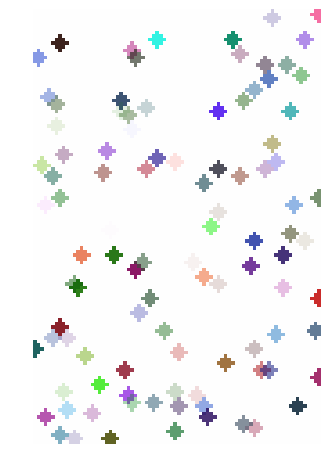

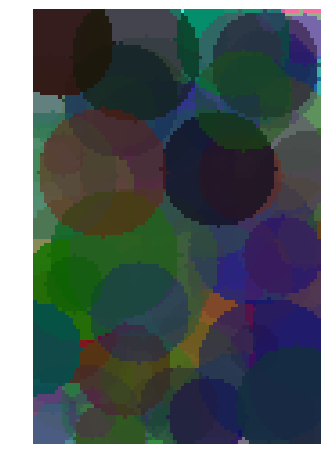

Generation: 9000, score: 3518.80466463, sigma: 0.99103592


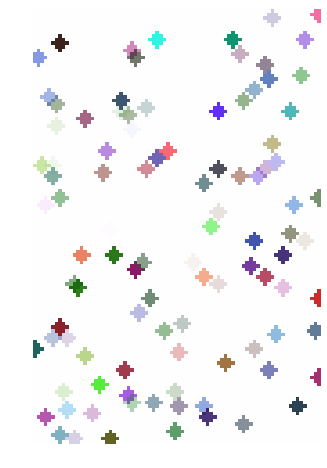

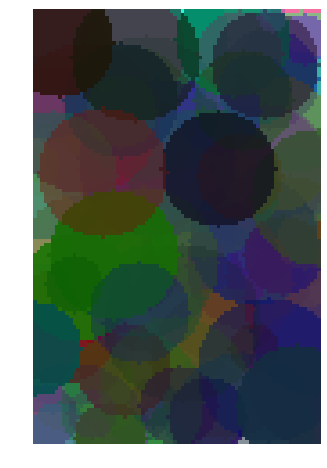

Generation: 10000, score: 3199.84405310, sigma: 0.99004488


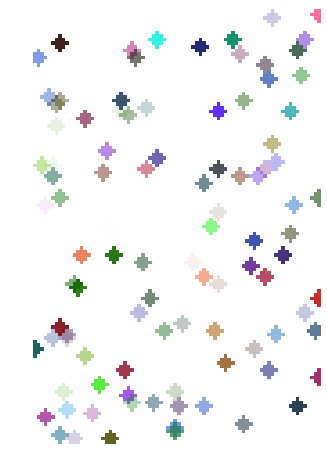

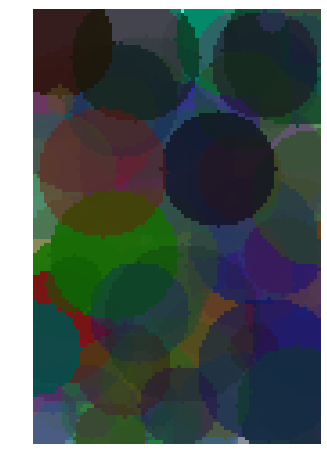

Generation: 11000, score: 3000.92568675, sigma: 0.98905484


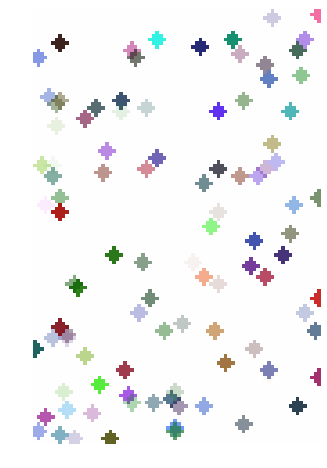

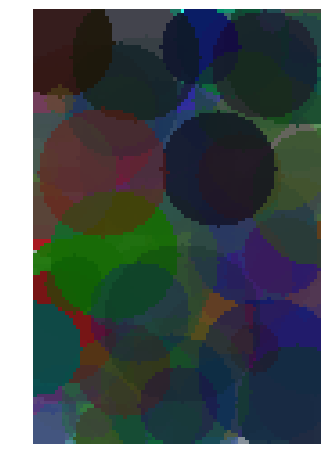

Generation: 12000, score: 2898.72964390, sigma: 0.98806578


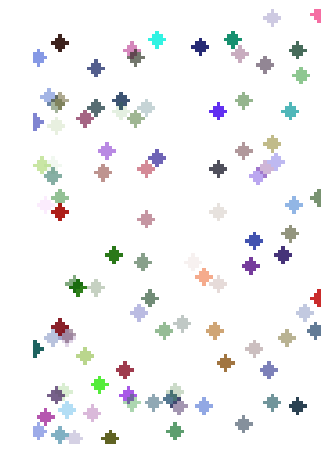

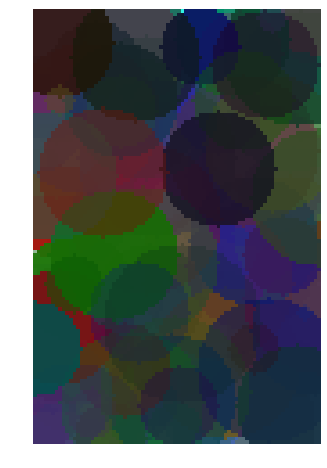

Generation: 13000, score: 2812.06599734, sigma: 0.98707771


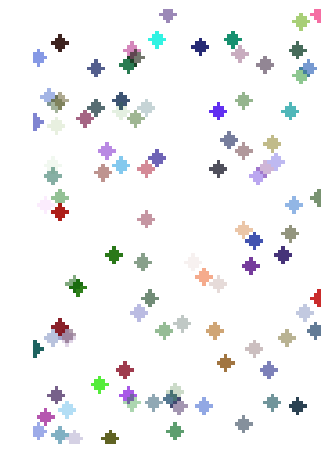

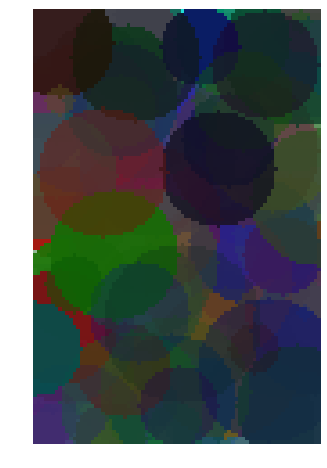

Generation: 14000, score: 2764.71081193, sigma: 0.98609064


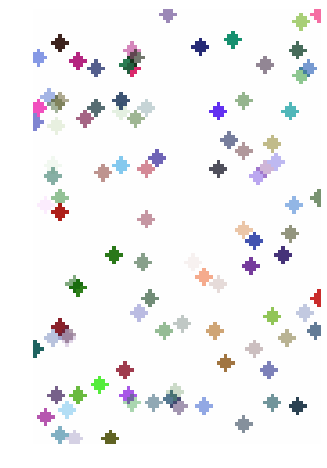

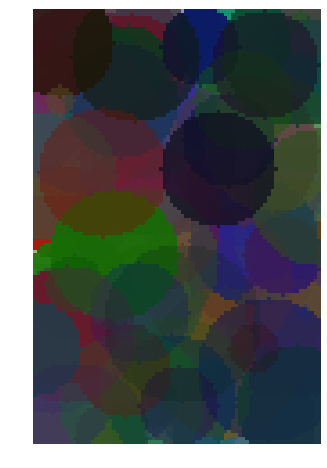

Generation: 15000, score: 2679.31686849, sigma: 0.98510455


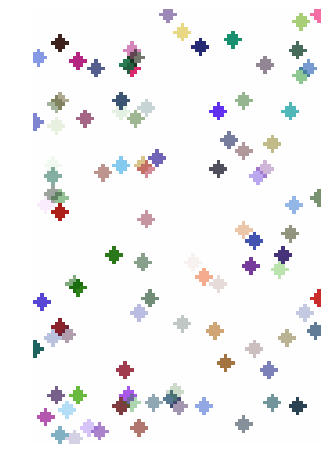

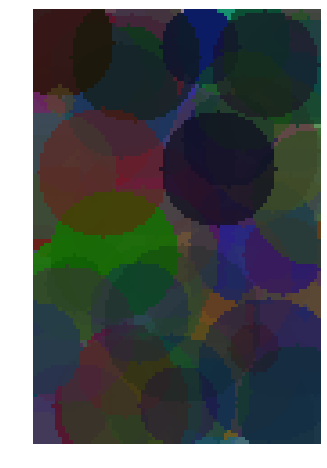

Generation: 16000, score: 2572.16223093, sigma: 0.98411944


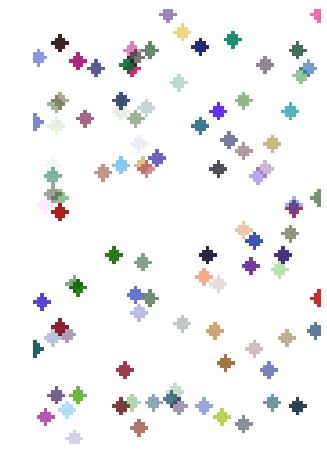

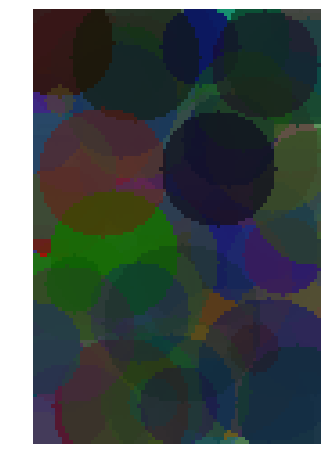

Generation: 17000, score: 2320.83489170, sigma: 0.98313532


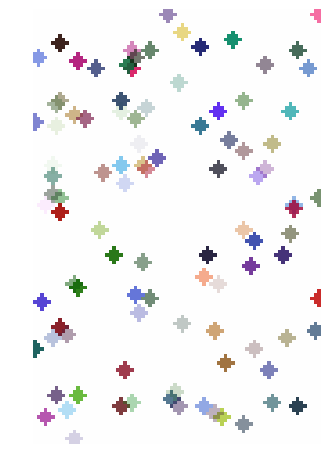

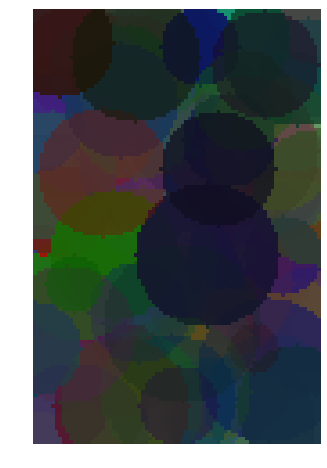

Generation: 18000, score: 2290.40679381, sigma: 0.98215219


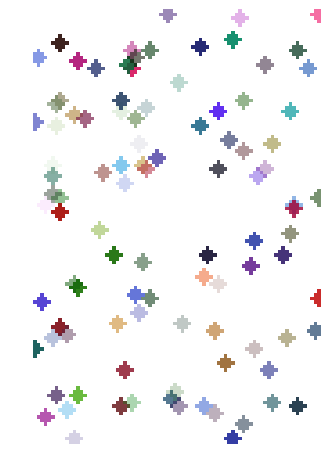

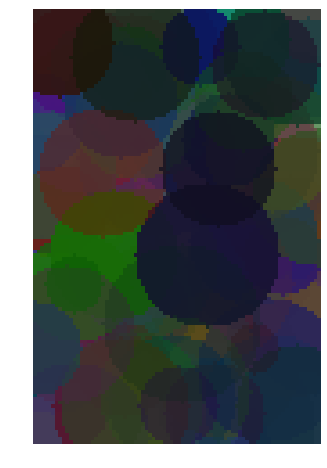

Generation: 19000, score: 2248.18117688, sigma: 0.98117003


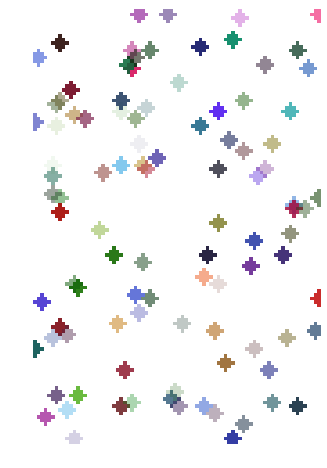

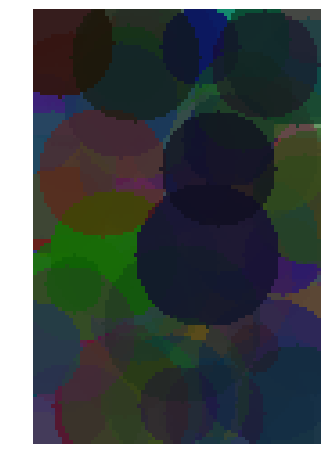

Generation: 20000, score: 2217.97270492, sigma: 0.98018886


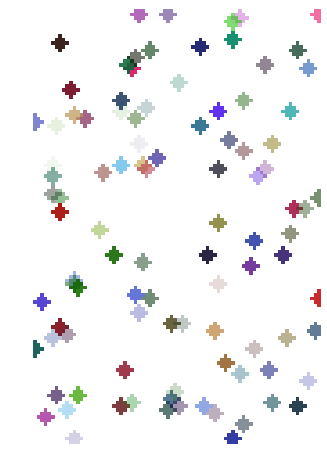

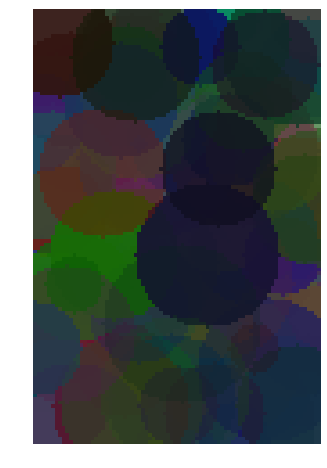

Generation: 21000, score: 2202.80002944, sigma: 0.97920868


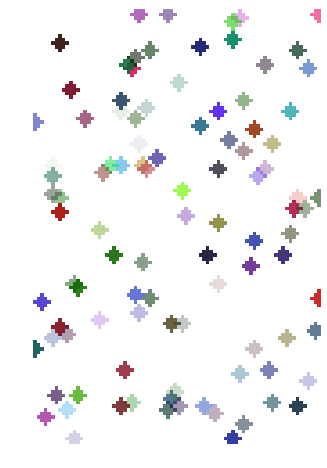

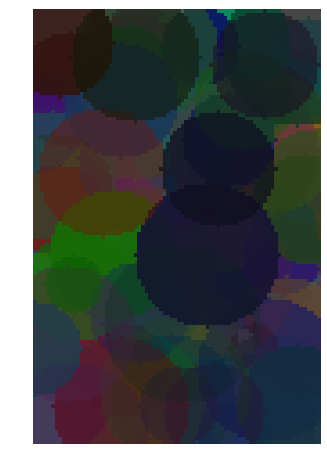

Generation: 22000, score: 2121.47160225, sigma: 0.97822947


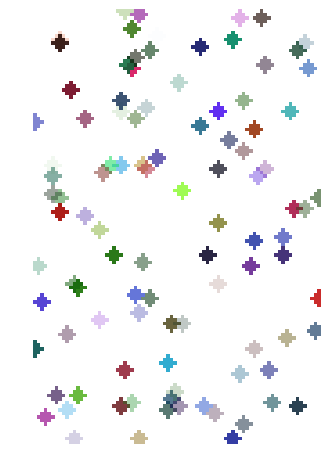

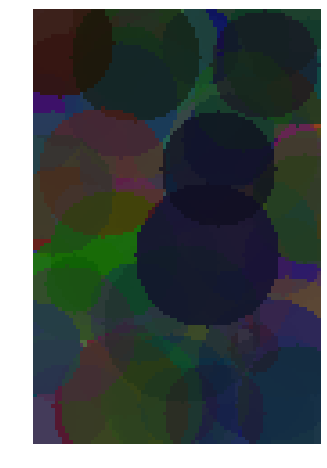

Generation: 23000, score: 2103.34095406, sigma: 0.97725124


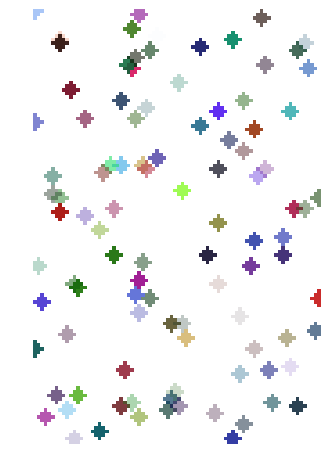

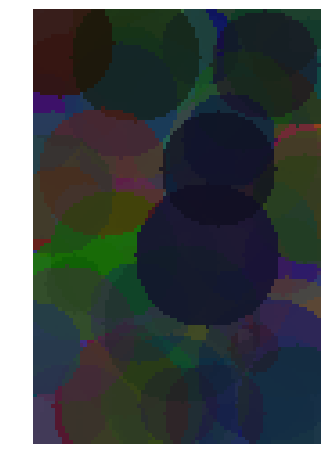

Generation: 24000, score: 2067.17005922, sigma: 0.97627399


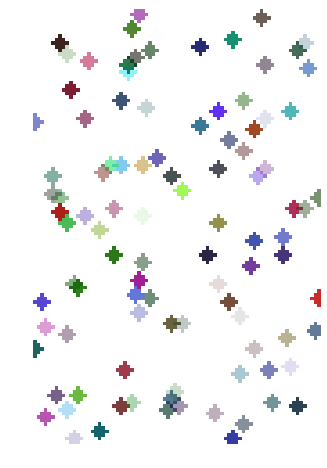

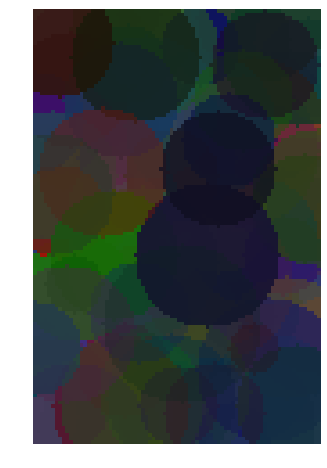

Generation: 25000, score: 1988.57752681, sigma: 0.97529771


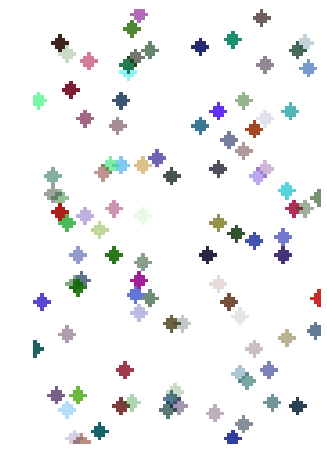

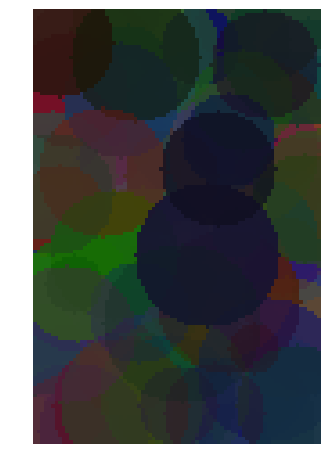

Generation: 26000, score: 1976.66645749, sigma: 0.97432241


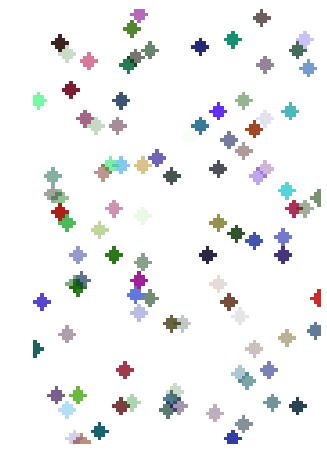

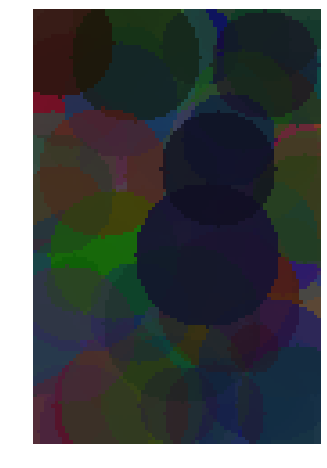

Generation: 27000, score: 1936.75461304, sigma: 0.97334809


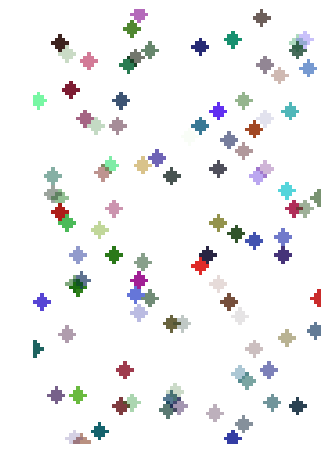

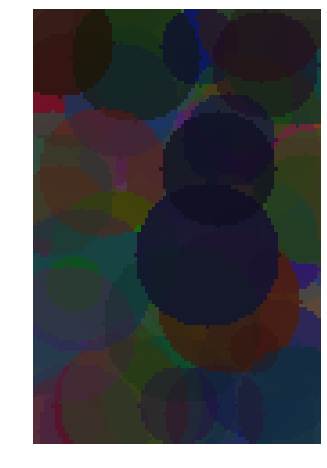

Generation: 28000, score: 1906.57081369, sigma: 0.97237474


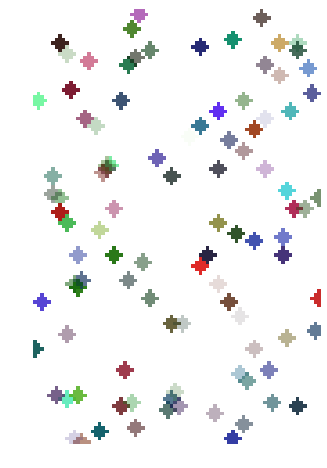

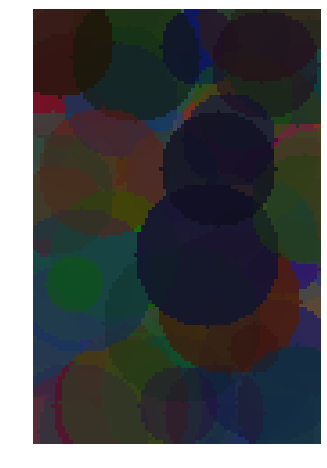

Generation: 29000, score: 1895.65936592, sigma: 0.97140237


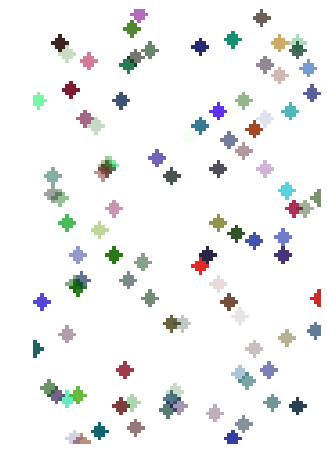

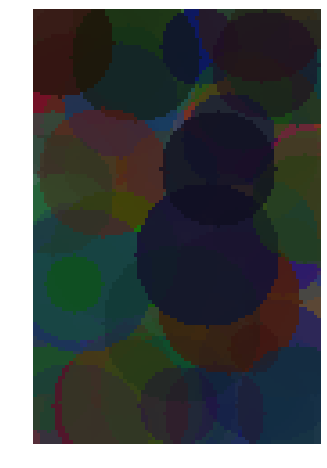

Generation: 30000, score: 1891.93936909, sigma: 0.97043097


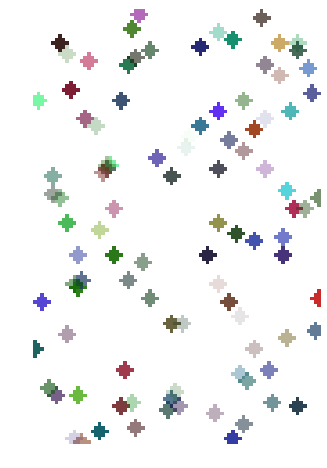

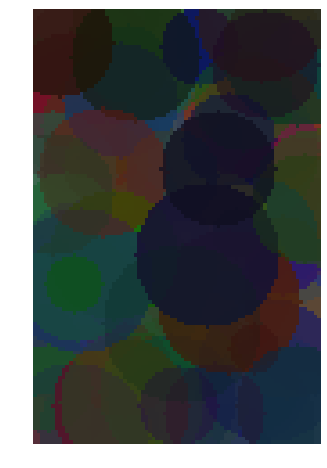

Generation: 31000, score: 1856.61496030, sigma: 0.96946054


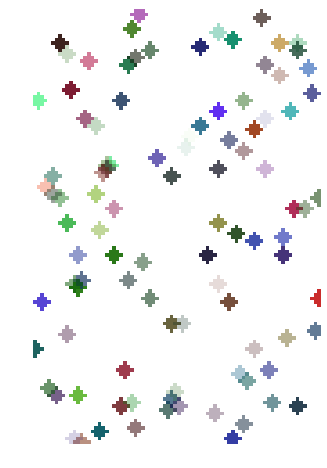

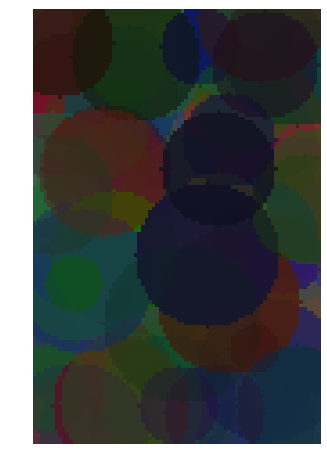

Generation: 32000, score: 1854.62246070, sigma: 0.96849108


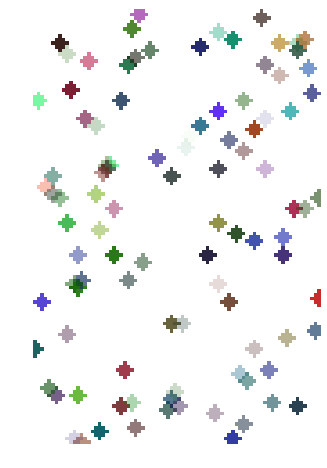

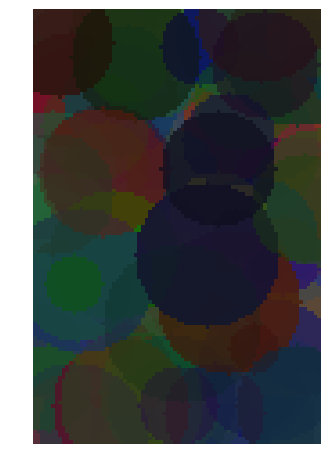

Generation: 33000, score: 1850.44606419, sigma: 0.96752258


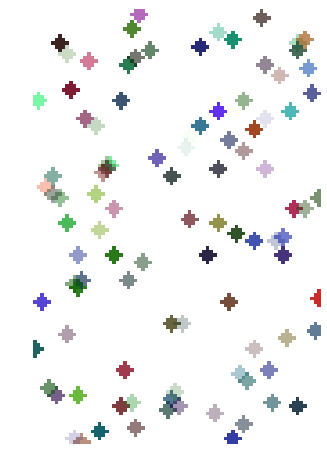

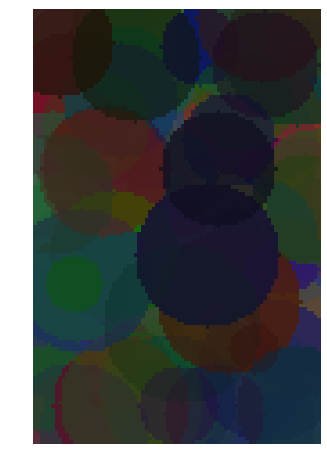

Generation: 34000, score: 1834.40040262, sigma: 0.96655506


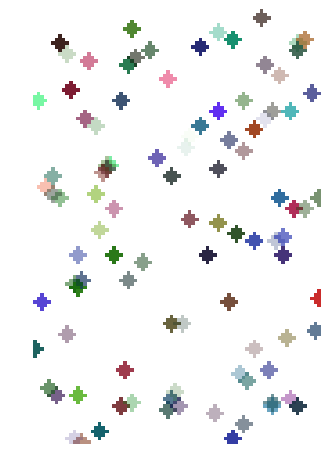

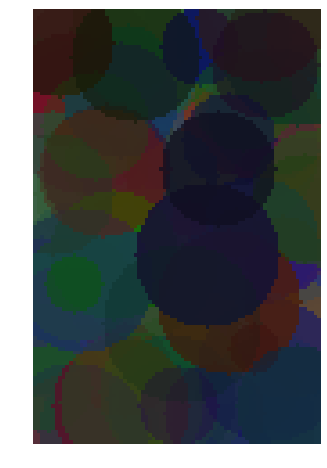

Generation: 35000, score: 1783.69997394, sigma: 0.96558851


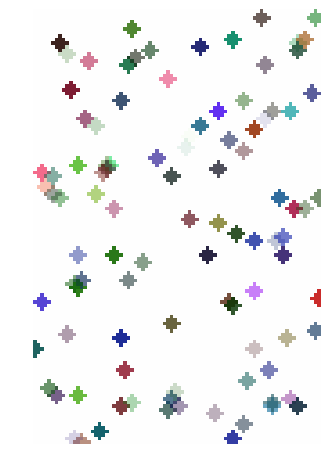

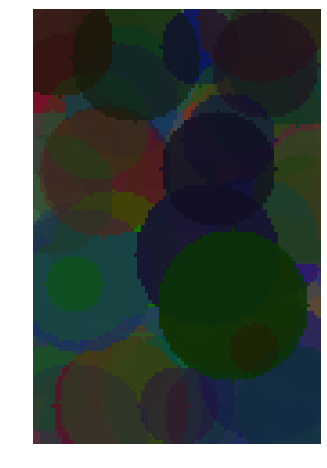

Generation: 36000, score: 1714.32033632, sigma: 0.96462292


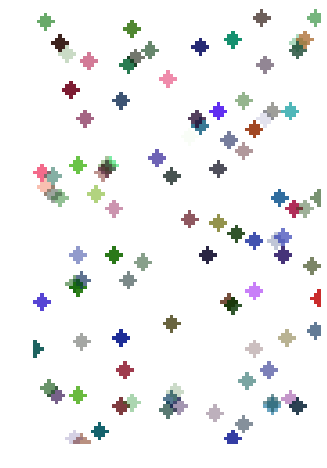

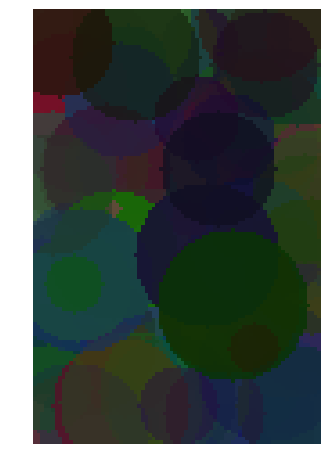

Generation: 37000, score: 1672.51700933, sigma: 0.96365830


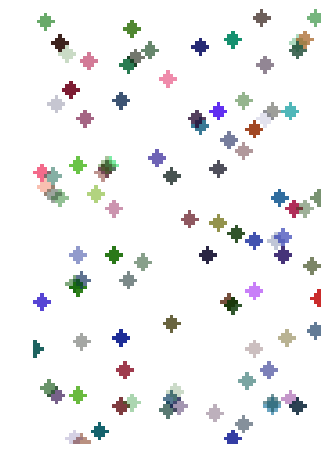

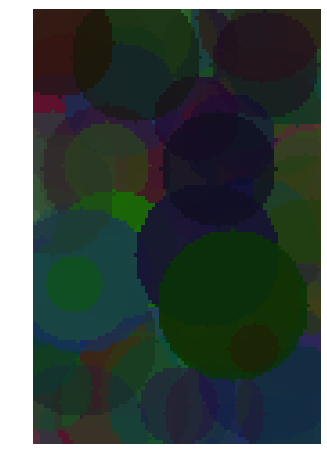

Generation: 38000, score: 1642.71176066, sigma: 0.96269464


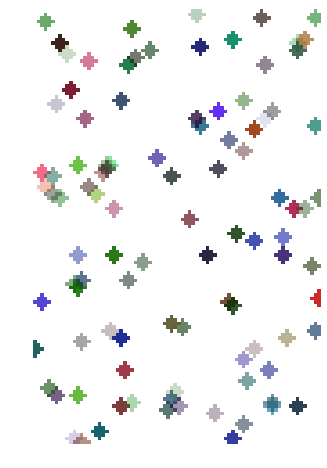

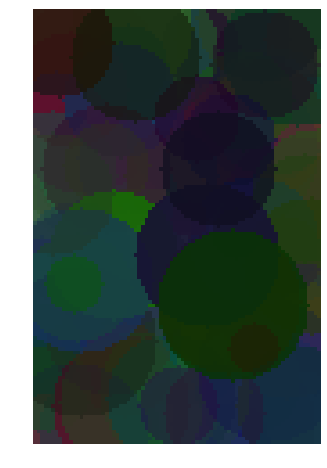

Generation: 39000, score: 1593.33298540, sigma: 0.96173194


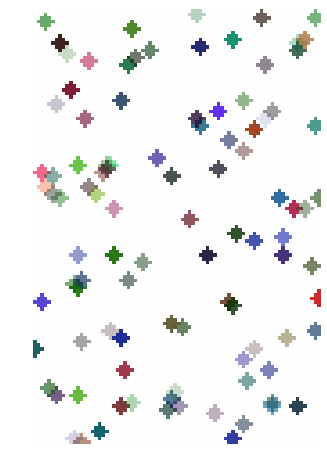

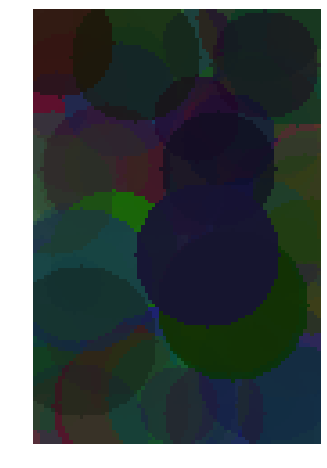

Generation: 40000, score: 1552.84543476, sigma: 0.96077021


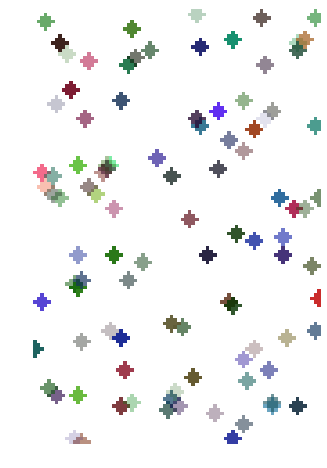

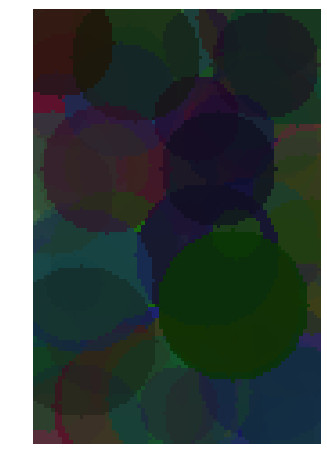

Generation: 41000, score: 1540.84562132, sigma: 0.95980944


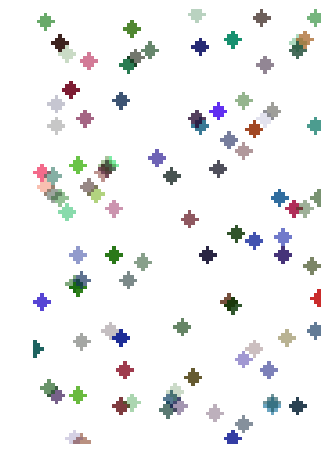

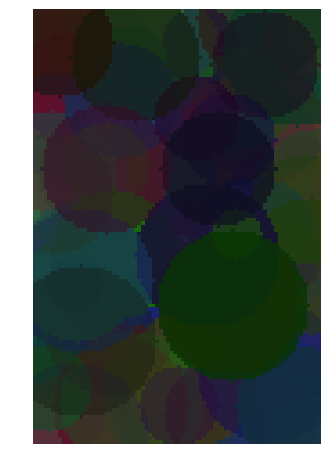

Generation: 42000, score: 1533.59029702, sigma: 0.95884963


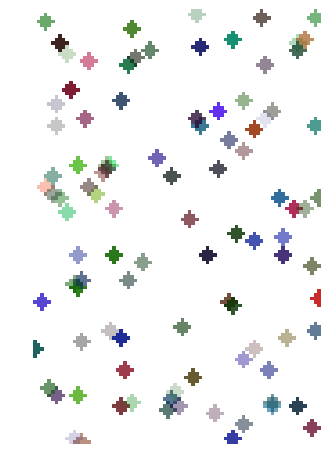

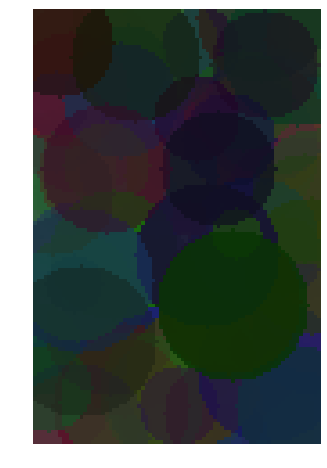

Generation: 43000, score: 1520.23067898, sigma: 0.95789078


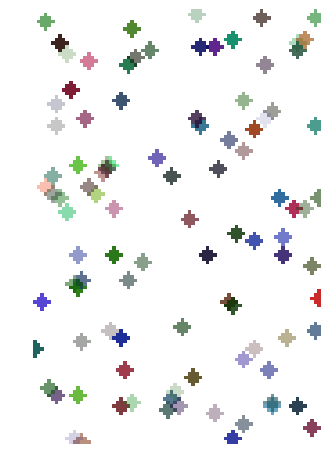

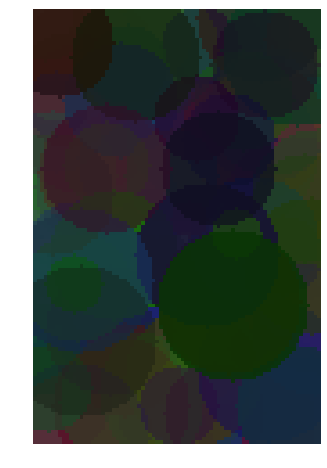

Generation: 44000, score: 1507.45555806, sigma: 0.95693289


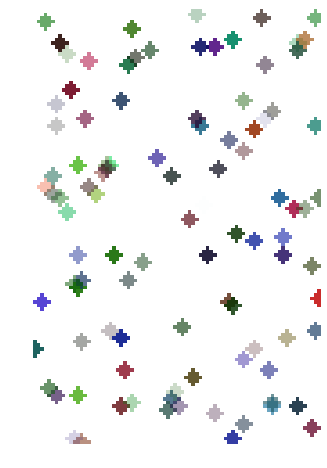

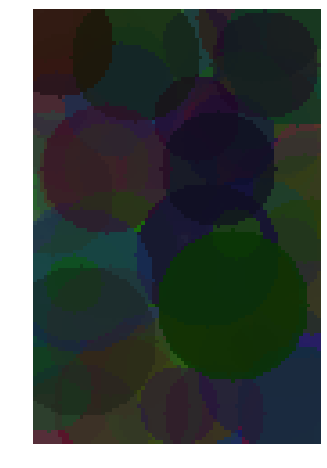

Generation: 45000, score: 1506.12775604, sigma: 0.95597596


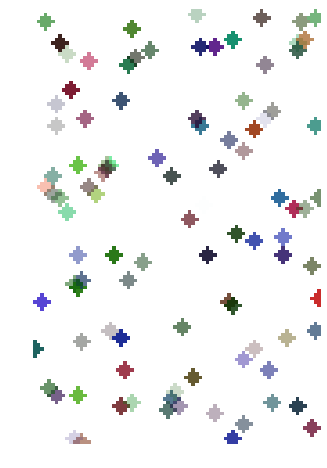

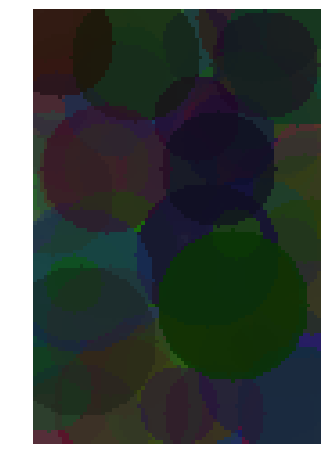

Generation: 46000, score: 1503.13278453, sigma: 0.95501998


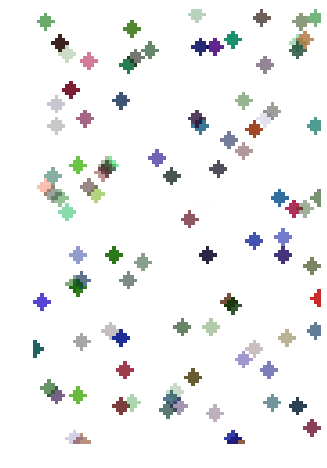

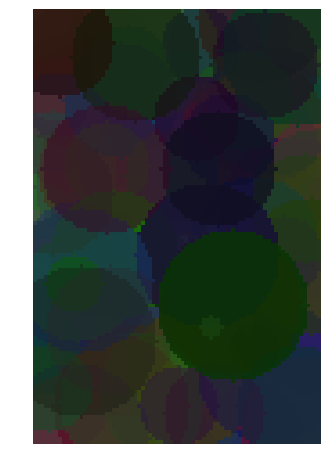

Generation: 47000, score: 1484.03222486, sigma: 0.95406496


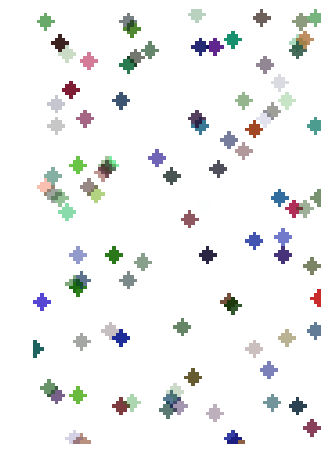

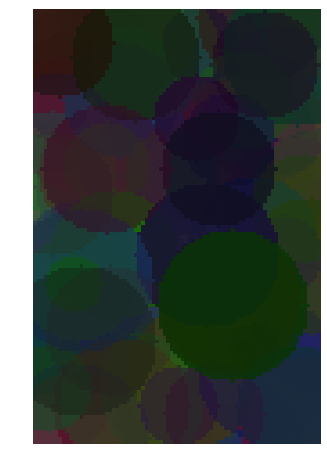

Generation: 48000, score: 1468.90929172, sigma: 0.95311090


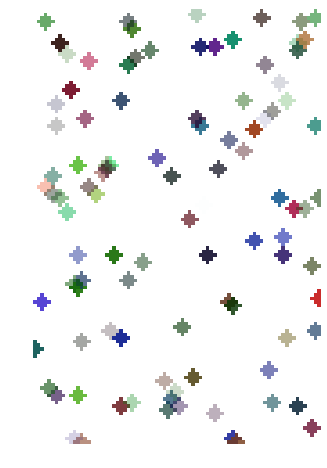

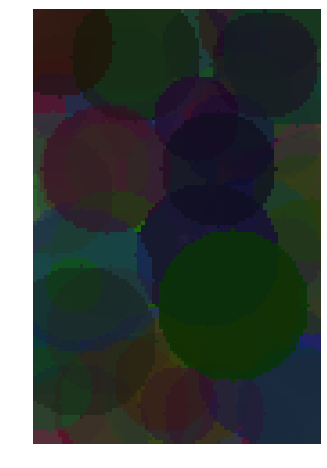

Generation: 49000, score: 1445.06051977, sigma: 0.95215779


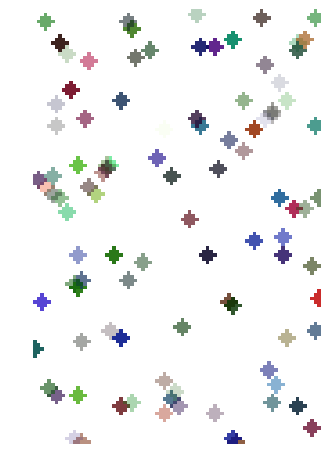

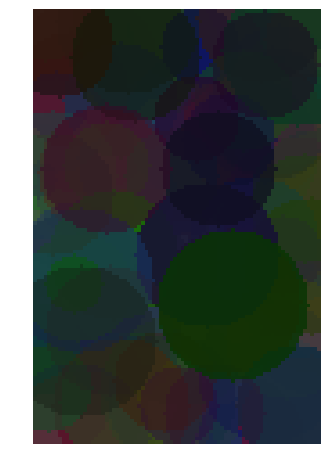

Generation: 50000, score: 1435.04119389, sigma: 0.95120563


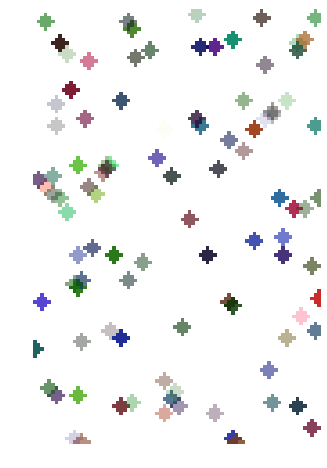

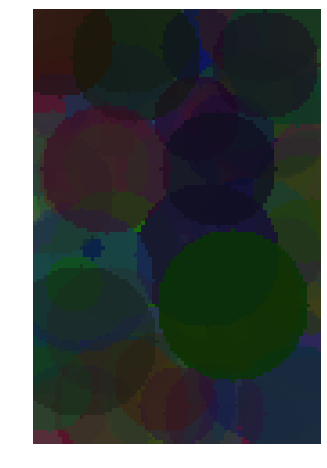

Generation: 51000, score: 1432.43353853, sigma: 0.95025442


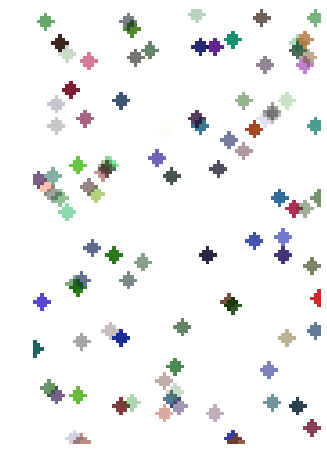

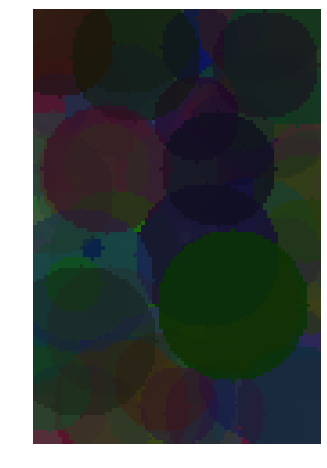

Generation: 52000, score: 1429.13259028, sigma: 0.94930417


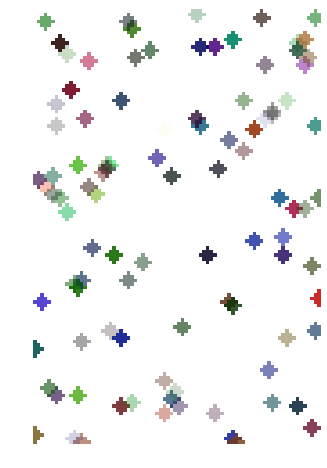

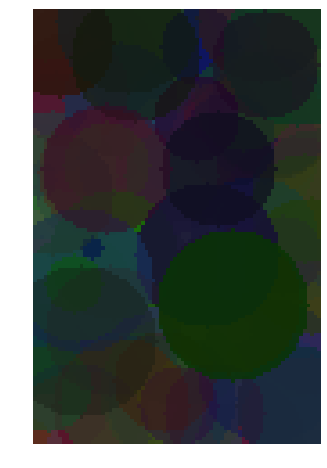

Generation: 53000, score: 1396.72326879, sigma: 0.94835486


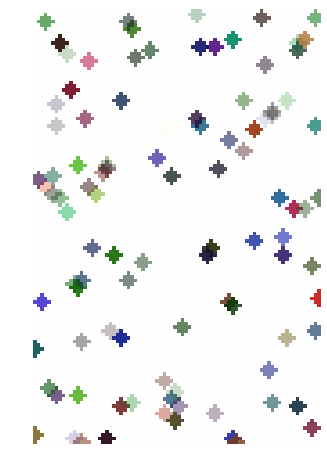

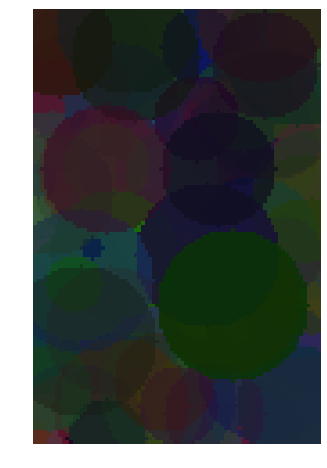

Generation: 54000, score: 1387.65012215, sigma: 0.94740651


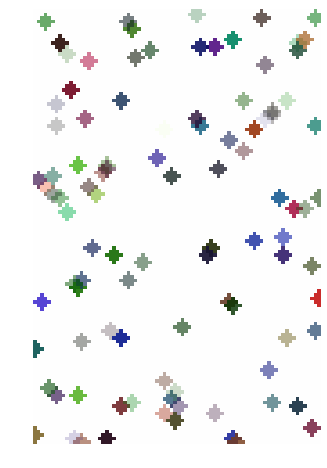

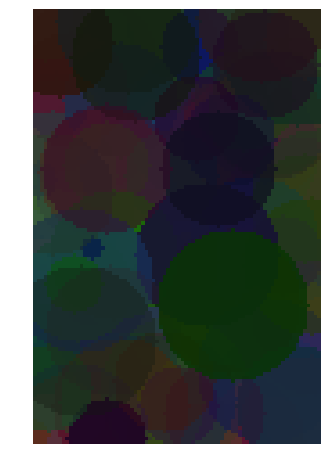

Generation: 55000, score: 1386.83280303, sigma: 0.94645910


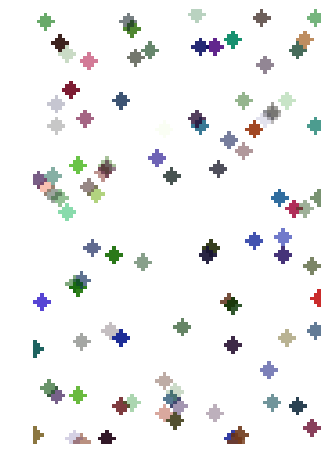

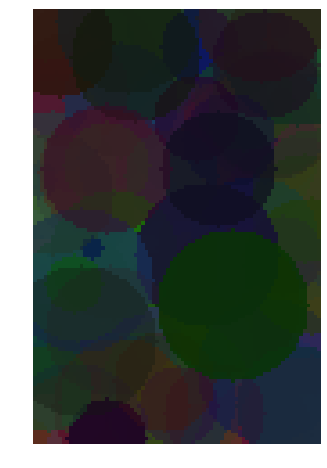

Generation: 56000, score: 1381.20607769, sigma: 0.94551264


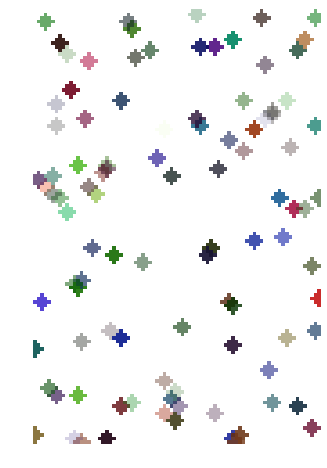

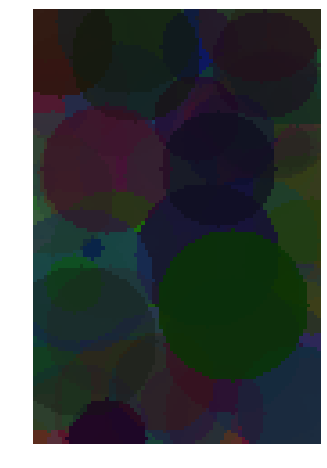

Generation: 57000, score: 1339.39922251, sigma: 0.94456713


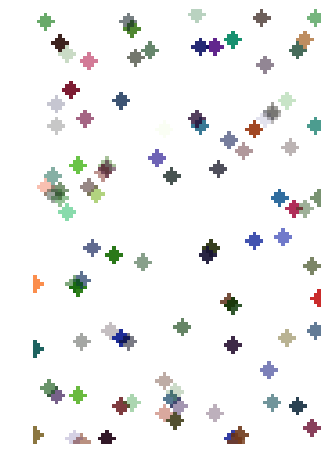

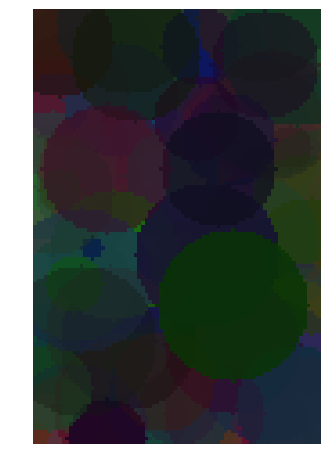

Generation: 58000, score: 1316.73477462, sigma: 0.94362256


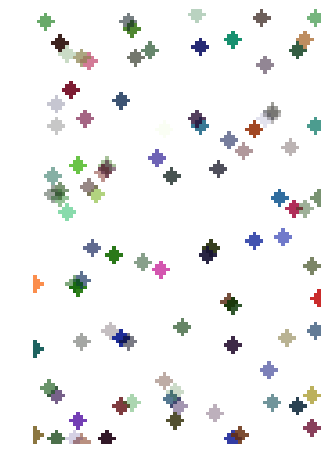

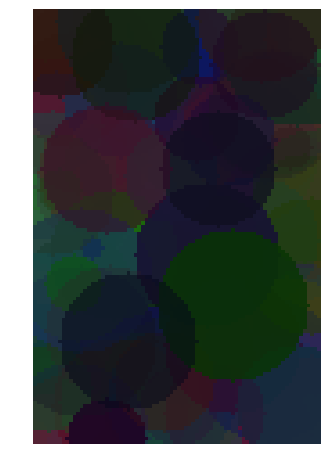

Generation: 59000, score: 1299.07943303, sigma: 0.94267894


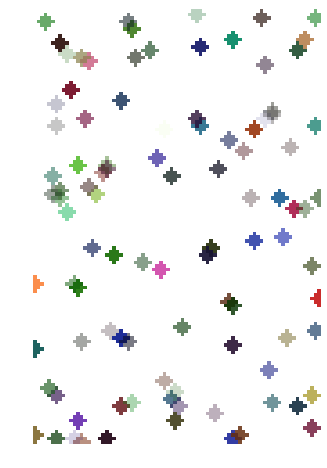

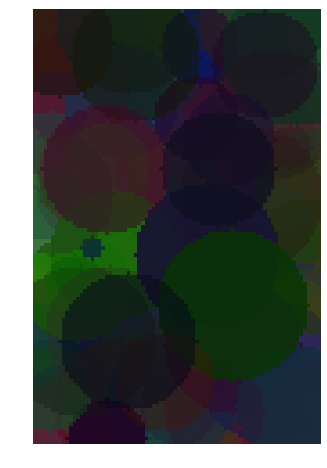

Generation: 60000, score: 1283.26597850, sigma: 0.94173626


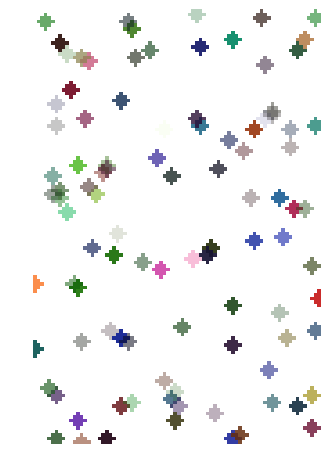

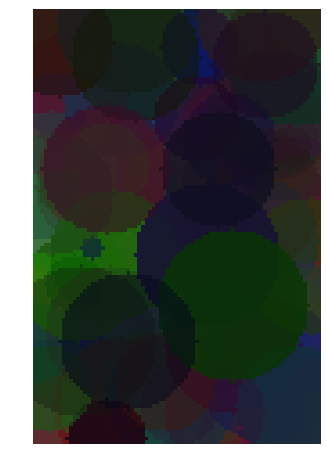

Generation: 61000, score: 1275.29577891, sigma: 0.94079453


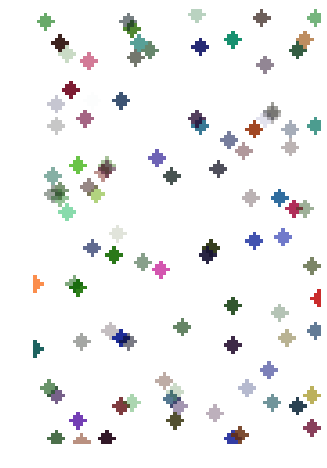

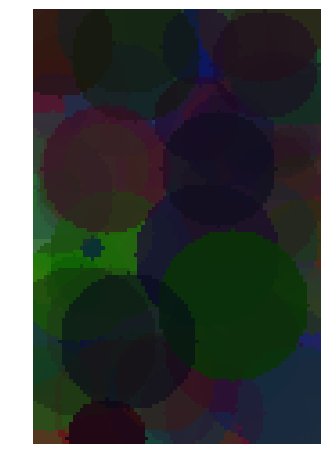

Generation: 62000, score: 1269.02324002, sigma: 0.93985373


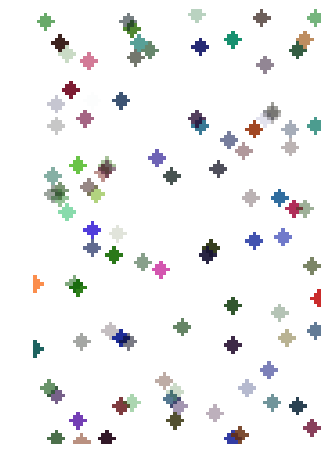

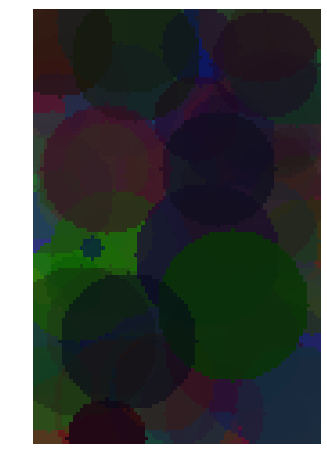

Generation: 63000, score: 1261.60017589, sigma: 0.93891388


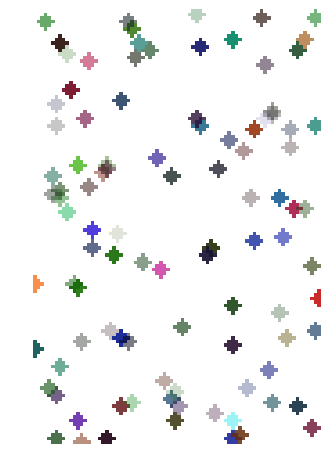

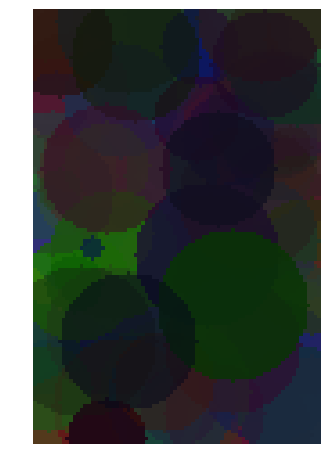

Generation: 64000, score: 1259.41224937, sigma: 0.93797496


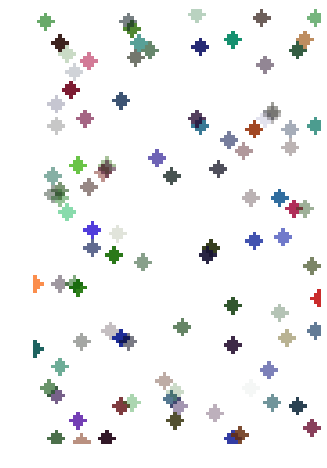

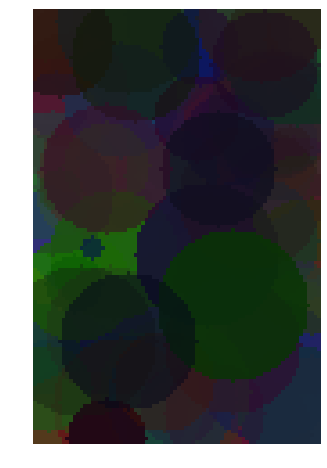

Generation: 65000, score: 1234.22998778, sigma: 0.93703699


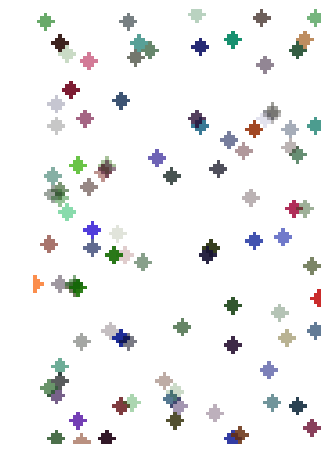

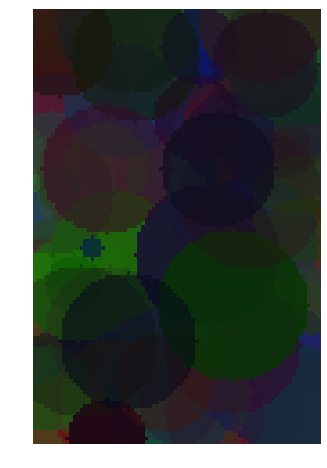

Generation: 66000, score: 1153.17510709, sigma: 0.93609995


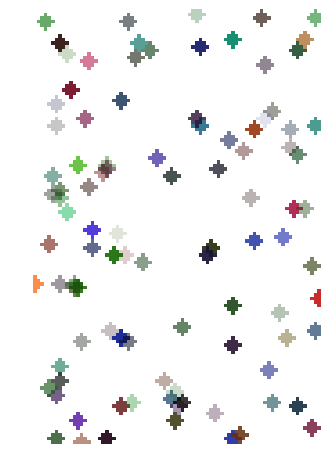

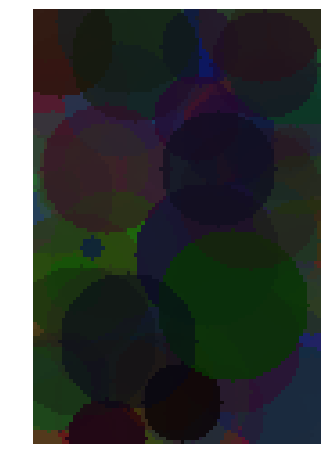

Generation: 67000, score: 1142.99711662, sigma: 0.93516385


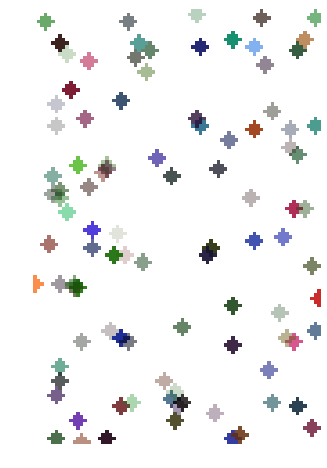

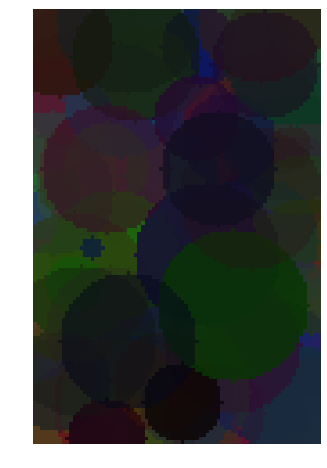

Generation: 68000, score: 1137.09141873, sigma: 0.93422869


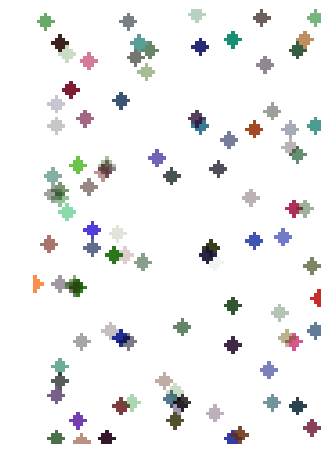

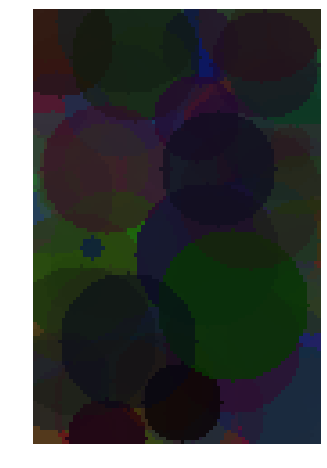

Generation: 69000, score: 1130.45997461, sigma: 0.93329446


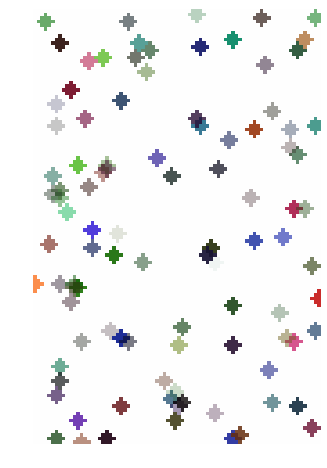

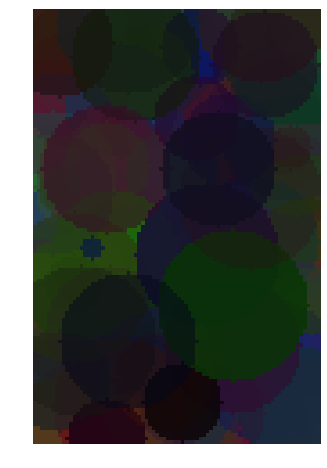

Generation: 70000, score: 1128.30607377, sigma: 0.93236116


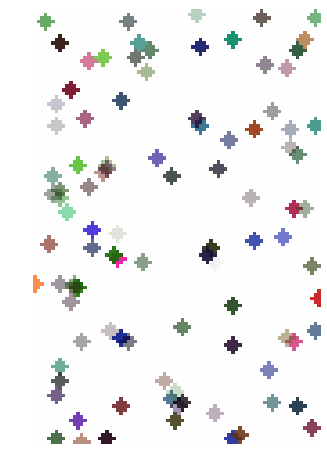

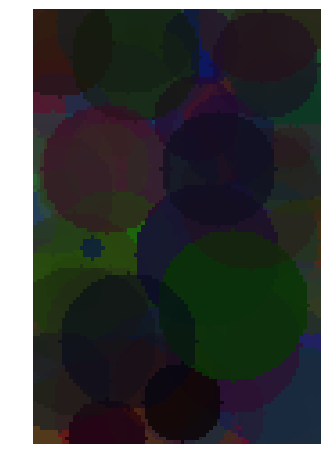

Generation: 71000, score: 1126.94506691, sigma: 0.93142880


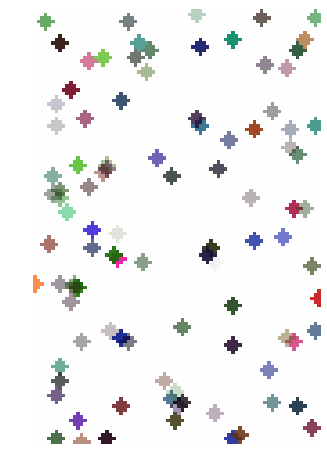

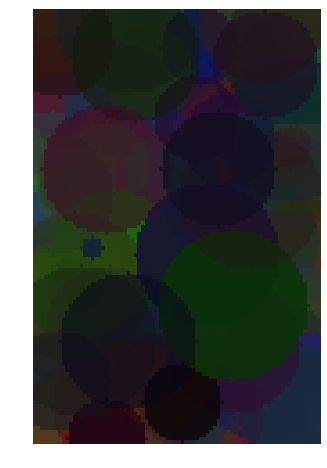

Generation: 72000, score: 1125.38560910, sigma: 0.93049737


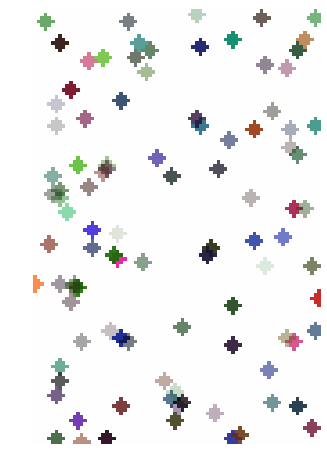

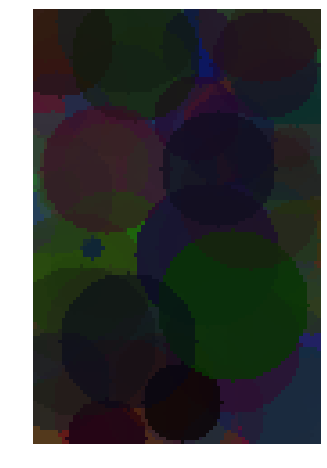

Generation: 73000, score: 1119.33024031, sigma: 0.92956688


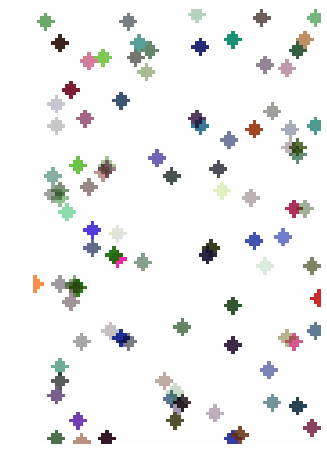

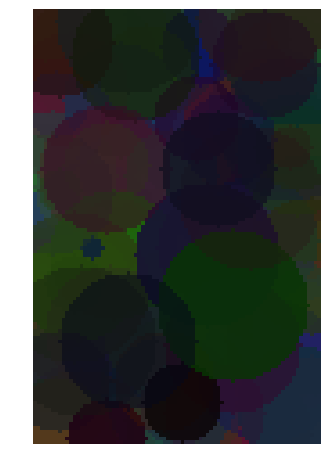

Generation: 74000, score: 1117.04595447, sigma: 0.92863731


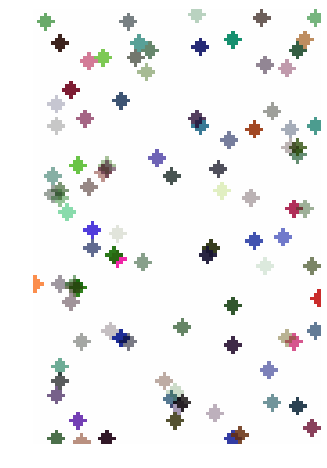

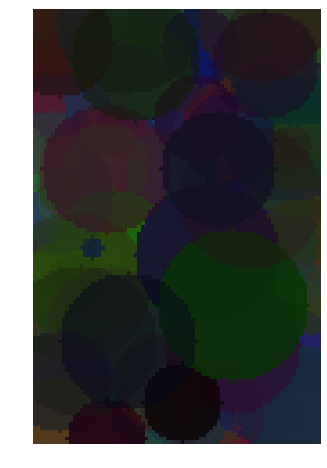

Generation: 75000, score: 1110.99273706, sigma: 0.92770867


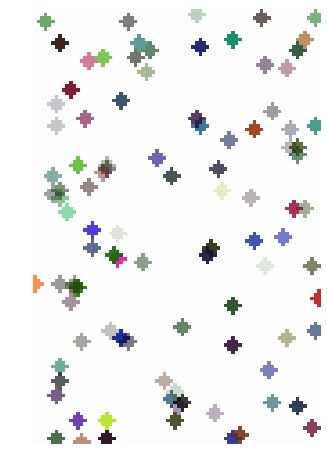

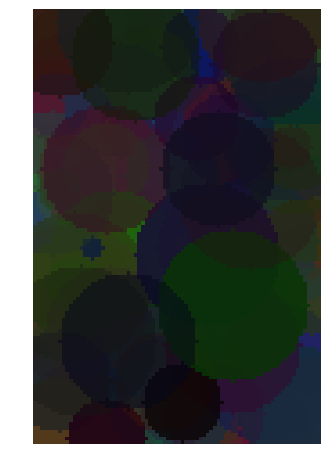

Generation: 76000, score: 1099.27551970, sigma: 0.92678096


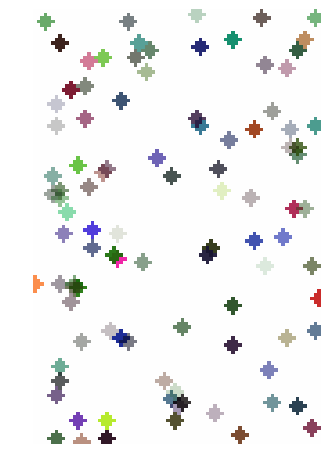

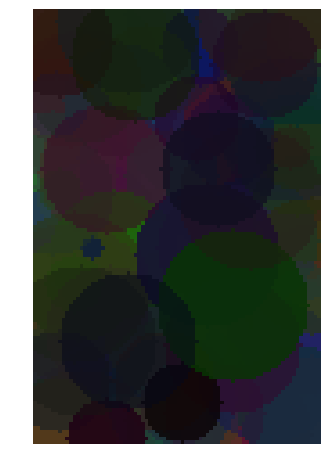

Generation: 77000, score: 1095.59411461, sigma: 0.92585418


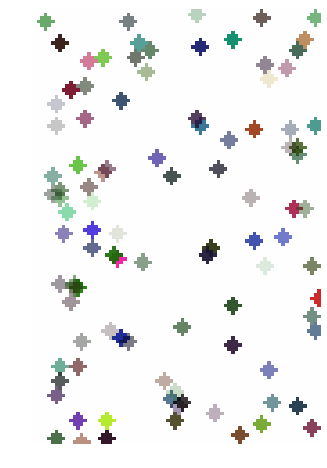

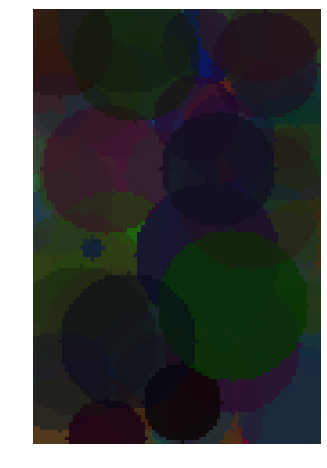

Generation: 78000, score: 1067.97195012, sigma: 0.92492833


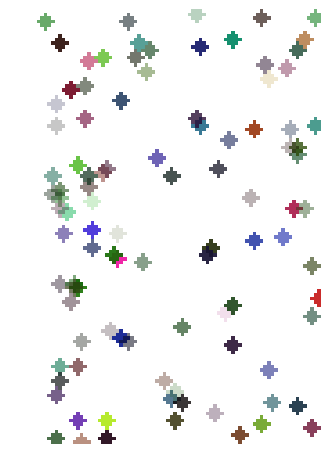

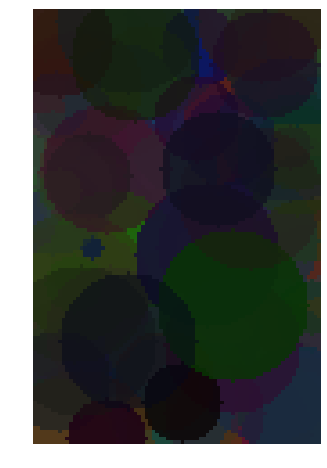

Generation: 79000, score: 1065.76406971, sigma: 0.92400340


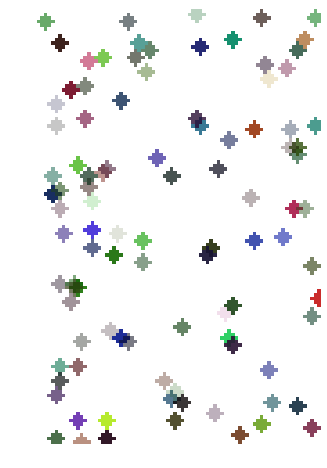

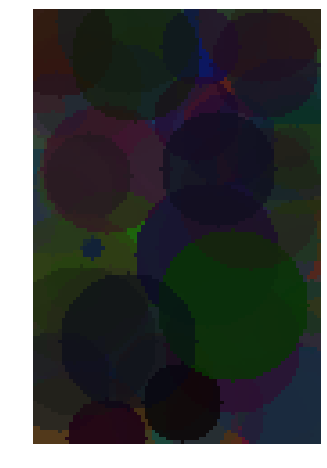

Generation: 80000, score: 1062.70912102, sigma: 0.92307940


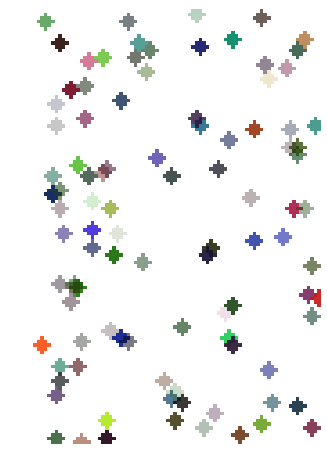

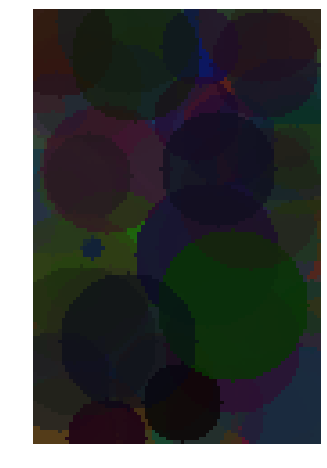

Generation: 81000, score: 1060.94153116, sigma: 0.92215632


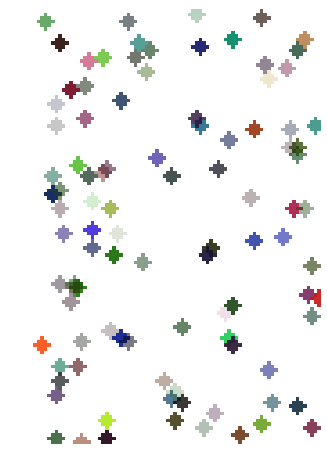

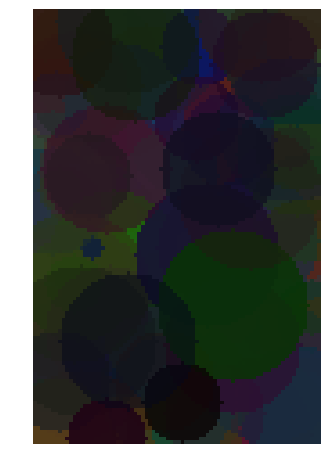

Generation: 82000, score: 1056.84981027, sigma: 0.92123416


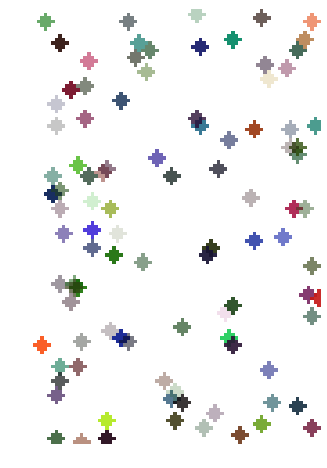

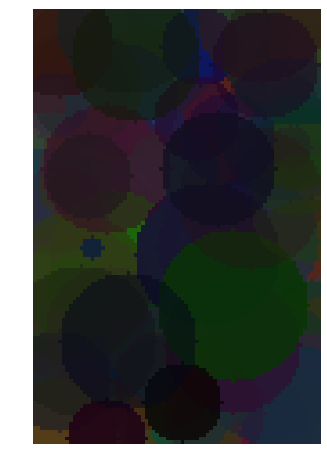

Generation: 83000, score: 1050.49553577, sigma: 0.92031293


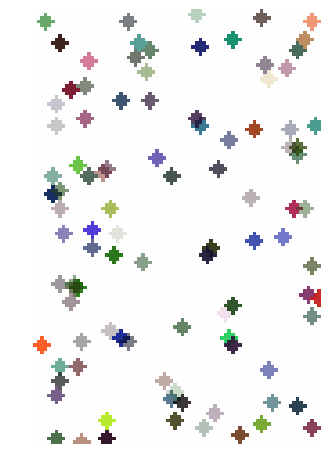

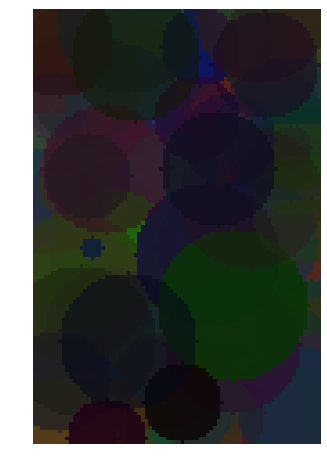

Generation: 84000, score: 1047.79315954, sigma: 0.91939262


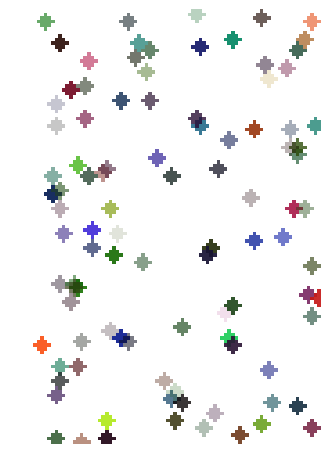

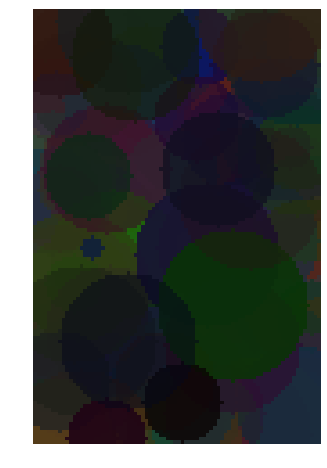

Generation: 85000, score: 1045.30850970, sigma: 0.91847322


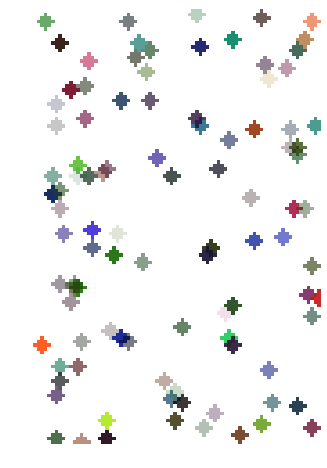

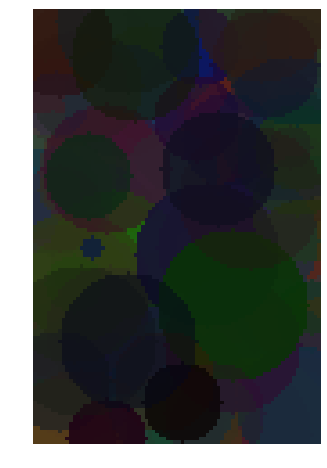

Generation: 86000, score: 1037.21479292, sigma: 0.91755475


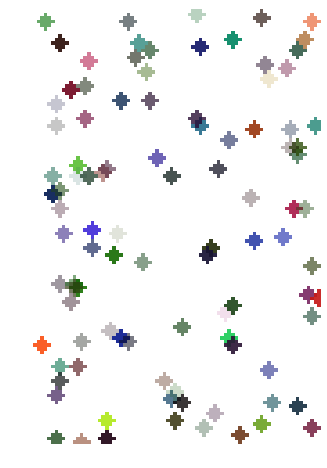

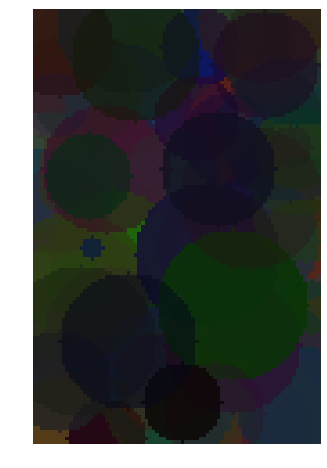

Generation: 87000, score: 1036.08990264, sigma: 0.91663719


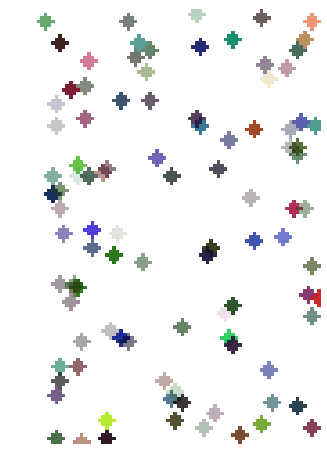

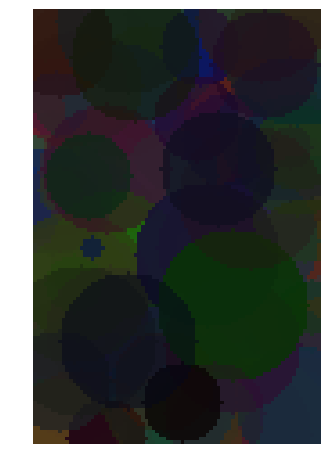

Generation: 88000, score: 1033.68731486, sigma: 0.91572056


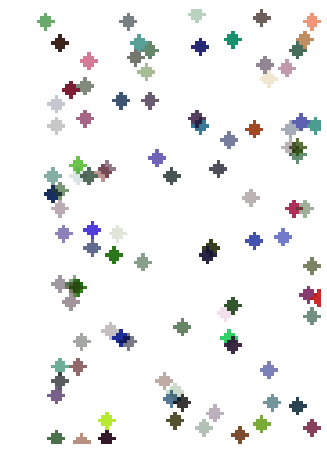

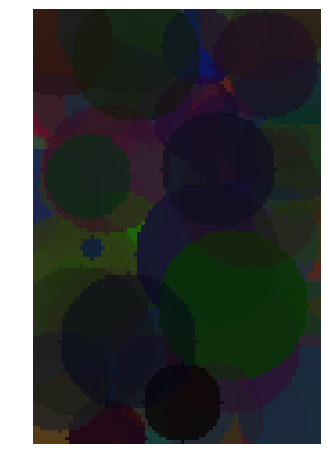

Generation: 89000, score: 1031.20022228, sigma: 0.91480484


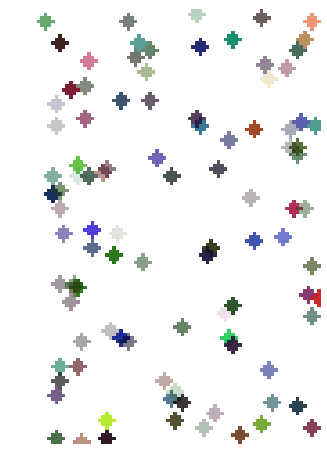

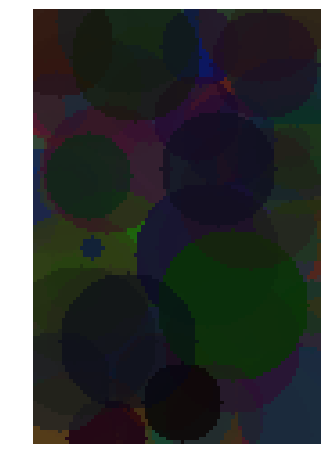

Generation: 90000, score: 1029.39655060, sigma: 0.91389003


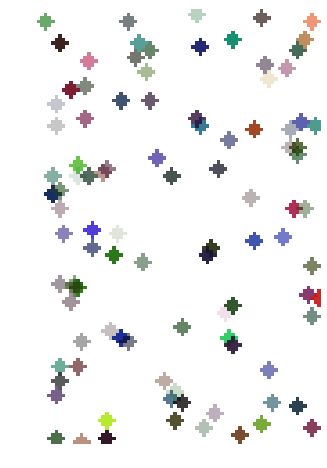

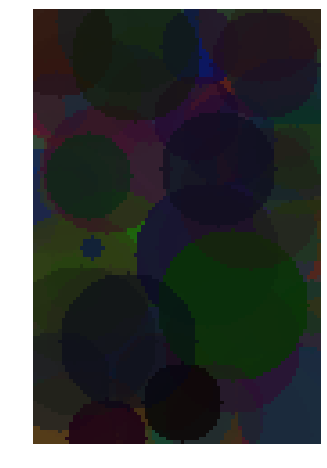

Generation: 91000, score: 1029.36617546, sigma: 0.91297614


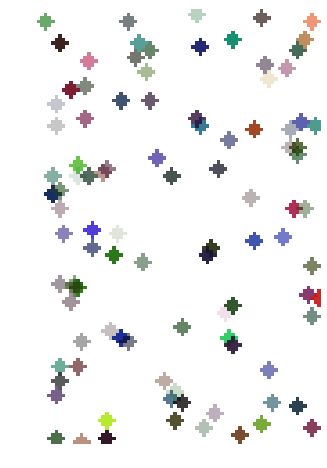

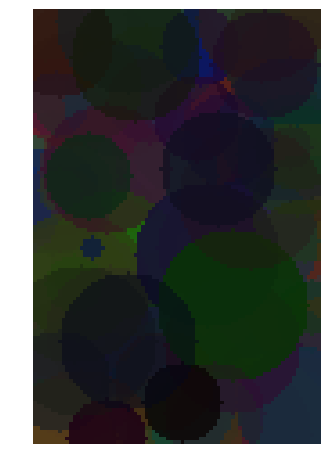

Generation: 92000, score: 1028.05700123, sigma: 0.91206317


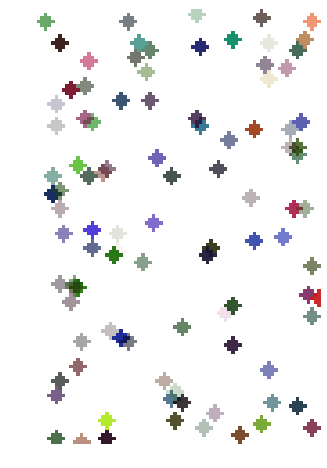

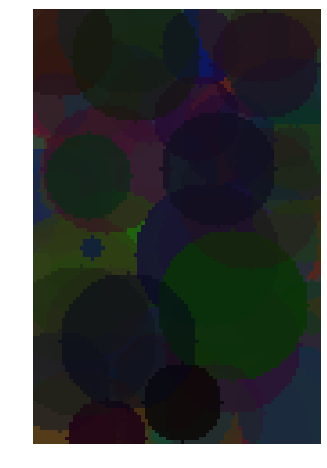

Generation: 93000, score: 1027.92671954, sigma: 0.91115110


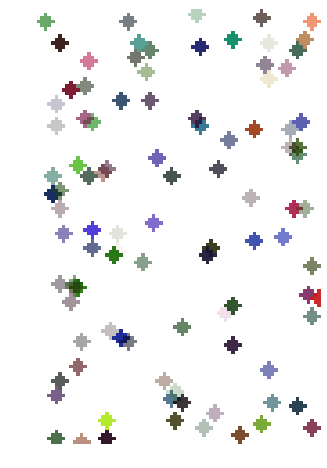

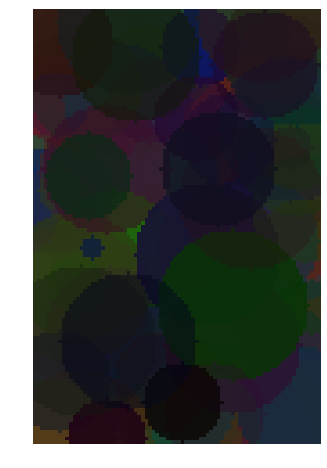

Generation: 94000, score: 1026.11115034, sigma: 0.91023995


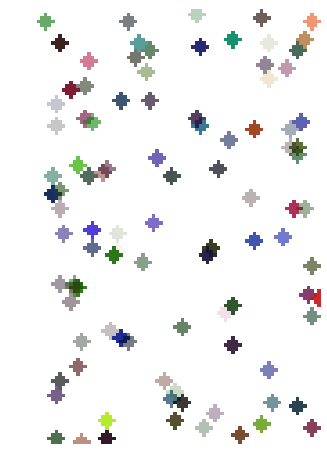

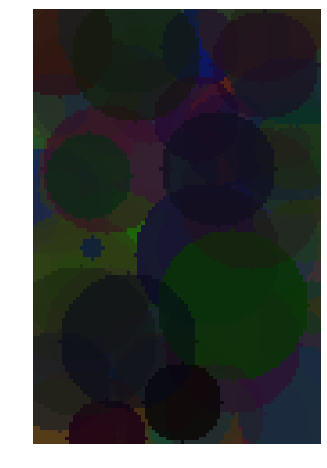

Generation: 95000, score: 1025.36131232, sigma: 0.90932971


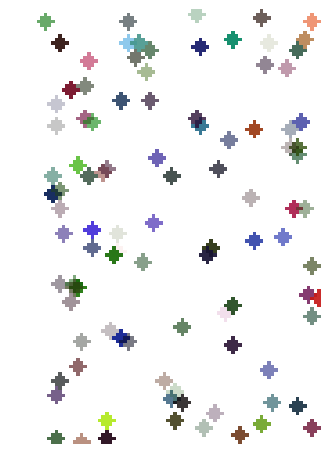

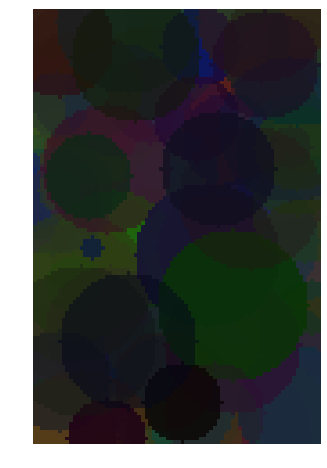

Generation: 96000, score: 1024.20021877, sigma: 0.90842038


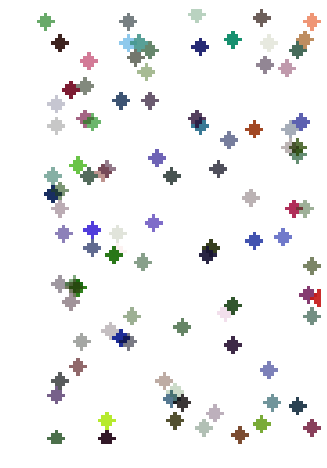

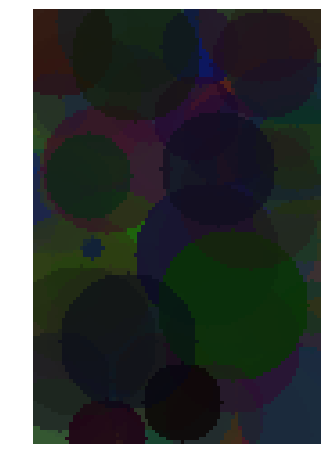

Generation: 97000, score: 1023.70732047, sigma: 0.90751196


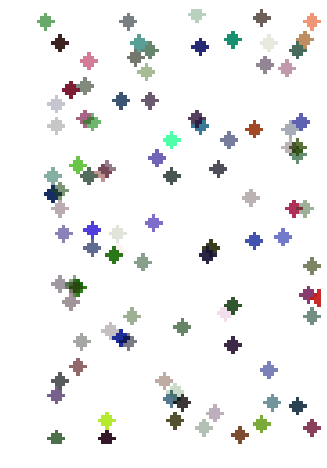

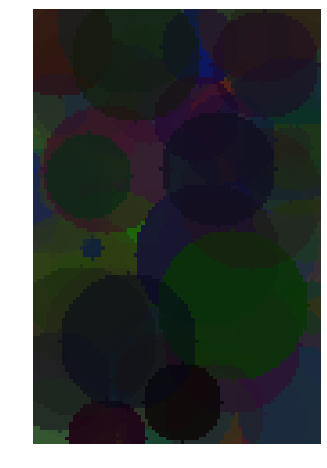

Generation: 98000, score: 1023.30139274, sigma: 0.90660445


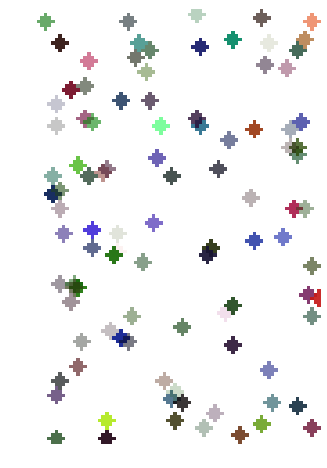

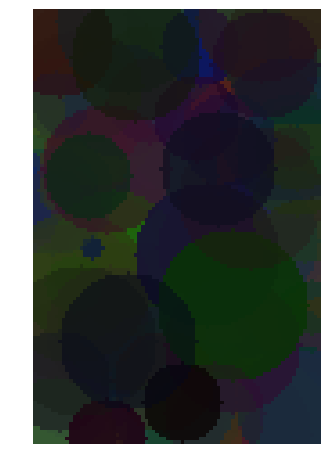

Generation: 99000, score: 1022.68482837, sigma: 0.90569784


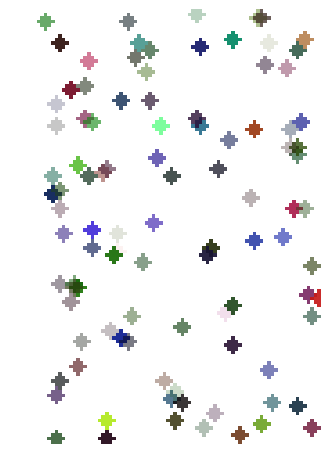

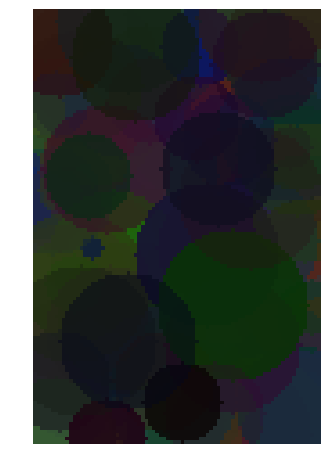

In [130]:
evolution = Evolution(target=rescaled_mona_lisa)
evolution.evolve(sigma=1, filename='results/mona01_best_chromosome100.txt')

Generation: 0, score: 20044.27492721, sigma: 1.00000000


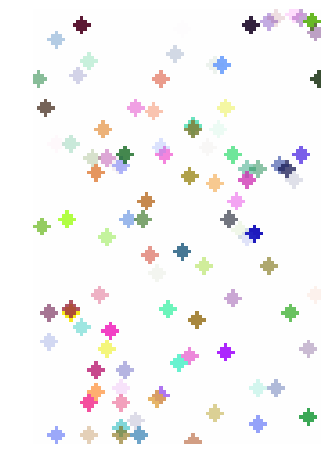

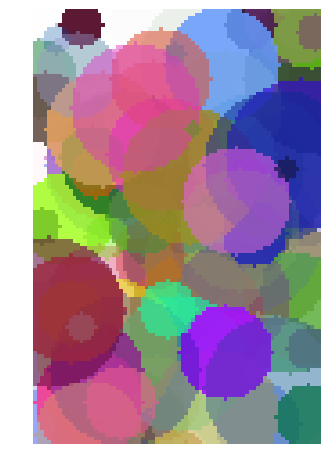

Generation: 1000, score: 10916.01852610, sigma: 0.99900000


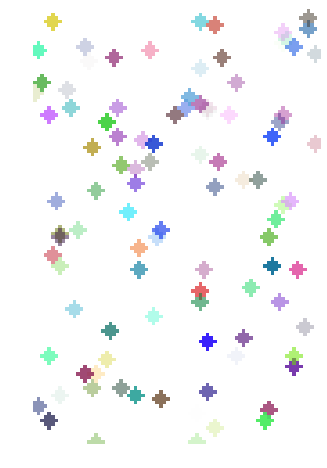

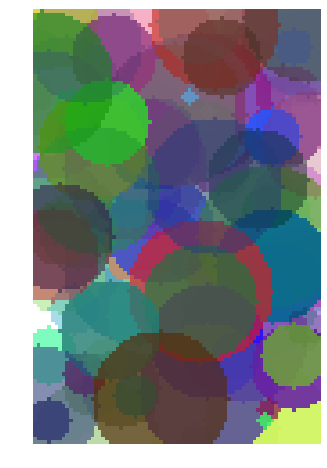

Generation: 2000, score: 9130.62267366, sigma: 0.99800100


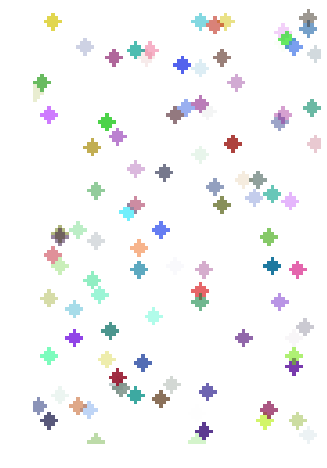

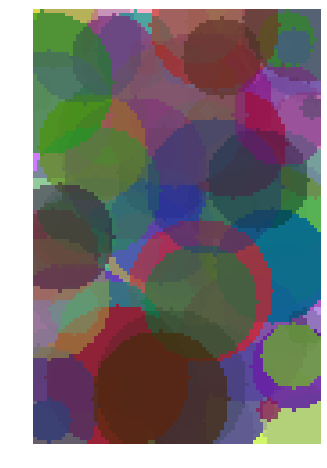

Generation: 3000, score: 7662.45489899, sigma: 0.99700300


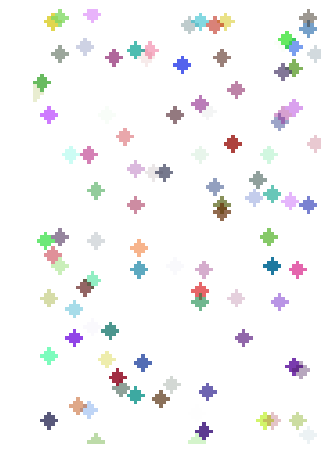

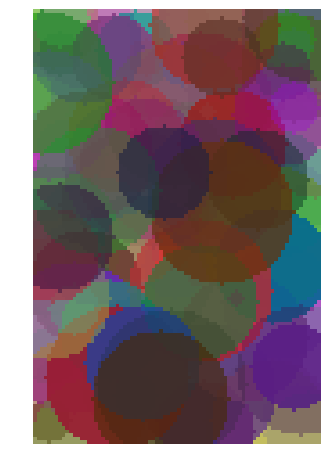

Generation: 4000, score: 6956.42918004, sigma: 0.99600600


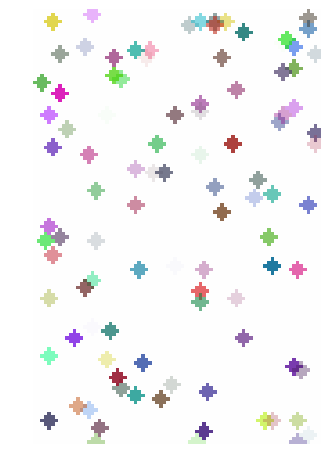

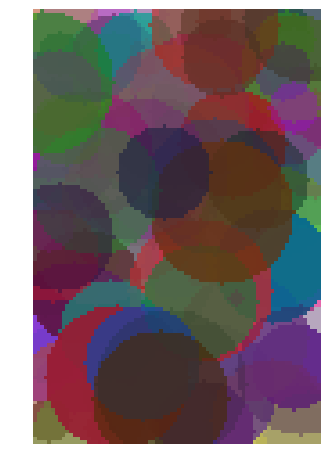

Generation: 5000, score: 6370.24296494, sigma: 0.99500999


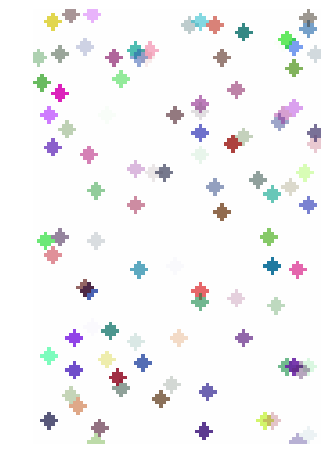

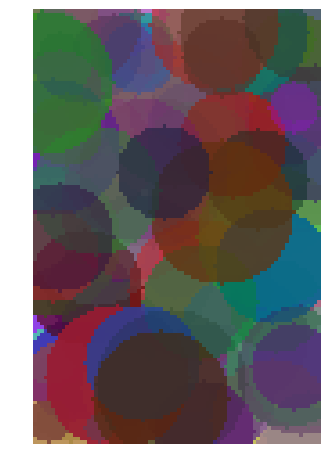

Generation: 6000, score: 5911.21162528, sigma: 0.99401498


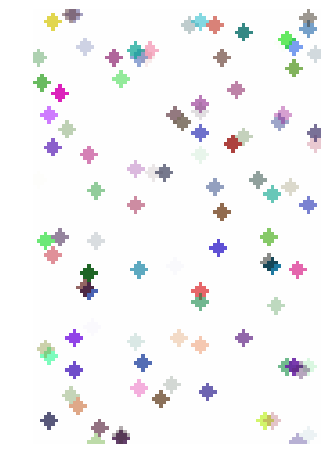

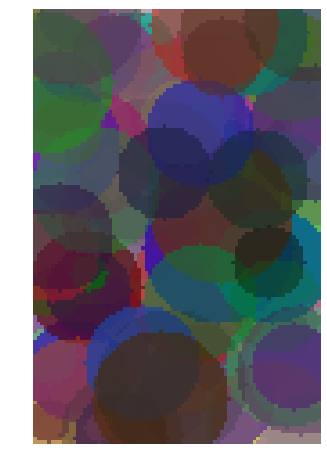

Generation: 7000, score: 5467.19612806, sigma: 0.99302097


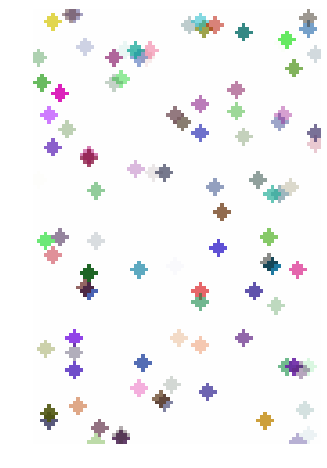

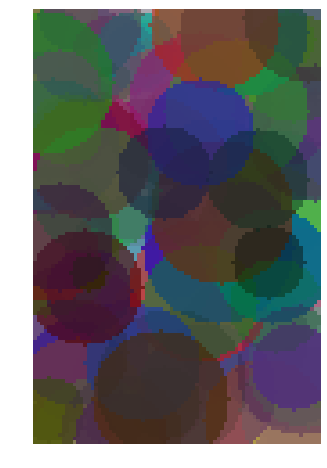

Generation: 8000, score: 5158.51890050, sigma: 0.99202794


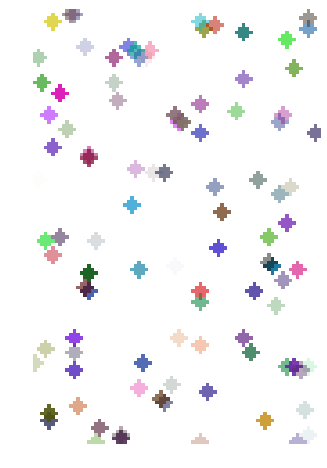

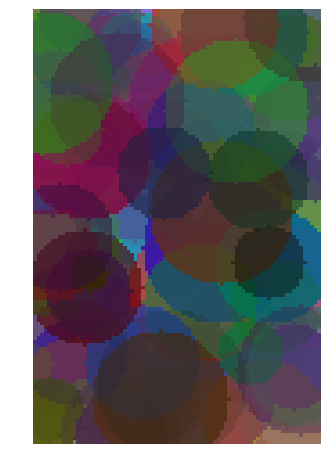

Generation: 9000, score: 4903.87718104, sigma: 0.99103592


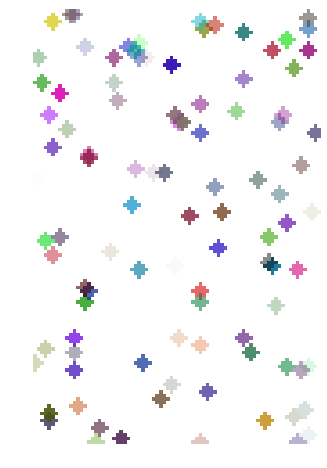

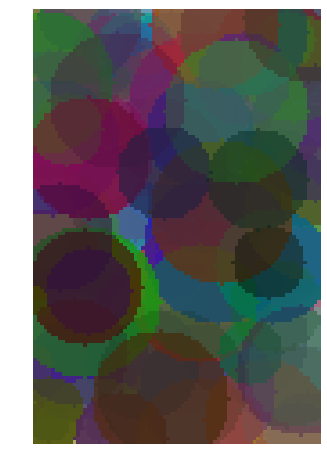

Generation: 10000, score: 4798.77496982, sigma: 0.99004488


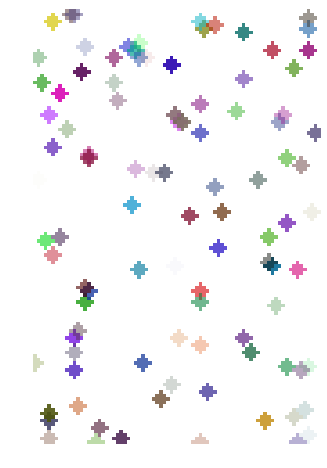

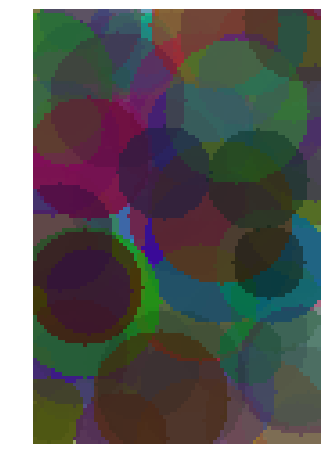

Generation: 11000, score: 4383.19488758, sigma: 0.98905484


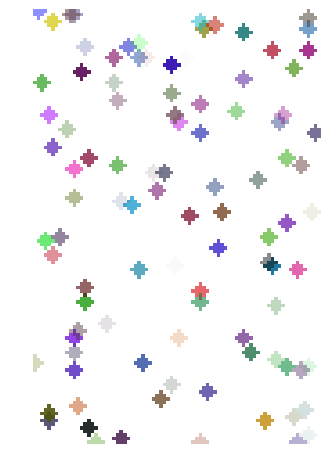

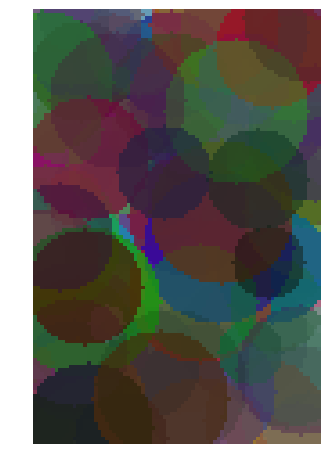

Generation: 12000, score: 4183.48290519, sigma: 0.98806578


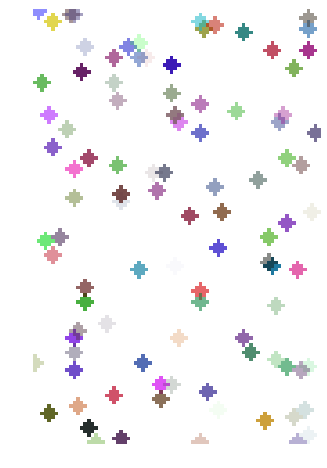

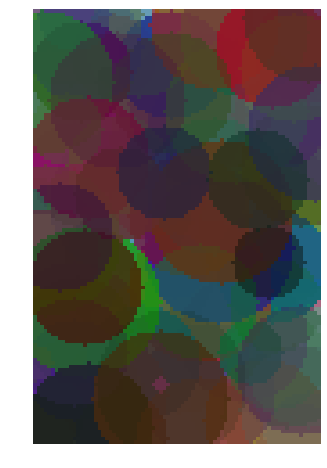

Generation: 13000, score: 3821.62499345, sigma: 0.98707771


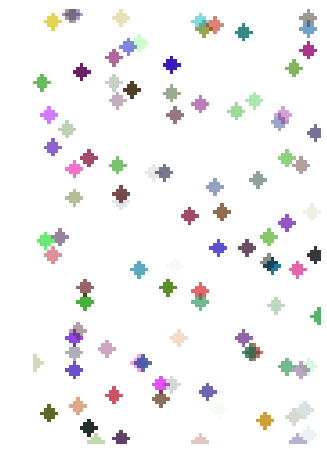

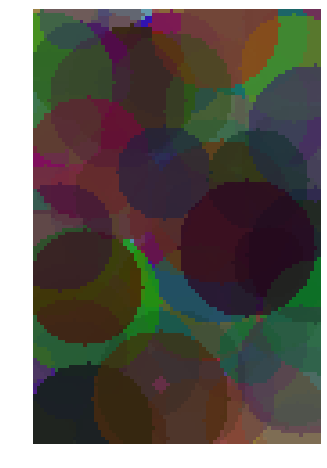

Generation: 14000, score: 3255.62643629, sigma: 0.98609064


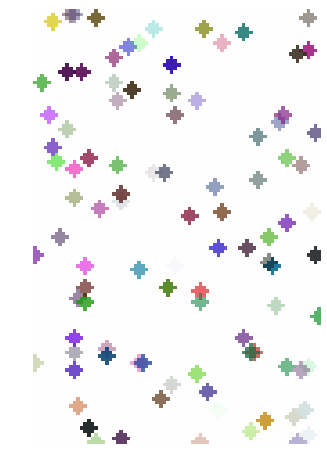

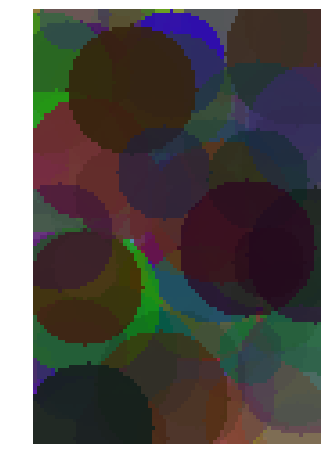

Generation: 15000, score: 3016.67158855, sigma: 0.98510455


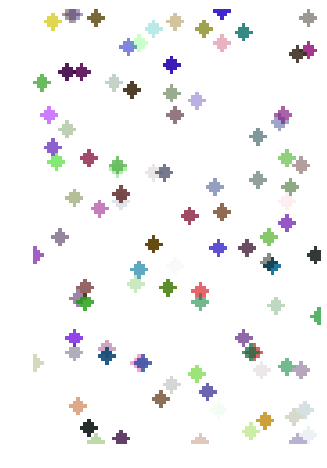

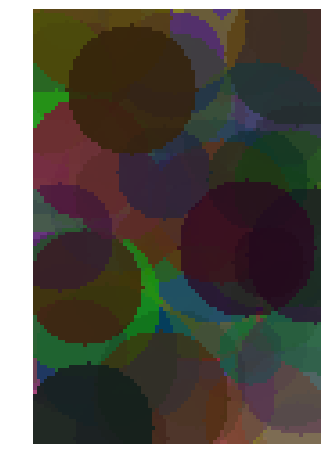

Generation: 16000, score: 2934.75065515, sigma: 0.98411944


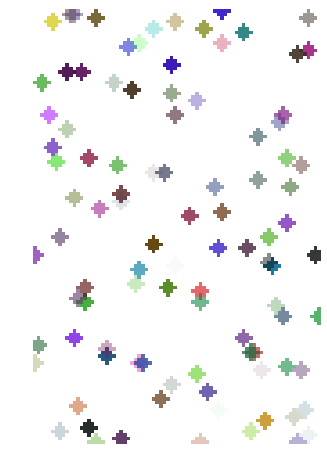

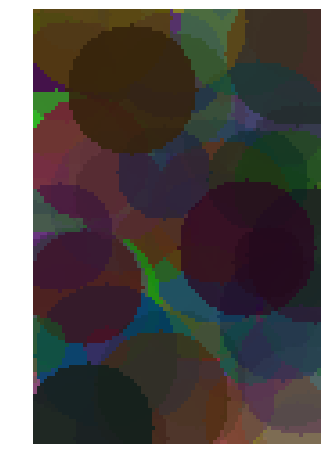

Generation: 17000, score: 2877.17207874, sigma: 0.98313532


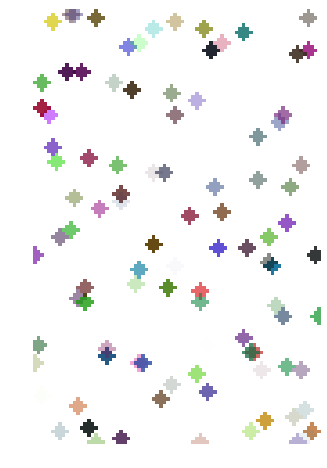

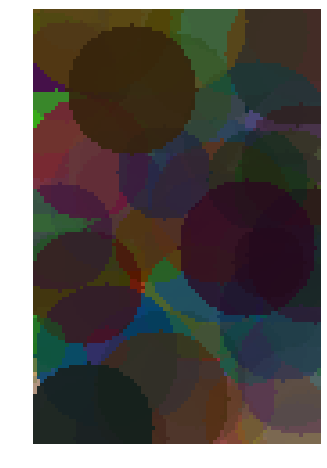

Generation: 18000, score: 2572.62269372, sigma: 0.98215219


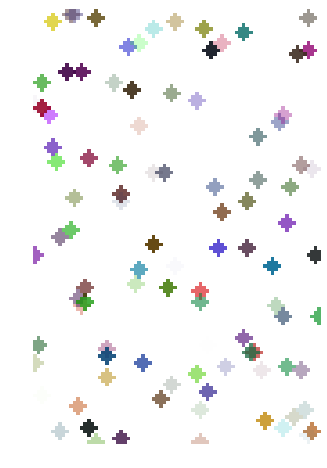

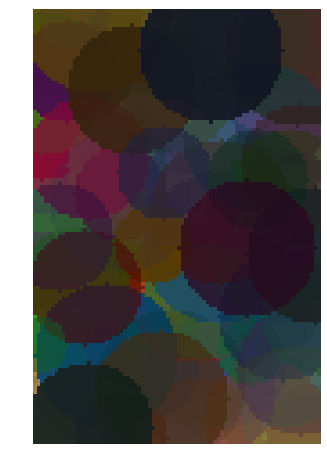

Generation: 19000, score: 2502.14697652, sigma: 0.98117003


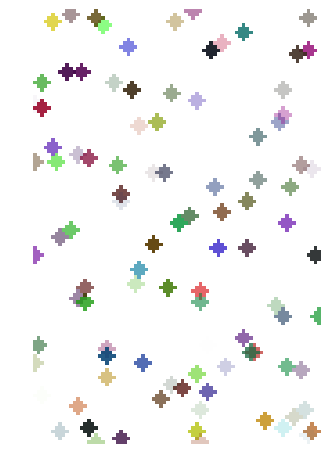

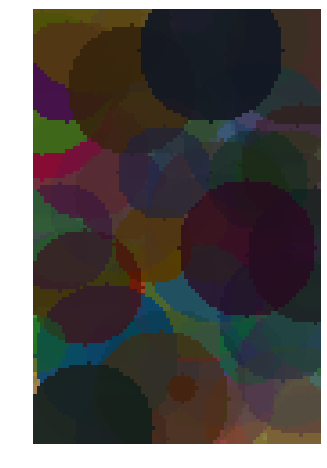

Generation: 20000, score: 2461.42614852, sigma: 0.98018886


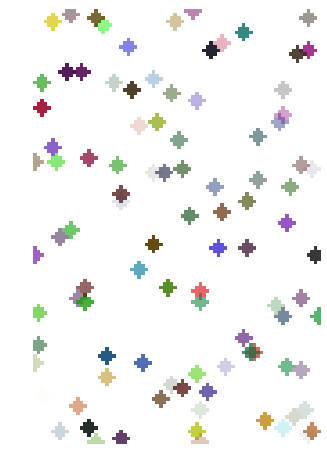

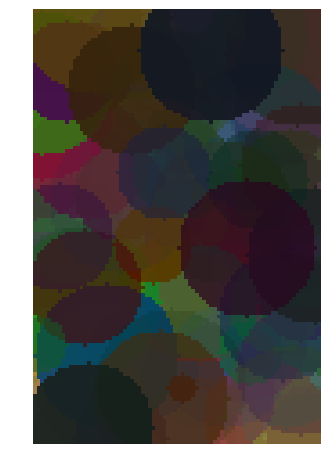

Generation: 21000, score: 2428.43096520, sigma: 0.97920868


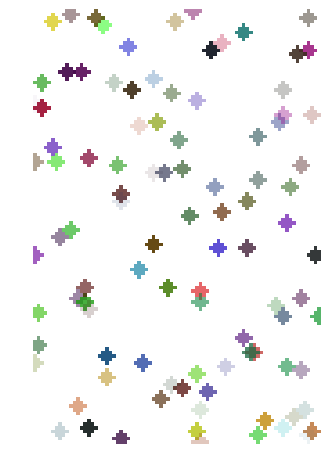

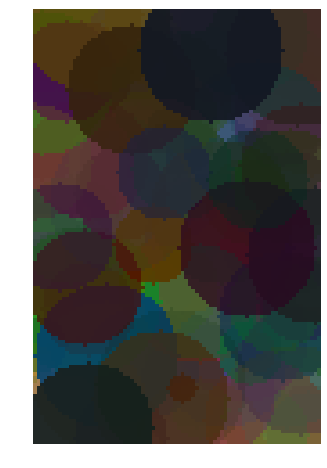

Generation: 22000, score: 2390.04461358, sigma: 0.97822947


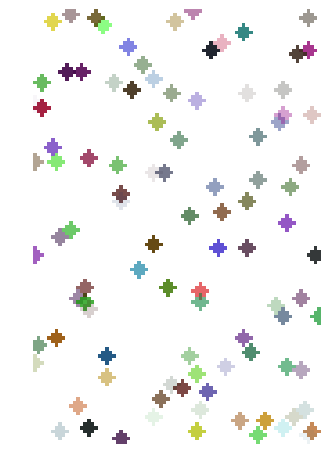

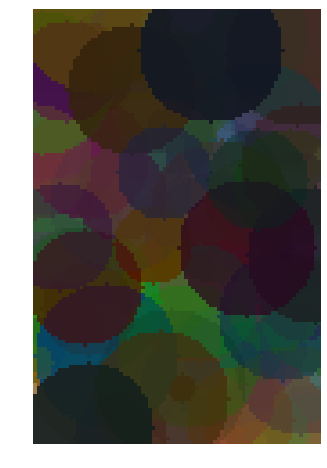

Generation: 23000, score: 2293.92720305, sigma: 0.97725124


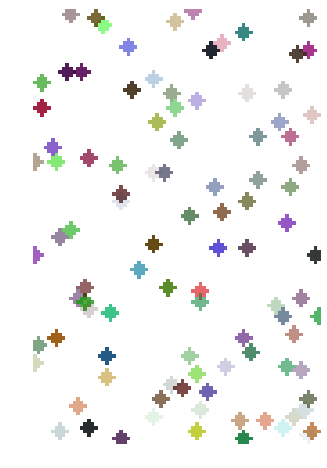

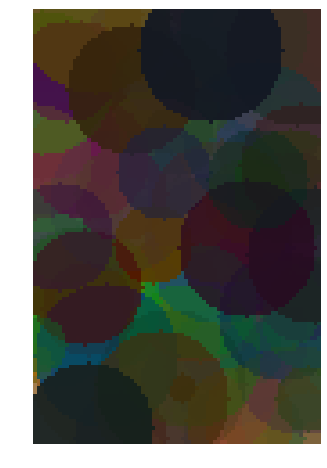

Generation: 24000, score: 2253.60461628, sigma: 0.97627399


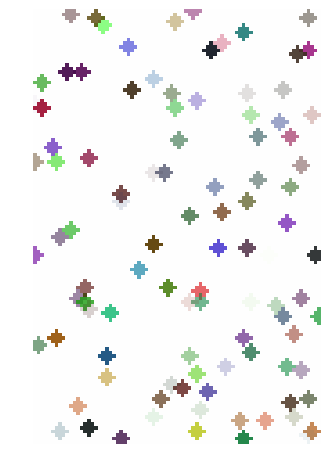

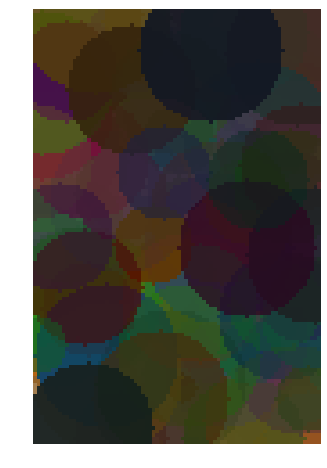

Generation: 25000, score: 2123.69516191, sigma: 0.97529771


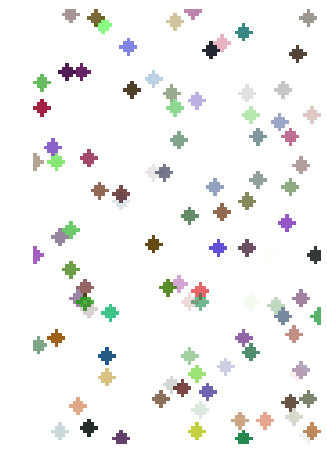

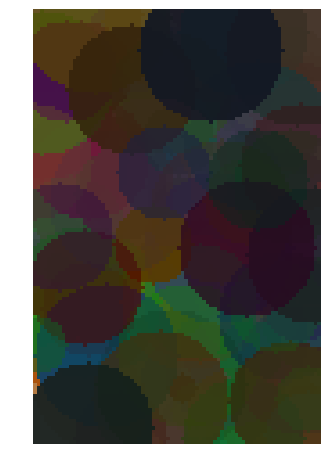

Generation: 26000, score: 2102.93413493, sigma: 0.97432241


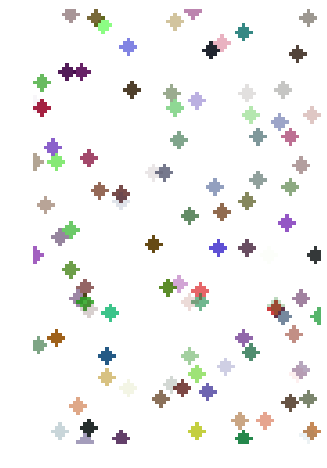

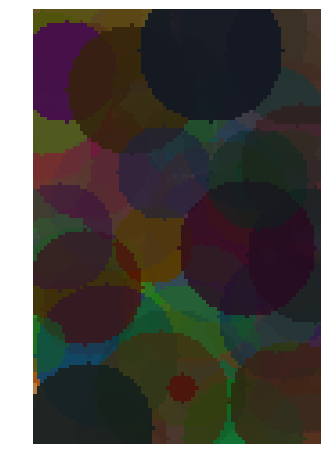

Generation: 27000, score: 2094.20294280, sigma: 0.97334809


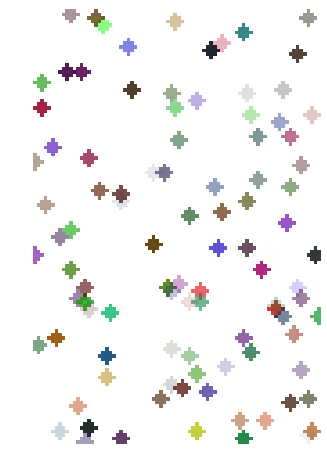

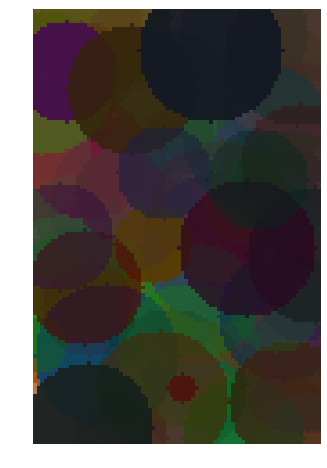

Generation: 28000, score: 2081.17869031, sigma: 0.97237474


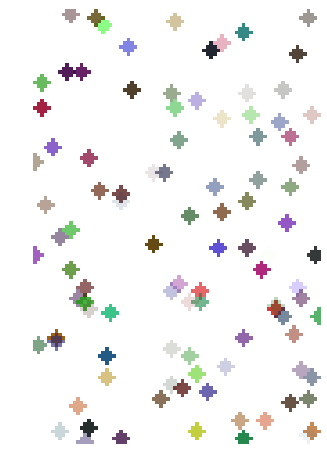

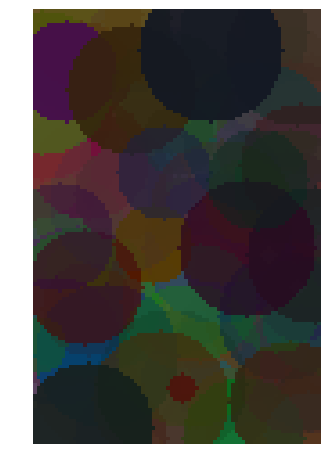

Generation: 29000, score: 2070.52323334, sigma: 0.97140237


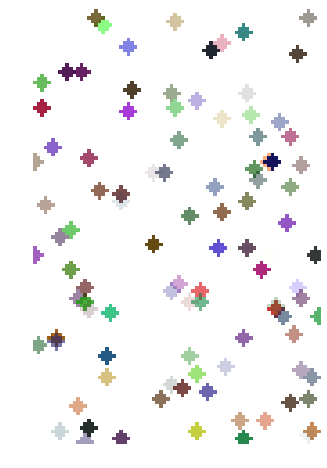

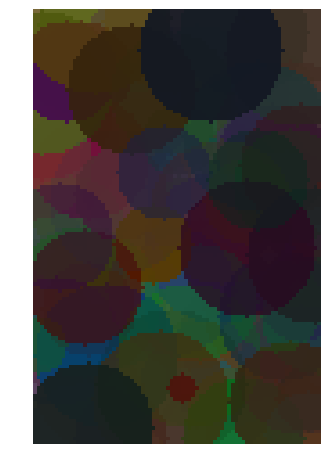

Generation: 30000, score: 2004.26341909, sigma: 0.97043097


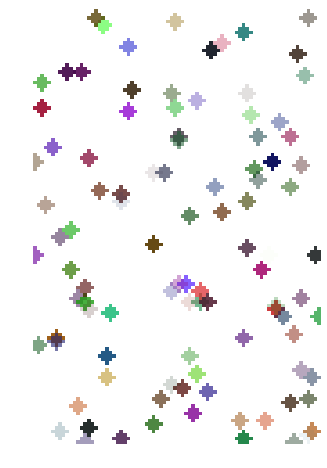

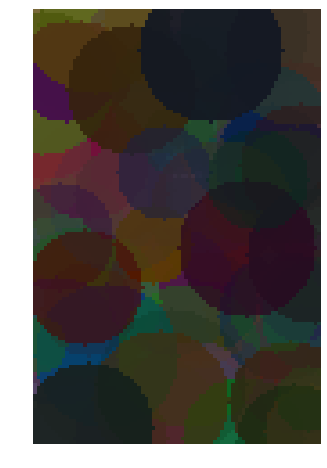

Generation: 31000, score: 1986.01468515, sigma: 0.96946054


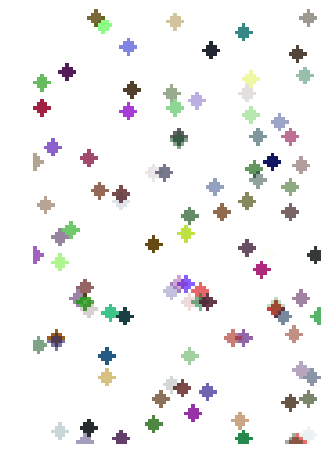

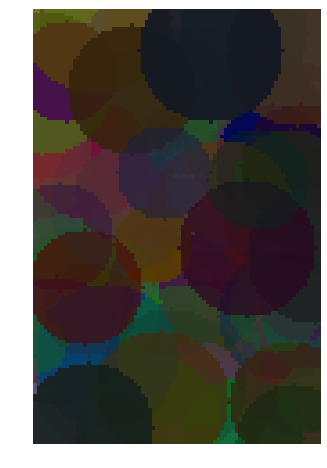

Generation: 32000, score: 1928.74849187, sigma: 0.96849108


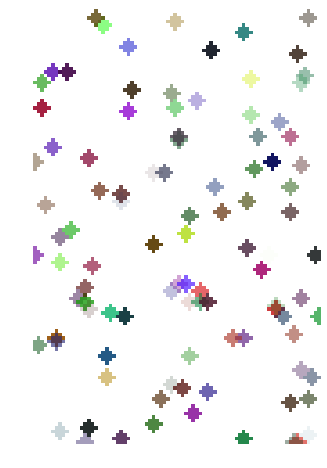

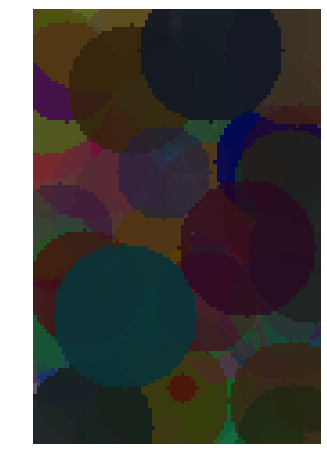

Generation: 33000, score: 1910.60091159, sigma: 0.96752258


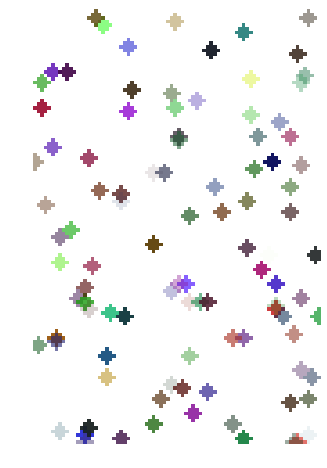

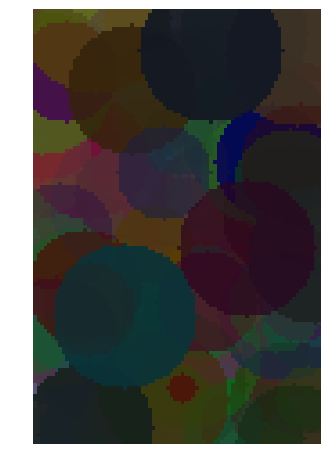

Generation: 34000, score: 1801.98967273, sigma: 0.96655506


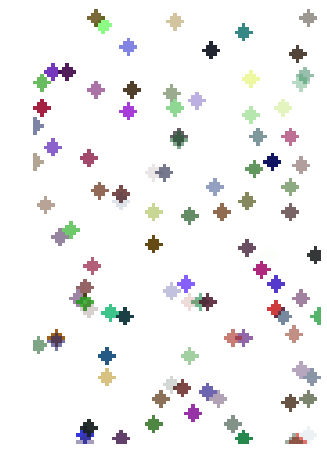

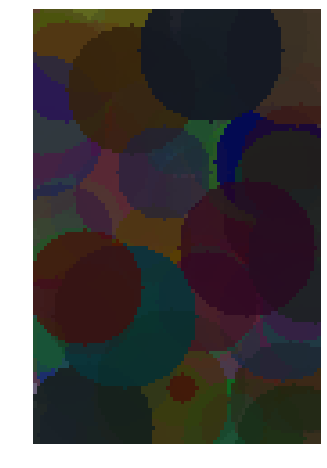

Generation: 35000, score: 1780.10103184, sigma: 0.96558851


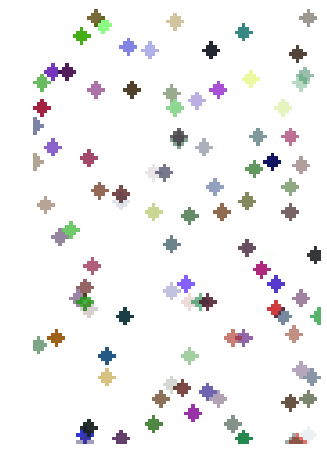

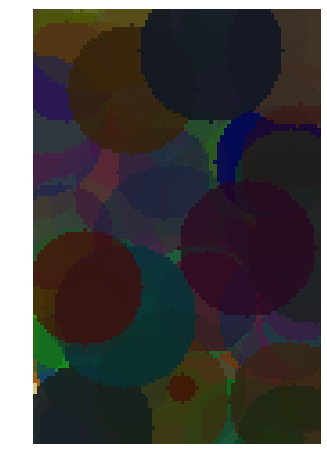

Generation: 36000, score: 1753.02748427, sigma: 0.96462292


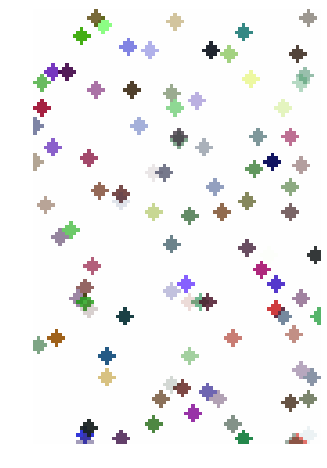

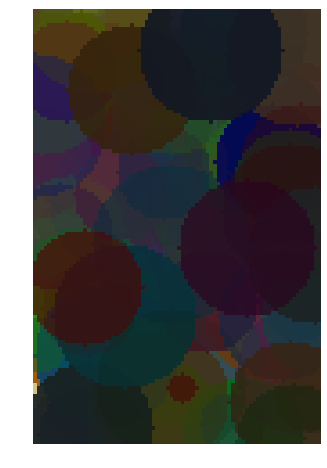

Generation: 37000, score: 1725.39751229, sigma: 0.96365830


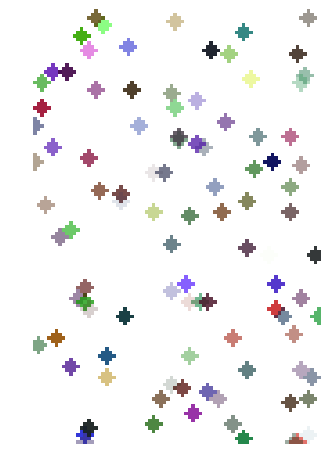

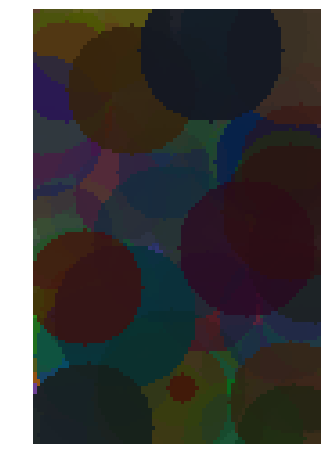

Generation: 38000, score: 1711.51387323, sigma: 0.96269464


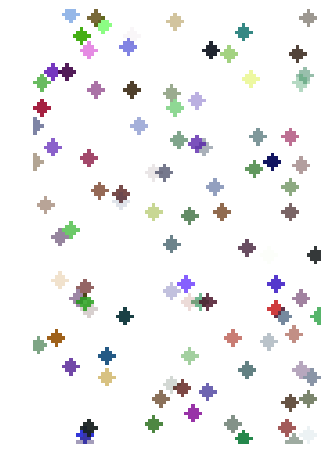

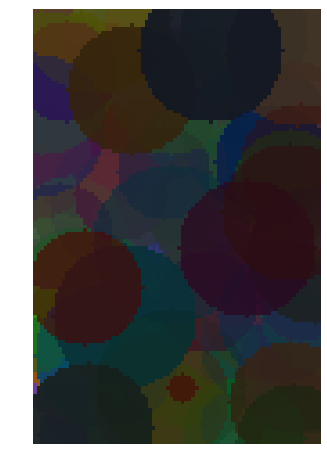

Generation: 39000, score: 1704.15792592, sigma: 0.96173194


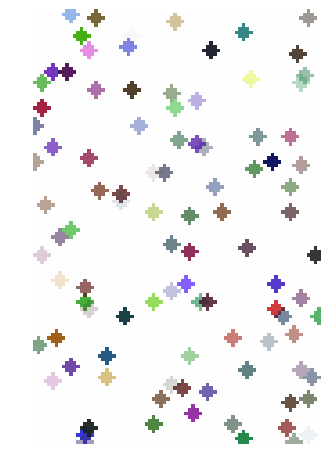

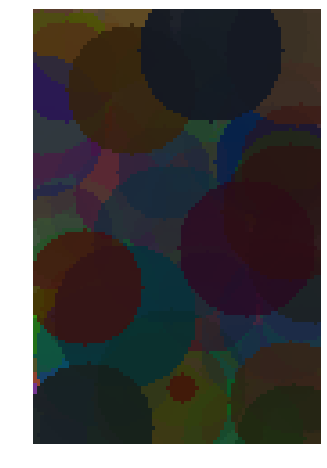

Generation: 40000, score: 1689.97147471, sigma: 0.96077021


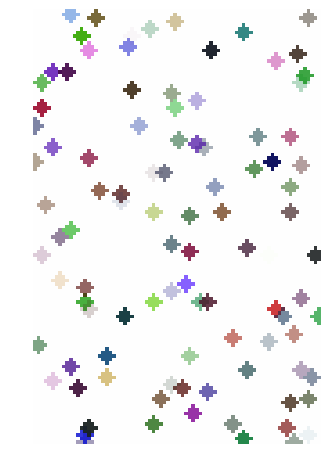

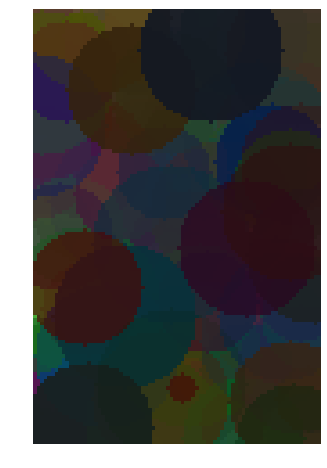

Generation: 41000, score: 1610.13019345, sigma: 0.95980944


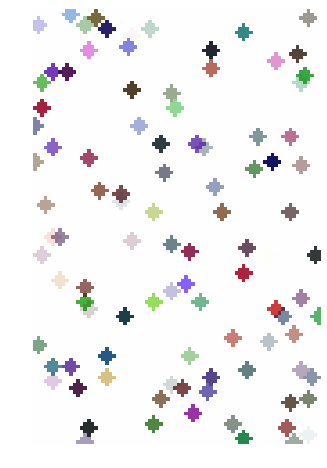

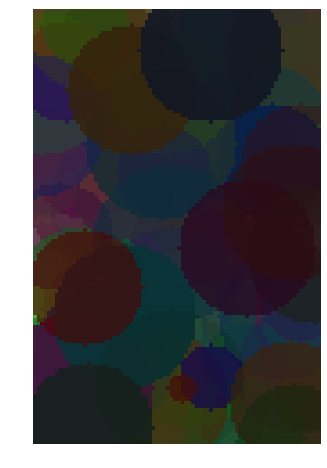

Generation: 42000, score: 1598.68925276, sigma: 0.95884963


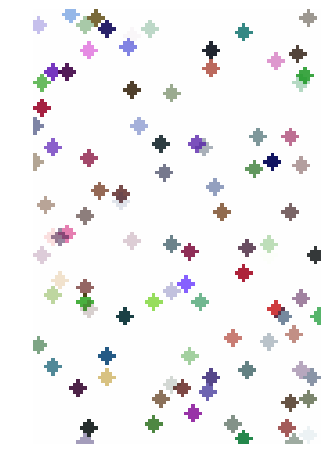

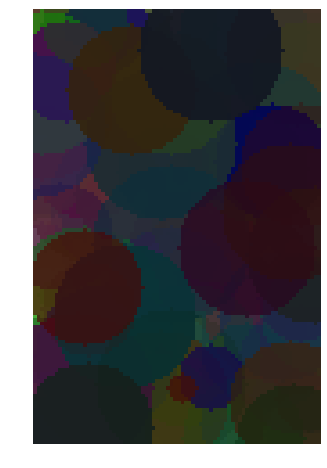

Generation: 43000, score: 1591.14042079, sigma: 0.95789078


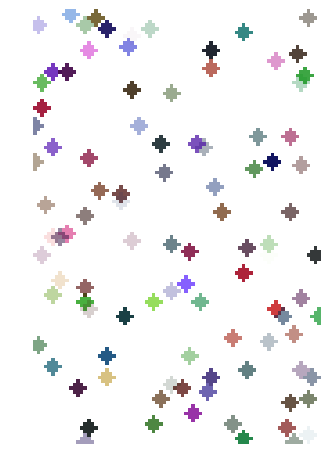

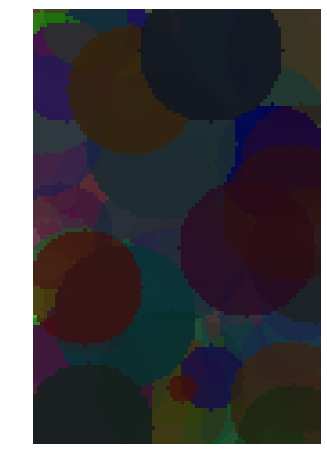

Generation: 44000, score: 1570.90408159, sigma: 0.95693289


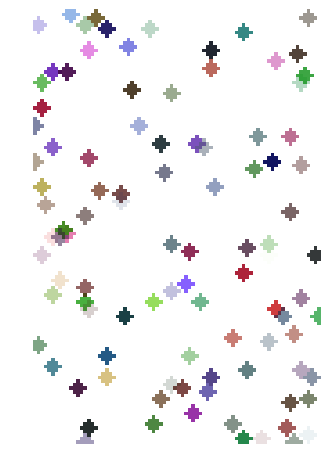

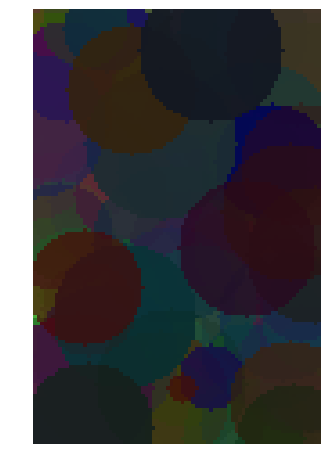

Generation: 45000, score: 1564.20484828, sigma: 0.95597596


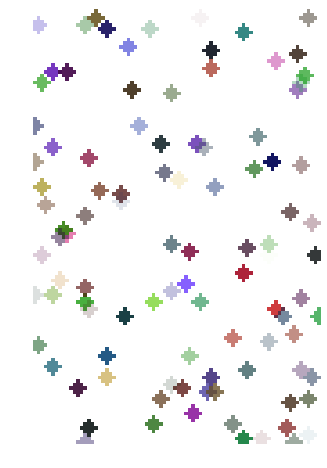

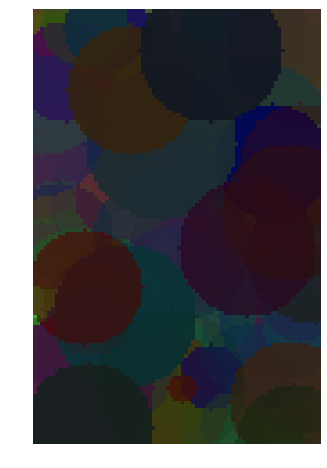

Generation: 46000, score: 1556.84649544, sigma: 0.95501998


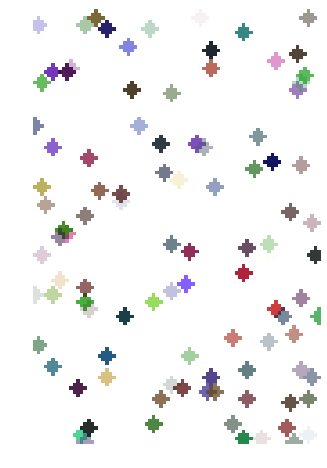

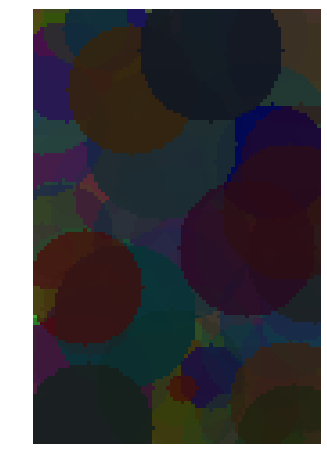

Generation: 47000, score: 1547.63318452, sigma: 0.95406496


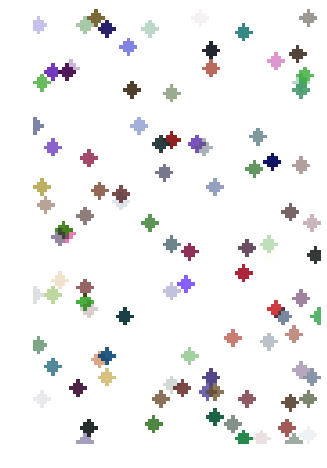

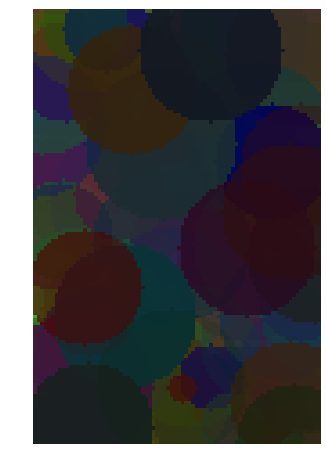

Generation: 48000, score: 1520.38981662, sigma: 0.95311090


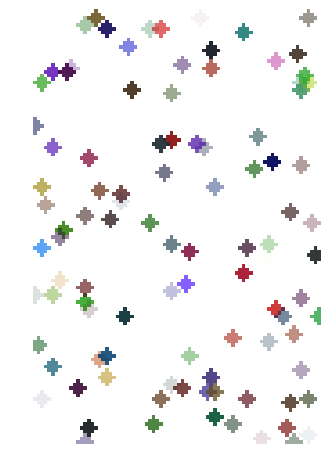

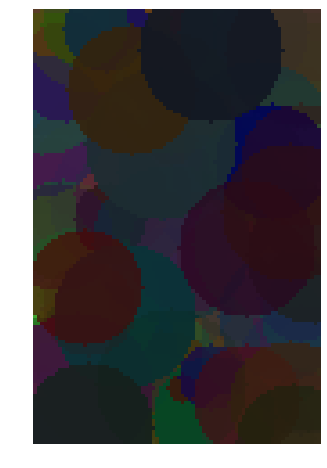

Generation: 49000, score: 1516.21603306, sigma: 0.95215779


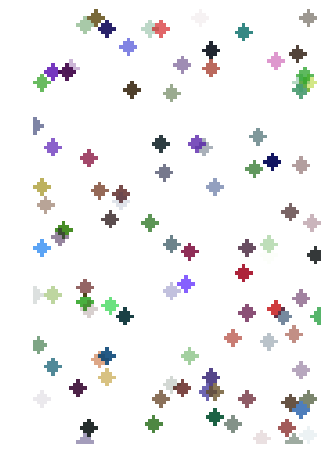

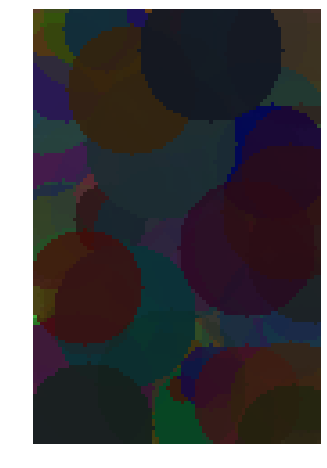

Generation: 50000, score: 1496.43604548, sigma: 0.95120563


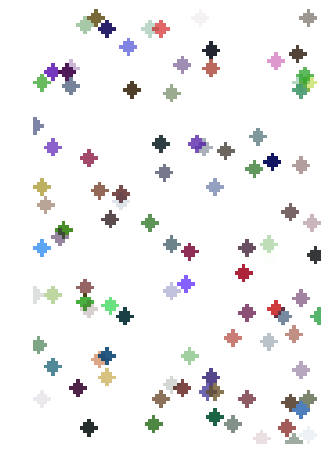

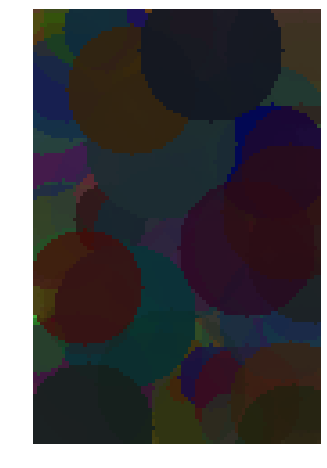

Generation: 51000, score: 1491.55132643, sigma: 0.95025442


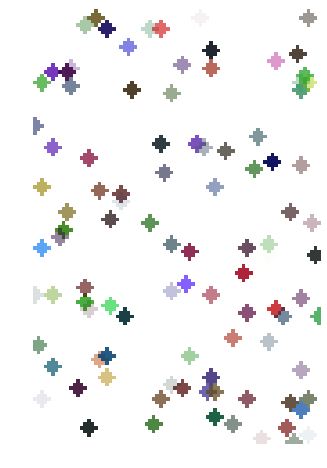

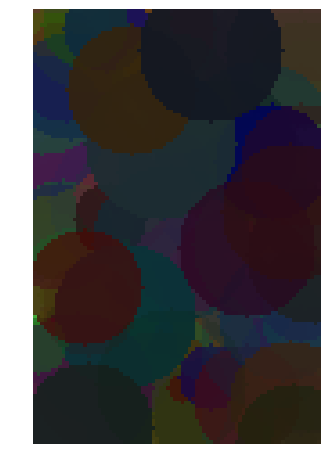

Generation: 52000, score: 1426.29449225, sigma: 0.94930417


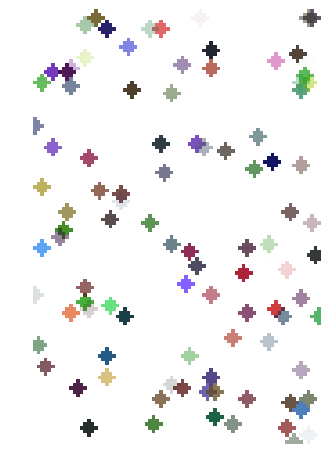

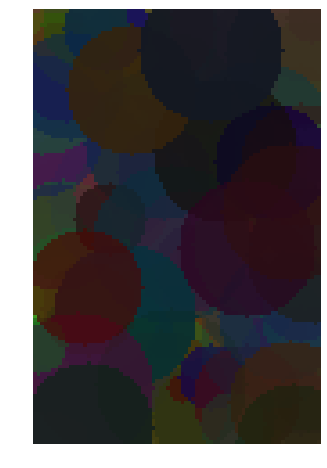

Generation: 53000, score: 1385.23020817, sigma: 0.94835486


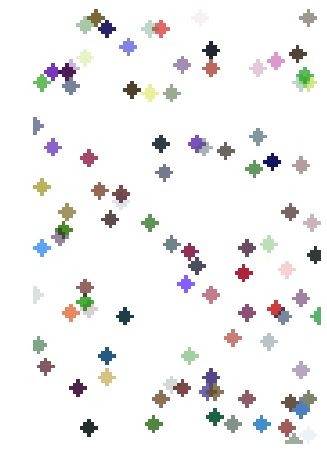

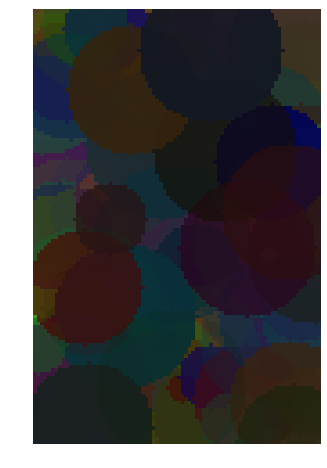

Generation: 54000, score: 1373.39589626, sigma: 0.94740651


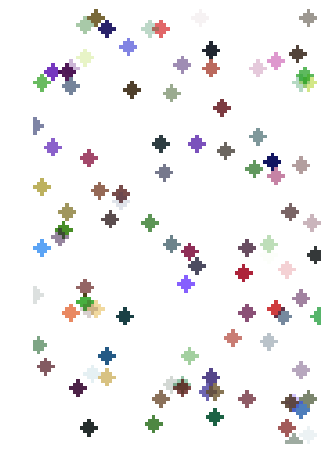

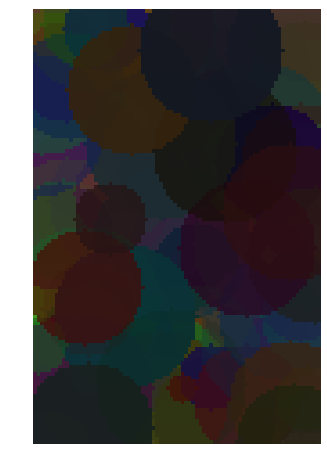

Generation: 55000, score: 1332.84422008, sigma: 0.94645910


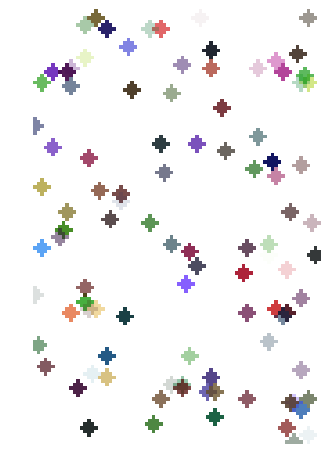

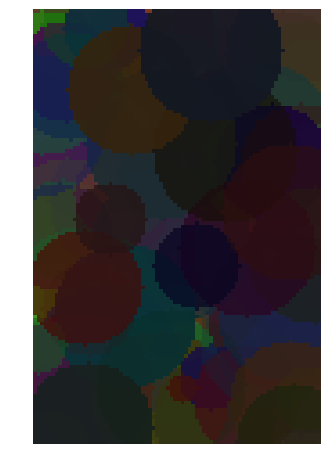

Generation: 56000, score: 1328.96445822, sigma: 0.94551264


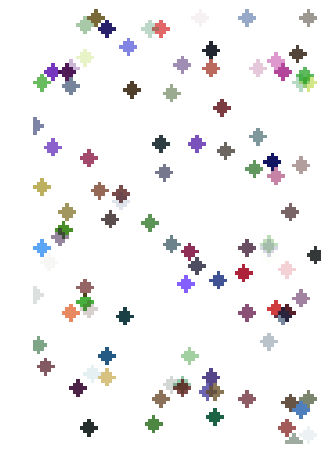

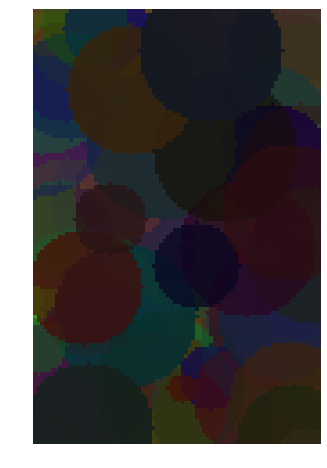

Generation: 57000, score: 1307.29058101, sigma: 0.94456713


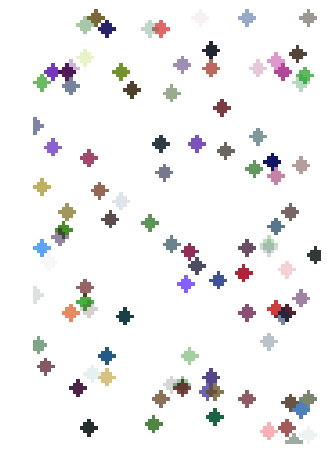

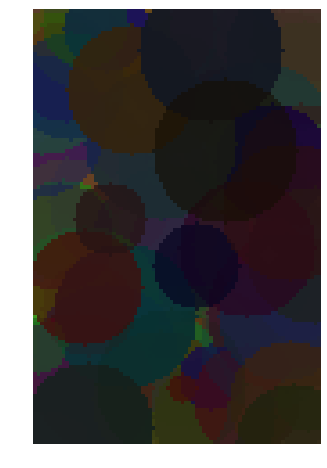

Generation: 58000, score: 1287.52362948, sigma: 0.94362256


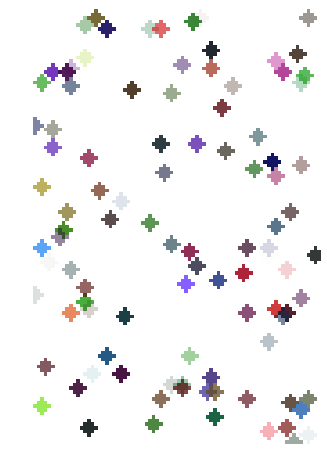

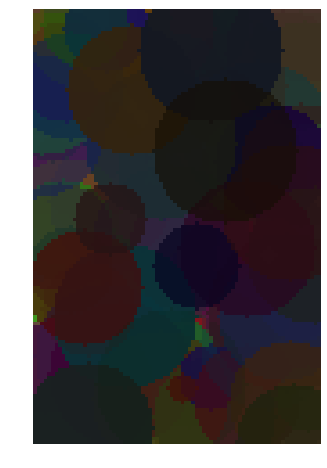

Generation: 59000, score: 1267.05602887, sigma: 0.94267894


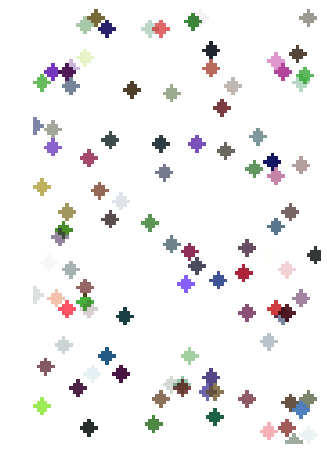

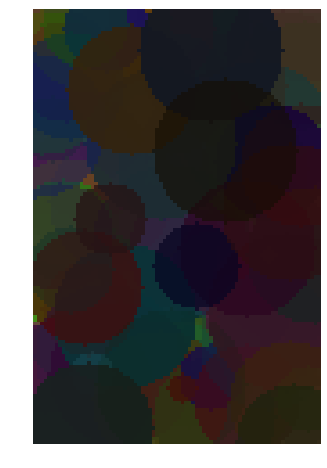

Generation: 60000, score: 1248.67603097, sigma: 0.94173626


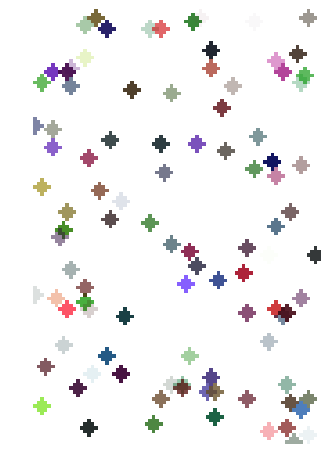

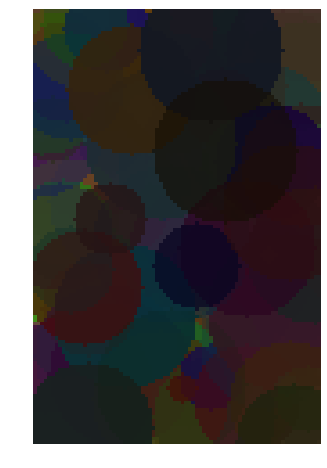

Generation: 61000, score: 1244.85092773, sigma: 0.94079453


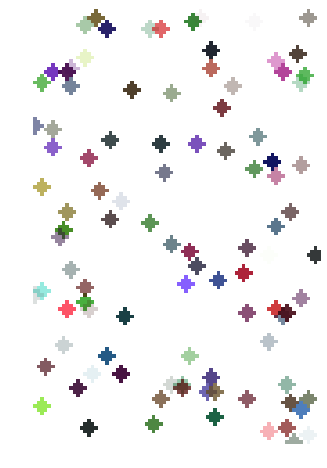

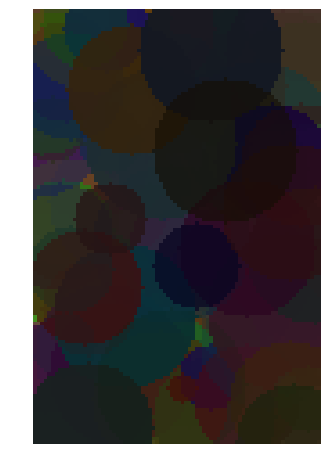

Generation: 62000, score: 1237.66596716, sigma: 0.93985373


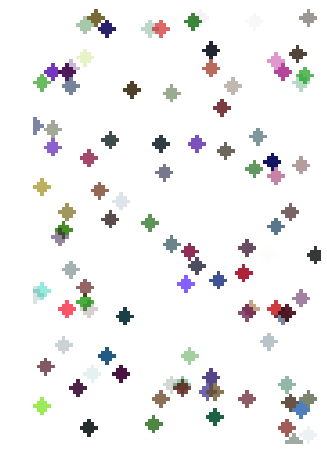

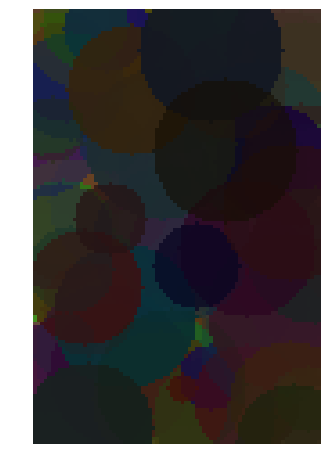

Generation: 63000, score: 1230.18051275, sigma: 0.93891388


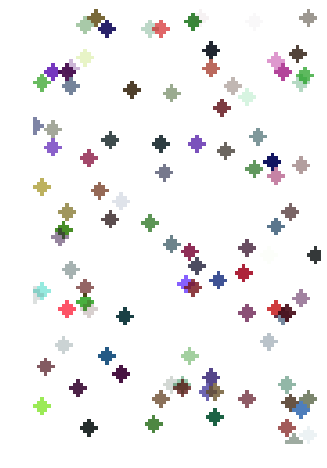

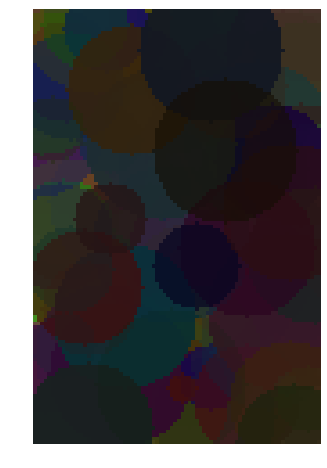

Generation: 64000, score: 1229.04786974, sigma: 0.93797496


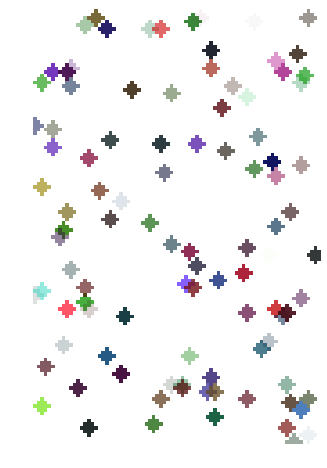

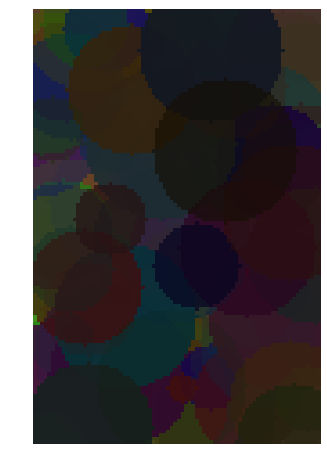

Generation: 65000, score: 1227.33783342, sigma: 0.93703699


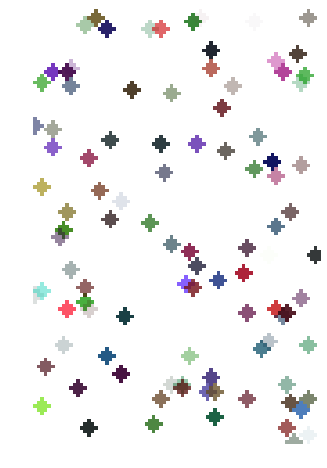

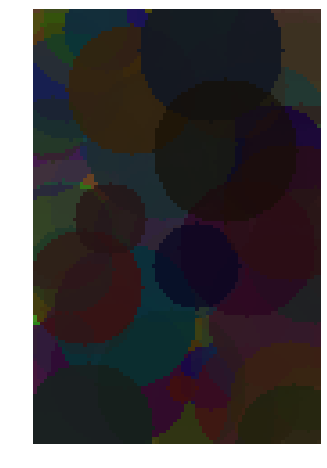

Generation: 66000, score: 1226.71053739, sigma: 0.93609995


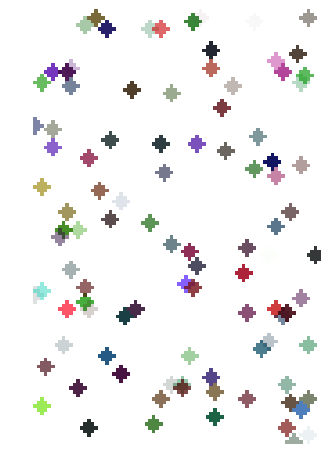

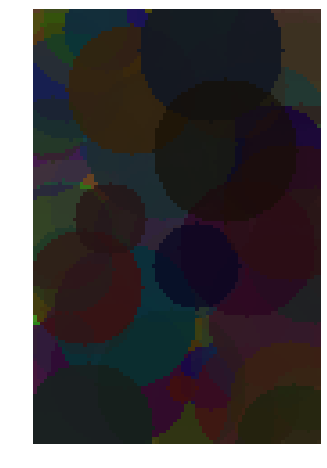

Generation: 67000, score: 1225.93358221, sigma: 0.93516385


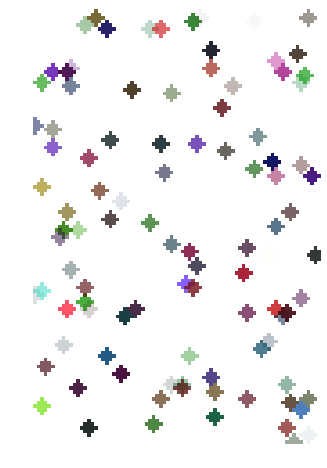

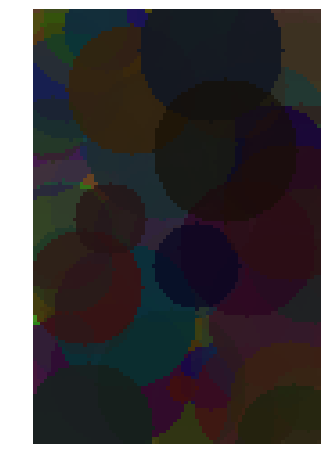

Generation: 68000, score: 1222.47540114, sigma: 0.93422869


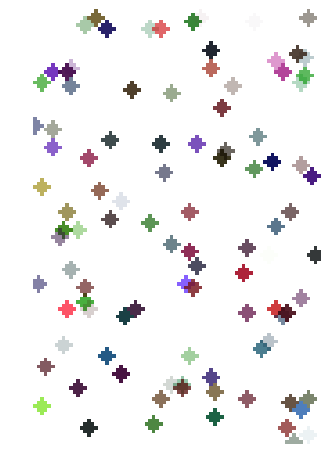

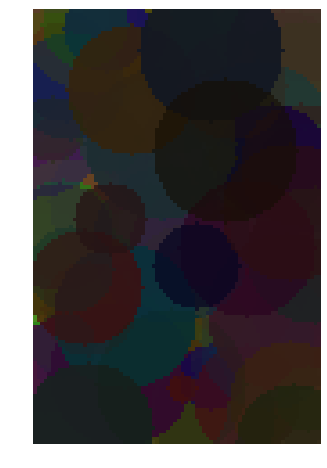

Generation: 69000, score: 1219.65422332, sigma: 0.93329446


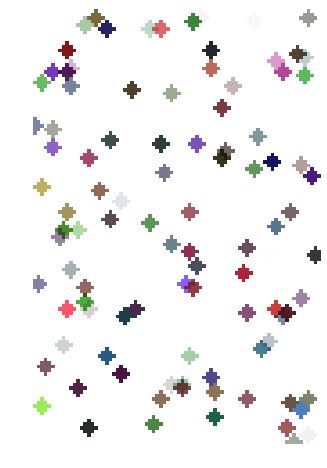

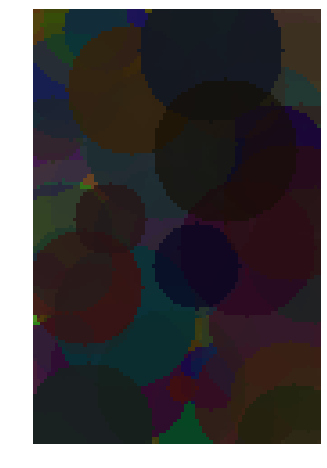

Generation: 70000, score: 1218.53279777, sigma: 0.93236116


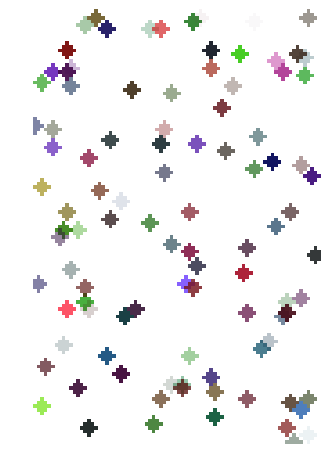

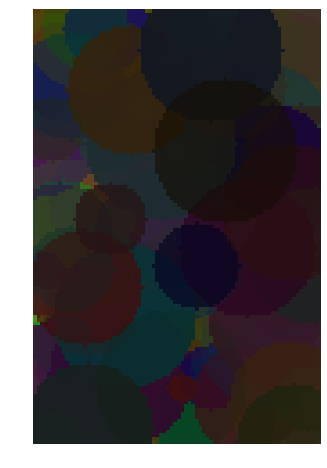

Generation: 71000, score: 1207.85334400, sigma: 0.93142880


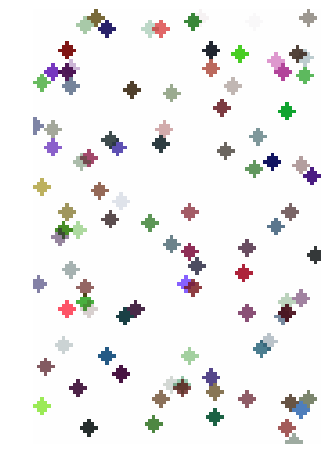

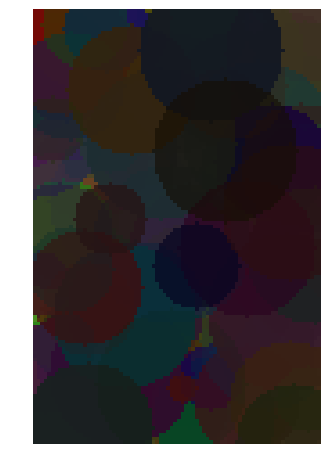

Generation: 72000, score: 1179.63866688, sigma: 0.93049737


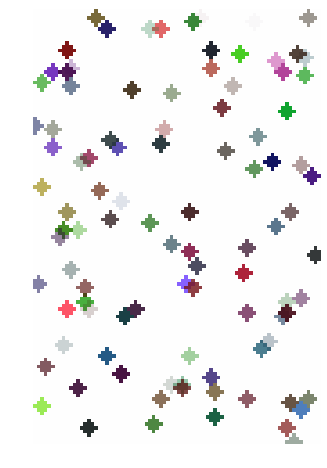

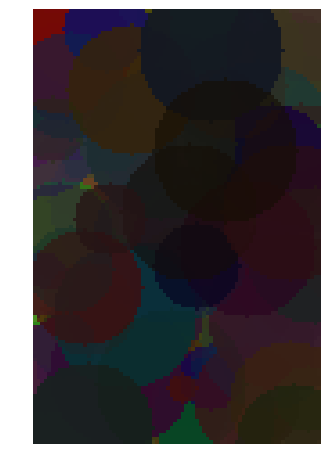

Generation: 73000, score: 1176.85588215, sigma: 0.92956688


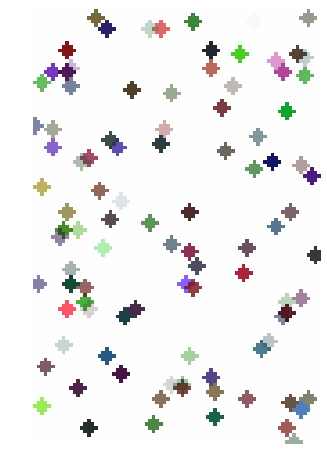

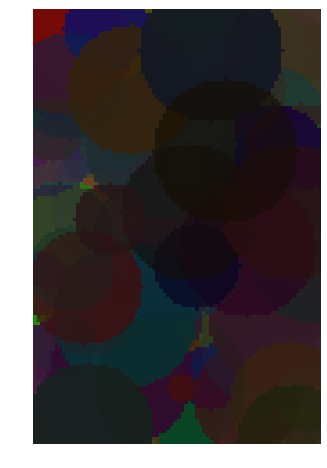

Generation: 74000, score: 1164.88300080, sigma: 0.92863731


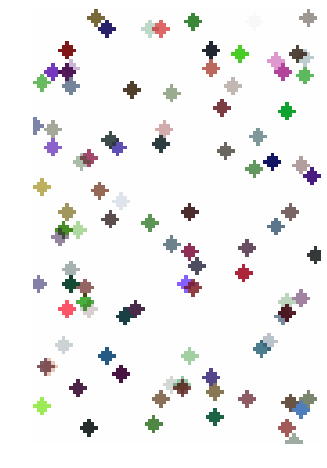

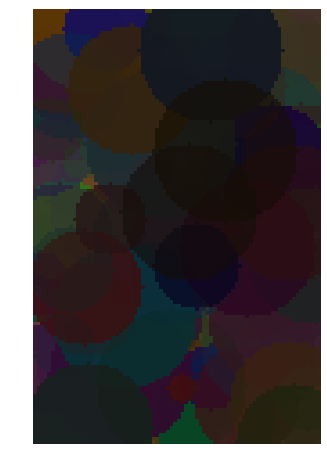

Generation: 75000, score: 1163.64118511, sigma: 0.92770867


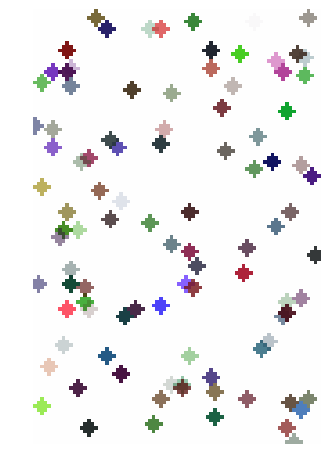

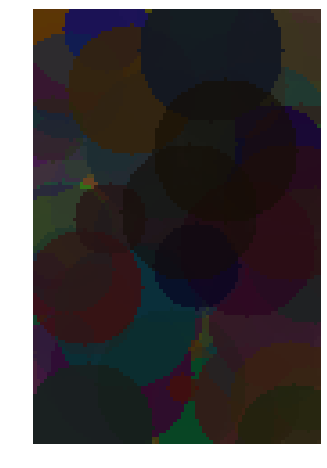

Generation: 76000, score: 1140.37113785, sigma: 0.92678096


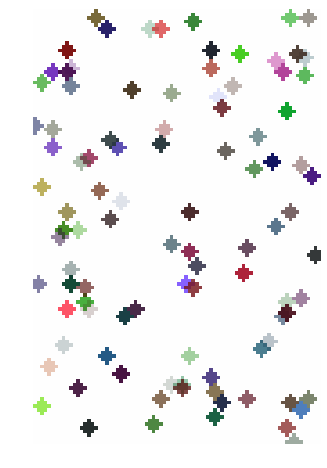

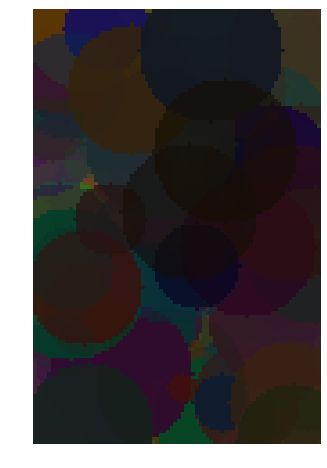

Generation: 77000, score: 1138.70381151, sigma: 0.92585418


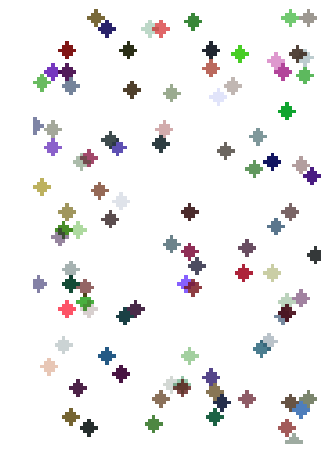

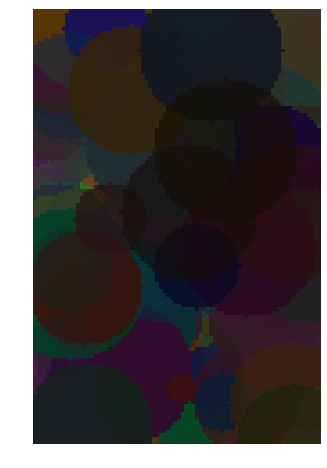

Generation: 78000, score: 1099.28560849, sigma: 0.92492833


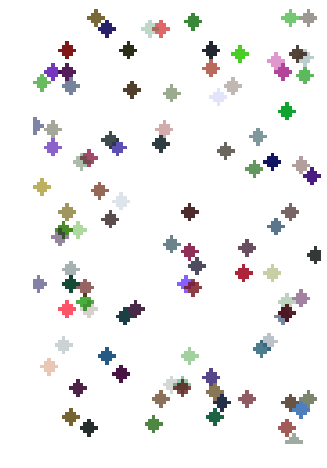

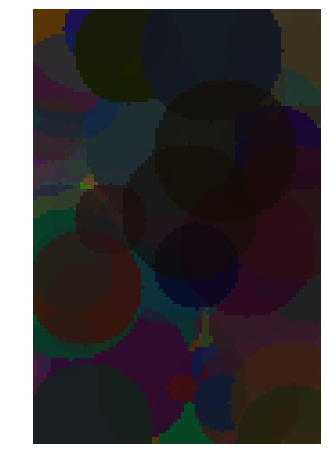

Generation: 79000, score: 1081.61686572, sigma: 0.92400340


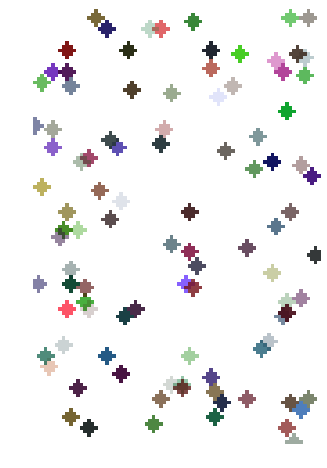

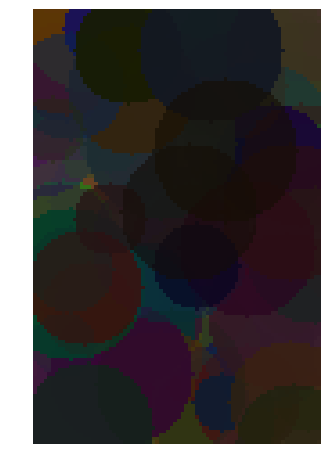

Generation: 80000, score: 1078.88654189, sigma: 0.92307940


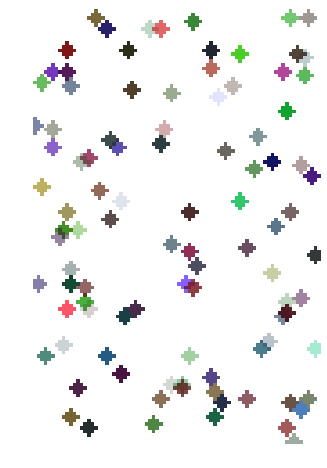

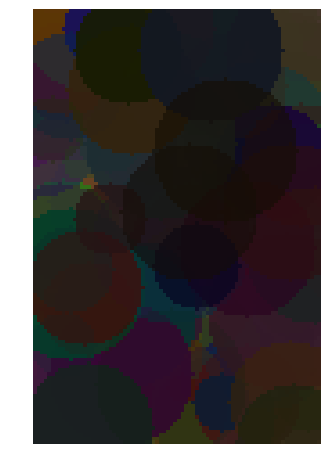

Generation: 81000, score: 1077.10522275, sigma: 0.92215632


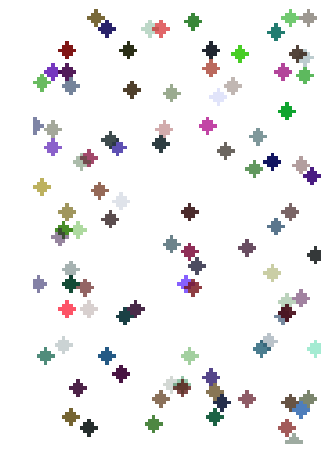

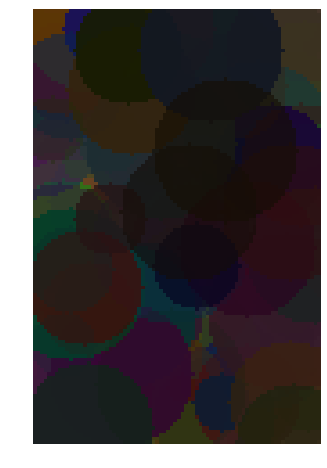

Generation: 82000, score: 1070.47840882, sigma: 0.92123416


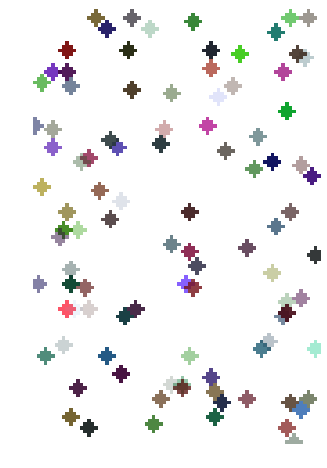

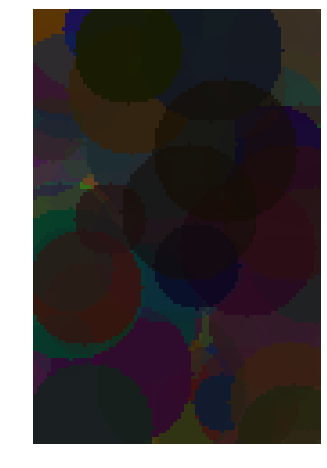

Generation: 83000, score: 1067.33541883, sigma: 0.92031293


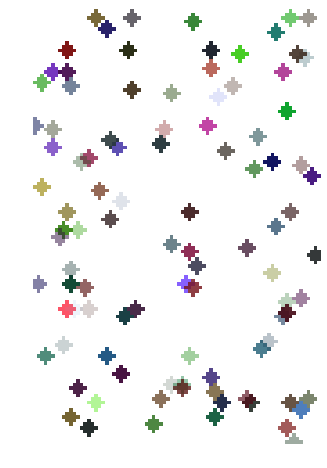

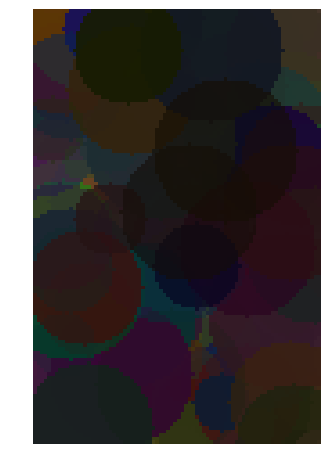

Generation: 84000, score: 1062.79782477, sigma: 0.91939262


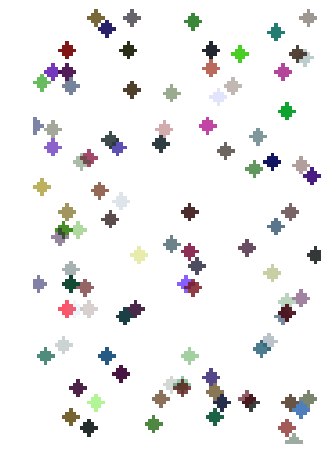

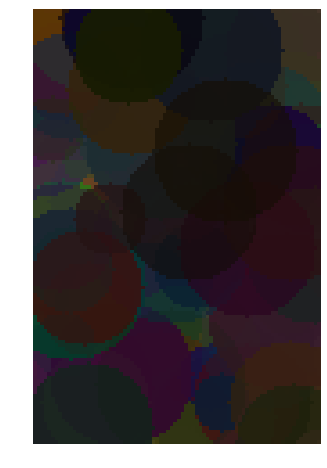

Generation: 85000, score: 985.64262593, sigma: 0.91847322


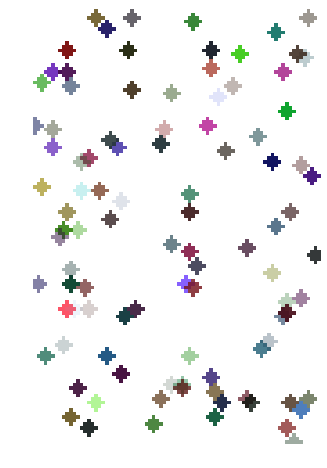

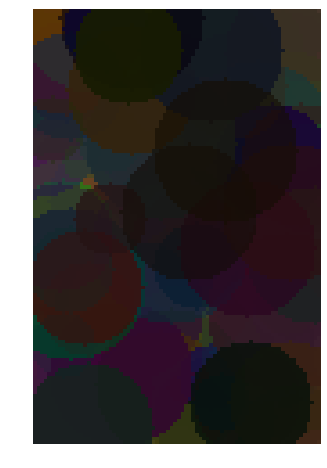

Generation: 86000, score: 985.03401907, sigma: 0.91755475


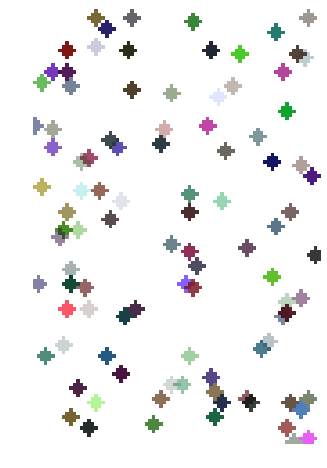

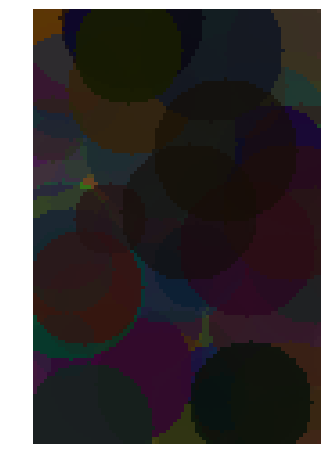

Generation: 87000, score: 965.14699029, sigma: 0.91663719


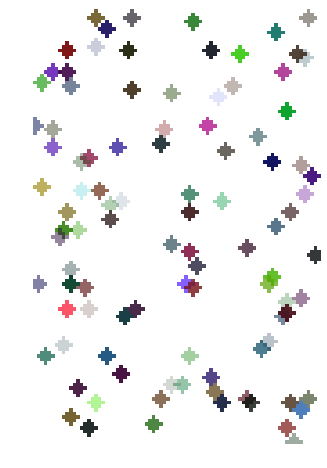

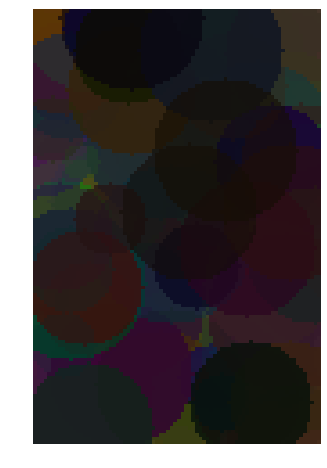

Generation: 88000, score: 957.18126675, sigma: 0.91572056


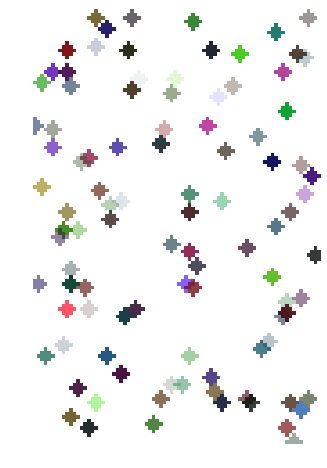

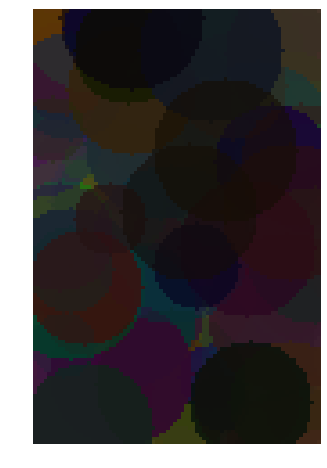

Generation: 89000, score: 953.72868660, sigma: 0.91480484


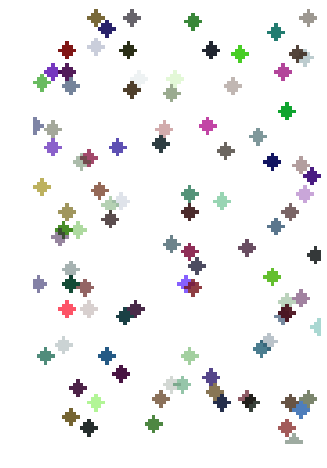

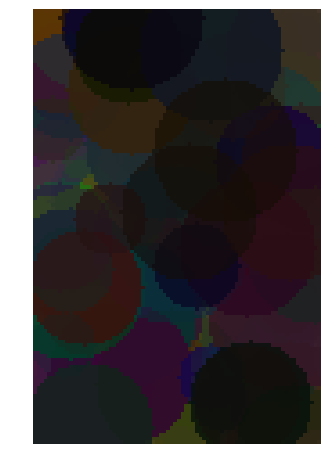

Generation: 90000, score: 950.71885074, sigma: 0.91389003


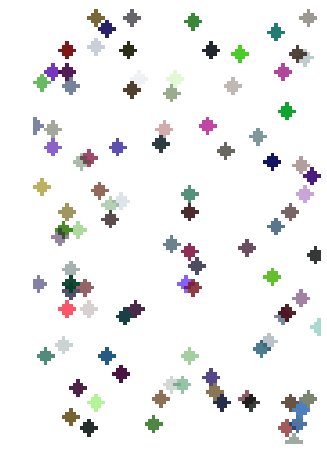

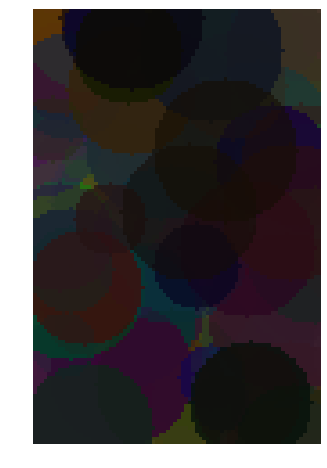

Generation: 91000, score: 950.15807392, sigma: 0.91297614


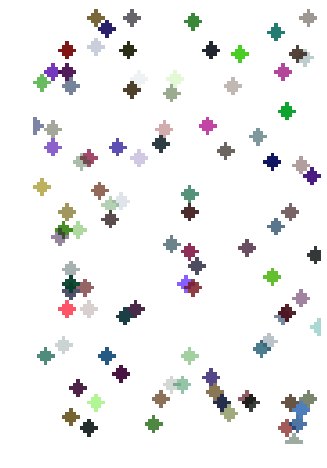

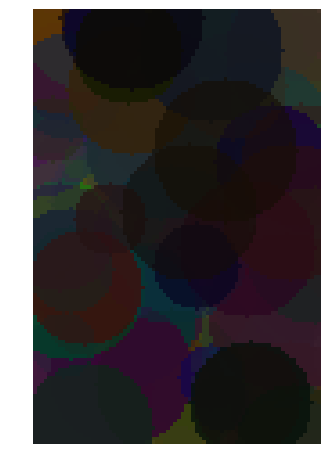

Generation: 92000, score: 949.29849876, sigma: 0.91206317


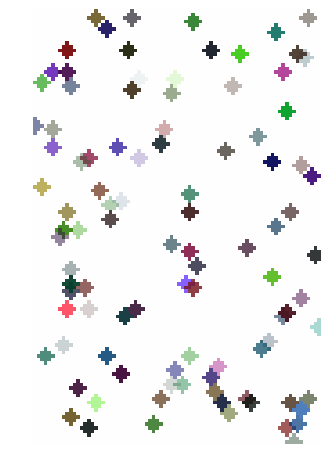

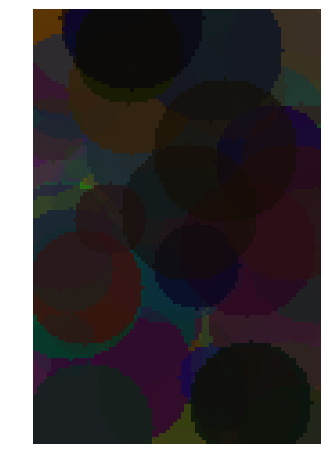

Generation: 93000, score: 948.87733748, sigma: 0.91115110


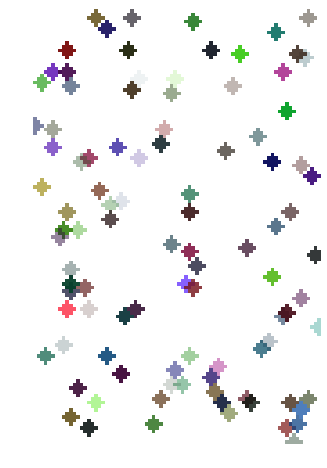

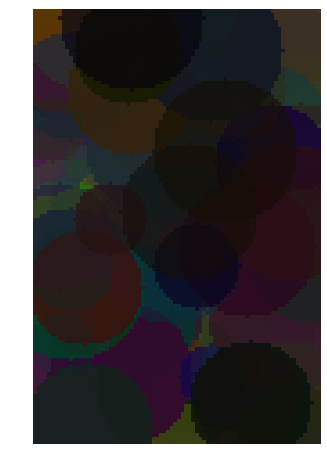

Generation: 94000, score: 948.59448037, sigma: 0.91023995


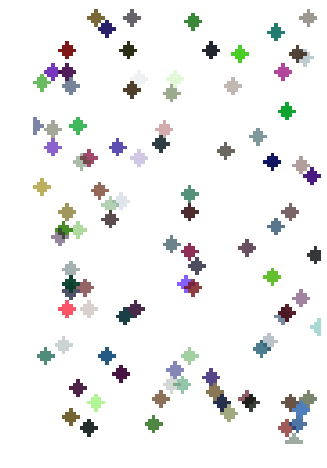

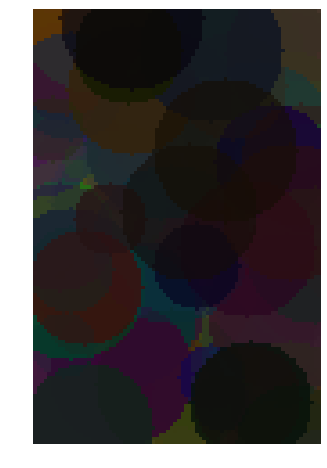

Generation: 95000, score: 934.91605278, sigma: 0.90932971


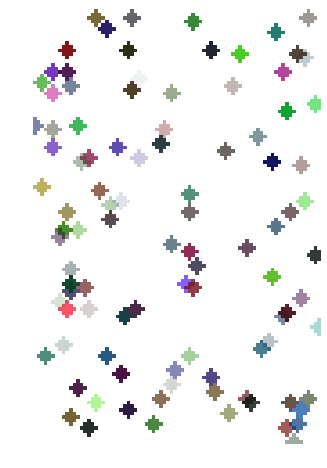

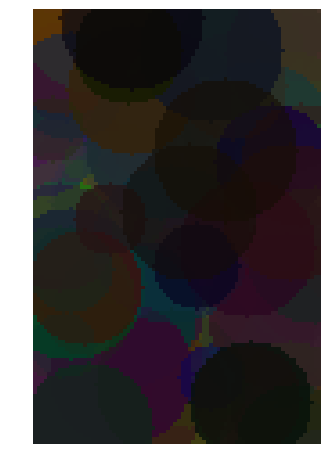

Generation: 96000, score: 934.27868998, sigma: 0.90842038


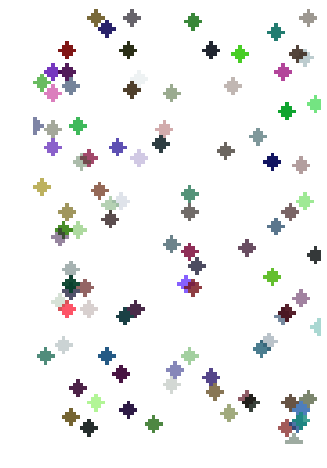

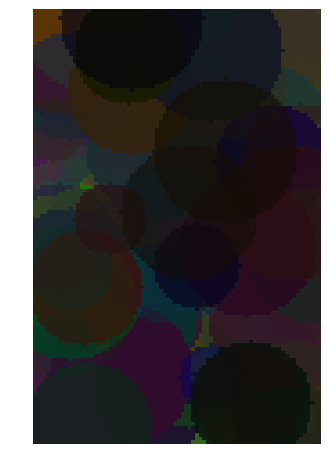

Generation: 97000, score: 933.57999278, sigma: 0.90751196


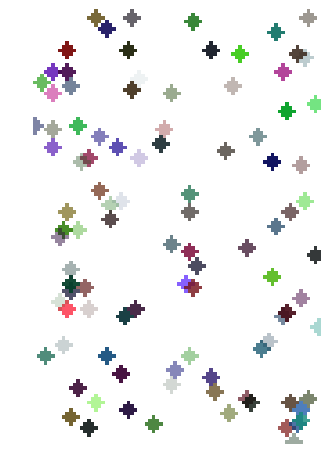

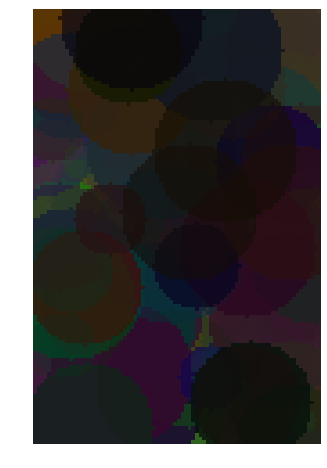

Generation: 98000, score: 924.33200380, sigma: 0.90660445


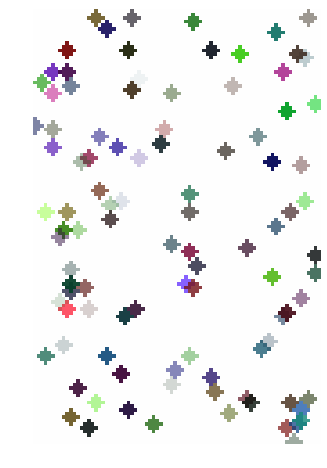

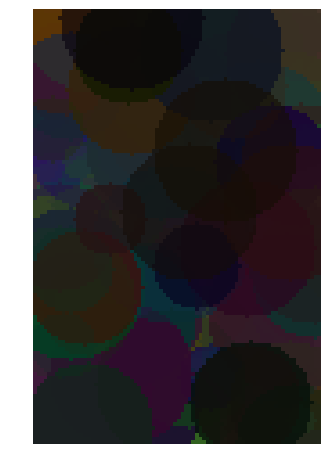

Generation: 99000, score: 922.89068972, sigma: 0.90569784


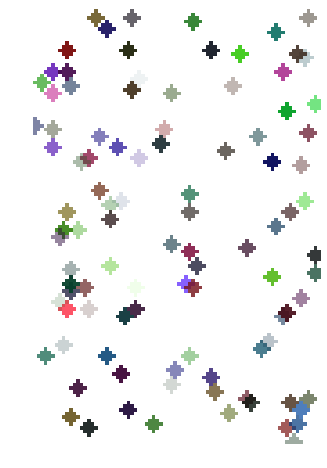

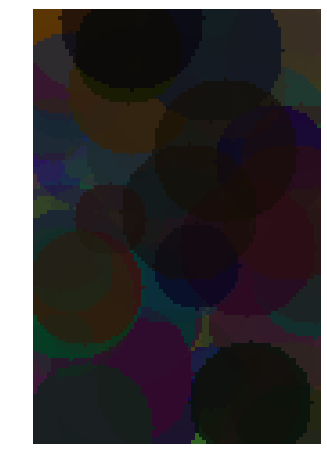

In [132]:
evolution = Evolution(target=rescaled_mona_lisa)
evolution.evolve(sigma=1, filename='results/mona01_best_chromosome100uniform.txt')

# ES(mi+lambda)

In [ ]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1
      ,min_domain=-100, max_domain=100):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    # current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_solutions = np.random.uniform(min_domain, max_domain, size=(population_size, chromosome_length))
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):
        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)
        
        
        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)
        
        # clip to domains
        children_population_solutions[children_population_solutions < min_domain] = min_domain
        children_population_solutions[children_population_solutions > max_domain] = max_domain
        
        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmasa

In [ ]:
class MseObjectiveFunction(object):
    """Mean Squared Error"""
    def __init__(self, target):
        self.target = target

    def score(self, population):
        """Calculates Mean Squared Error for given phenotype."""
        return np.square(population.phenotype - self.target).mean(axis=(1,2))

In [ ]:
class Population(object):
    def __init__(self, image_size, population_size, chromosome_length=100, sigma=1.0):
        self.image_size = image_size
        self.chromosome_length = chromosome_length
        self.gene_length = 7
        self.genotypes = np.random.uniform(0, 1, size=(population_size, chromosome_length, self.gene_length)).astype(float)
        self.sigmas = sigma * np.ones((population_size, chromosome_length, self.gene_length))
        self._phenotypes = None
        
    @property
    def phenotypes(self):
        return self._phenotypes

    @phenotypes.getter
    def phenotypes(self):
        if self._phenotypes is None:
            self.render()
        return self._phenotypes
    
    @phenotypes.setter 
    def phenotypes(self, val): 
        self._phenotypes = val 
    
    def decode_genotypes(self):
        genotypes = self.genotypes.copy()
        max_r = (self.image_size[0] + self.image_size[1]) / 10
        genotypes *= np.array([self.image_size[1], self.image_size[0], max_r, 255, 255, 255, 240])
        genotypes += np.array([0, 0, 2, 0, 0, 0, 15])
        return genotypes.astype(np.int16)

    def render(self):
        self.phenotype = np.ones(self.image_size) * 255
        circles = self.decode_genotypes()
        for x, y, radius, r, g, b, alpha in circles:
            background = self.phenotype.copy()
            cv2.circle(
                background,
                center=(x, y),
                radius=radius,
                color=(int(r), int(g), int(b)),
                thickness=-1,
            )
            alpha = alpha/255.0
            self.phenotype = cv2.addWeighted(background, 1- alpha, self.phenotype, alpha, 0)
        self.phenotype = self.phenotype.astype(np.int32)
    
    def normalize(self):
        chromosome_divided_by_2 = self.chromosome/2.0
        self.chromosome = np.absolute(chromosome_divided_by_2 - np.round(chromosome_divided_by_2))*2
#         self.chromosome = np.clip(self.chromosome, 0, 1)

    def mutate(self, sigma):
        new_individual = Individual(image_size=self.image_size, chromosome=self.chromosome.copy())

#         i = np.random.randint(0, self.chromosome_length)
#         num_of_params_to_modify = np.random.randint(0, self.gene_length)
#         selection = np.random.choice(self.gene_length, size=num_of_params_to_modify, replace=False)
#         if np.random.random() < 0.25:
#             new_individual.chromosome[i, selection] = np.random.randn(len(selection))
#         else:
#             new_individual.chromosome[i, selection] += sigma * np.random.randn(len(selection))
#         new_individual.normalize()

        if np.random.random() < 0.1:
            i = np.random.randint(0, self.chromosome_length)
            new_individual.chromosome[i] = np.random.uniform(0,1, size=self.gene_length)
            new_individual.normalize()
        elif np.random.random() < 0.2:
            i, j = random.randint(0, self.chromosome_length, size=2)
            new_individual.chromosome[[i, j]] = new_individual.chromosome[[j, i]]
        else:
            new_individual.chromosome += sigma * np.random.randn(self.chromosome_length, self.gene_length)
            new_individual.normalize()

        return new_individual

In [ ]:
class Evolution(object):
    def __init__(self, target, chromosome_length=100, chromosome=None, filename=None):
        if filename:
            chromosome = self.load_chromosome(filename)
        self.target = target
        self.individual = Individual(image_size=target.shape, chromosome_length=chromosome_length, chromosome=chromosome)
            
    def save_chromosome(self, filename):
        np.savetxt(filename, self.individual.chromosome)
        
    def load_chromosome(self, filename):
        return np.loadtxt(filename)
        
    def print_progress(self, generation, score, sigma):
        print("Generation: {}, score: {:.8f}, sigma: {:.8f}".format(generation, score, sigma))
#         print(np.square(self.individual.phenotype - self.target))
        show_image(render(self.individual))
        show_image(self.individual.phenotype)

    def evolve(self, objective_function=MseObjectiveFunction, sigma=1.0, theta1=1/0.82, theta2=0.999, k=1000,
               number_of_iterations=100000, log_frequency=1000, filename=None):
        objective_function = objective_function(self.target)

        score = objective_function.score(self.individual)
        successful_mutations_count = 0
        
        for i in range(number_of_iterations):

            mutated = self.individual.mutate(sigma)
            new_score = objective_function.score(mutated)

            if new_score < score:
                score = new_score
                self.individual = mutated
                successful_mutations_count += 1
            
            if (i + 1) % k == 0:
                if successful_mutations_count > k/5.0:
                    sigma = theta1 * sigma
                else:
                    sigma = theta2 * sigma
                successful_mutations_count = 0
                
            
            if i % log_frequency == 0:
                self.print_progress(i, score, sigma)
                
        if filename:   
            self.save_chromosome(filename)